In [1]:
import os
import glob
import gc
import rioxarray as rxr
import xarray as xr
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dask as da
from scipy.stats import skew
from rasterio.features import rasterize
from matplotlib.lines import Line2D
from rasterio.transform import from_origin
from rasterio.mask import mask
from shapely.geometry import box
from mpl_toolkits.mplot3d import Axes3D
import lexcube
import ipywidgets as widgets
import pyvista as pv
import seaborn as sns
from scipy.interpolate import make_interp_spline
from matplotlib.font_manager import FontProperties

In [2]:
!pip freeze > requirements.txt

In [2]:
gc.collect()

40

# Create an xarray Dataset

First, load all data. It is made sure that extent, projection and resolution match exactly, this is implemented using the gdalwarp funct in in reproject.R.

Then, save data into a mulitdimensional xarray with dimensions time, x, y and all forest variables, i.e. fcsd, agbd, cover, fhd_normal, rh_95. FCCL is aggregated to yearly changes, altough monthly information is preserved in the values themselves.

In [3]:
# list files
fcsd_paths = glob.glob("./data/reproj/final/DE*.tif")
fcsd_paths.sort()
agbd_paths = glob.glob("./data/reproj/final/*agbd*.tif")
agbd_paths.sort()
cover_paths = glob.glob("./data/reproj/final/*cove*.tif")
cover_paths.sort()
fhd_normal_paths = glob.glob("./data/reproj/final/*fhd*.tif")
fhd_normal_paths.sort()
rh_95_paths = glob.glob("./data/reproj/final/*rh*.tif")
rh_95_paths.sort()
fccl_path = "./data/reproj/final/FCCL_fullseries_GER_epsg3035.tif"

# read all files and save to data array
tifs = []
for file in fcsd_paths:
        tif = rxr.open_rasterio(file, masked=True, chunks='auto').squeeze()
        tif = tif.rio.write_crs("EPSG:3035")
        tif.name = 'fcsd'
        tifs.append(tif)

for file in agbd_paths:
        tif = rxr.open_rasterio(file, masked=True, chunks='auto').squeeze()
        tif = tif.rio.write_crs("EPSG:3035")
        tif.name = 'agbd'
        tifs.append(tif)

for file in cover_paths:
        tif = rxr.open_rasterio(file, masked=True, chunks='auto').squeeze()
        tif = tif.rio.write_crs("EPSG:3035")
        tif.name = 'cover'
        tifs.append(tif)

for file in fhd_normal_paths:
        tif = rxr.open_rasterio(file, masked=True, chunks='auto').squeeze()
        tif = tif.rio.write_crs("EPSG:3035")
        tif.name = 'fhd_normal'
        tifs.append(tif)

for file in rh_95_paths:
        tif = rxr.open_rasterio(file, masked=True, chunks='auto').squeeze()
        tif = tif.rio.write_crs("EPSG:3035")
        tif.name = 'rh_95'
        tifs.append(tif)

# fccl (covert monthly resolution to yearly)
fccl = rxr.open_rasterio(fccl_path, masked=True, chunks='auto').squeeze()
fccl = fccl.rio.write_crs("EPSG:3035")

value_ranges = {
    "2017": (1, 4),
    "2018": (5, 16),
    "2019": (17, 28),
    "2020": (29, 40),
    "2021": (41, 52),
    "2022": (53, 64),
    "2023": (65, 76)
}

for i, (year, (min_val, max_val)) in enumerate(value_ranges.items()):
    # Mask values outside the range (1-4 for 2017, etc.)
    yearly_fccl = xr.where(
        (fccl >= min_val) & (fccl <= max_val),
        fccl,
        xr.where(fccl == 0, 0, np.nan)
    )
    yearly_fccl.name = 'fccl'
    tifs.append(yearly_fccl)

# merge data of years 2017 to 2023 per year
years = pd.date_range('2017', '2024', freq='YE')
d1 = xr.merge([tifs[4],tifs[11],tifs[18],tifs[25],tifs[32]]).assign_coords(time=years[0])
d2 = xr.merge([tifs[0],tifs[5],tifs[12],tifs[19],tifs[26],tifs[33]]).assign_coords(time=years[1])
d3 = xr.merge([tifs[1],tifs[6],tifs[13],tifs[20],tifs[27],tifs[34]]).assign_coords(time=years[2])
d4 = xr.merge([tifs[2],tifs[7],tifs[14],tifs[21],tifs[28],tifs[35]]).assign_coords(time=years[3])
d5 = xr.merge([tifs[3],tifs[8],tifs[15],tifs[22],tifs[29],tifs[36]]).assign_coords(time=years[4])
d6 = xr.merge([tifs[9],tifs[16],tifs[23],tifs[30],tifs[37]]).assign_coords(time=years[5])
d7 = xr.merge([tifs[10],tifs[17],tifs[24],tifs[31],tifs[38]]).assign_coords(time=years[6])

# merge all years to an xarray dataset
d = xr.concat([d1,d2,d3,d4,d5,d6,d7], dim='time')
d

<xarray.Dataset> Size: 1TB
Dimensions:      (time: 7, y: 87752, x: 69419)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 555kB 4.008e+06 4.008e+06 ... 4.702e+06 4.702e+06
  * y            (y) float64 702kB 3.562e+06 3.562e+06 ... 2.684e+06 2.684e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 56B 2017-12-31 2018-12-31 ... 2023-12-31
Data variables:
    agbd         (time, y, x) float32 171GB dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    cover        (time, y, x) float32 171GB dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    fhd_normal   (time, y, x) float32 171GB dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    rh_95        (time, y, x) float32 171GB dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    fccl         (time, y, x) float64 341GB dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
    fcsd         (time, y, x) float32 171GB dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# Visualise the data cube

In [ ]:
# select variable
v_cover = d['cover'].coarsen(x=500, y=500, boundary='trim').mean().compute()
v_agbd = d['agbd'].coarsen(x=500, y=500, boundary='trim').mean().compute()
v_fhd_normal = d['fhd_normal'].coarsen(x=500, y=500, boundary='trim').mean().compute()
v_rh_95 = d['rh_95'].coarsen(x=500, y=500, boundary='trim').mean().compute()
v_fccl = d['fccl'].coarsen(x=500, y=500, boundary='trim').mean().compute()
v_fcsd = d['fcsd'].coarsen(x=500, y=500, boundary='trim').mean().compute()

In [28]:
# Option 1: 3D data cube visualisation using lexcube
#ds = xr.open_dataset("https://data.rsc4earth.de/download/EarthSystemDataCube/v3.0.2/esdc-8d-0.25deg-256x128x128-3.0.2.zarr/", chunks={}, engine="zarr")
#da = ds["air_temperature_2m"][256:512,256:512,256:512]
w = lexcube.Cube3DWidget(v_cover, cmap="autumn")
w

Xarray input object does not have chunks. You can re-open with 'chunks={}' to enable dask for caching and progress reporting functionality - but may be overall slower for small data sets.


Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [ ]:
# Option 2: 4D data cube visualisation using pyvista
variables = {
    "TCC": v_cover,
    "AGBD": v_agbd,
    "FHDI": v_fhd_normal,
    "CH": v_rh_95,
    "FCCL": v_fccl,
    "FCSD": v_fcsd,
}

# Create plotter
plotter = pv.Plotter()

# Spatial placement parameters
x_spacing = 100  # Space between cubes in x
y_spacing = 100  # Space between cubes in y

# Loop through variables and place them
for idx, (name, var) in enumerate(variables.items()):
    # Determine position in 2x3 grid
    row = idx // 3
    col = idx % 3

    # Get data shape and values
    shape = var.shape
    values = var.values.astype(np.float32)

    # Create voxel grid
    grid = pv.UniformGrid()
    grid.dimensions = np.array(shape) + 1
    grid.spacing = (1, 1, 1)  # Can adjust this to exaggerate scale
    grid.origin = (col * x_spacing, -row * y_spacing, 0)

    # Add scalar data
    grid.cell_data["values"] = values.flatten(order="F")

    # Add to plotter
    plotter.add_volume(grid, scalars="values", cmap="viridis", opacity="sigmoid", name=name)

    # Optional: Add a label
    center = np.array(grid.center)
    plotter.add_point_labels([center], [name], font_size=12, point_color='white', text_color='black')

# Set background and view
plotter.set_background("white")
plotter.show_bounds(grid='back', location='outer', all_edges=True)

# Show the scene
plotter.show()


# First experiments on the xarray dataset

Getting to know xarray data indexing, plotting, descriptive statistics, subsetting ... 

In [4]:
## general ##
# pull out a dataarray
#da = d.agbd
#da.dims
#da.coords

# extracting coordinate variables
#da.x

# extracting the first element of da
#print(da.data[0,0,0].compute())

# extracting specific element from d
#print(d.agbd.isel(time=0, x=1, y=1).compute())

In [ ]:
# compute mean of agbd in year 2017 over the entire of Germany
#d.agbd.isel(time=0).mean().compute()

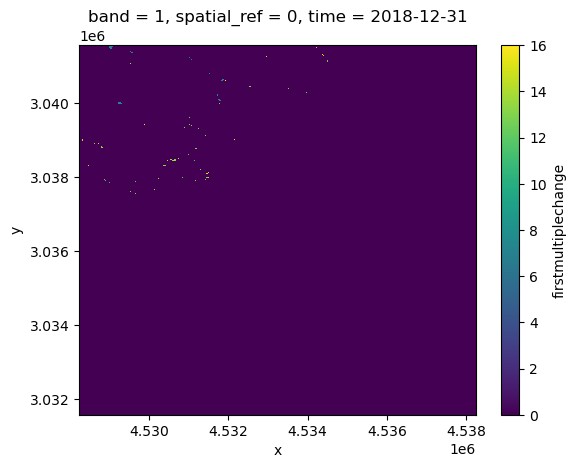

In [62]:
# exemplary plot
d.sel(time=str(2018)).fccl.isel(x=slice(52000,53000),y=slice(52000,53000)).plot()
#.coarsen(x=400, y=400, boundary="trim").mean()

# Pixel-based descriptive statistics of the Single RS Products

Compute pixel-based descriptive statistics 

* of the single RS products (AGBD, TCC, FHDI, CH and FCSD) and
* of the single RS products for different tree species.

In [4]:
def compute_descriptive_statistics(data_set, mask=None, dim=["x", "y"], skipna=True):
    """
    Compute yearly descriptive statistics for a given data set with an optional mask.
    
    Parameters:
    - data_set: The data array to compute statistics on (e.g., d.agbd, d.cover).
    - mask: Optional mask to apply to the data (e.g., fccl == 0 or fccl > 0).
    - dim: List of dimensions to perform the reduction over (default is ["x", "y"]).
    - skipna: Whether to skip NaN values (default is True).
    
    Returns:
    - A dictionary containing the computed statistics.
    """
    # Apply the mask if provided
    if mask is not None:
        data_set = xr.apply_ufunc(
            lambda data, mask: np.where(mask, data, np.nan),
            data_set,
            mask,
            dask="allowed",
            vectorize=True
        )
    
    # Basic statistics
    mean = data_set.mean(dim=dim, skipna=skipna).compute()
    median = data_set.median(dim=dim, skipna=skipna).compute()
    std_dev = data_set.std(dim=dim, skipna=skipna).compute()
    min_val = data_set.min(dim=dim, skipna=skipna).compute()
    max_val = data_set.max(dim=dim, skipna=skipna).compute()

    # Quartiles
    q1_data = xr.apply_ufunc(
        lambda arr, med: np.where(arr <= med[:, None, None], arr, np.nan),
        data_set,
        median,
        input_core_dims=[dim, []],
        output_core_dims=[dim],
        vectorize=True,
        dask="allowed"
    )
    q1 = q1_data.median(dim=dim, skipna=skipna).compute()
    
    q3_data = xr.apply_ufunc(
        lambda arr, med: np.where(arr >= med[:, None, None], arr, np.nan),
        data_set,
        median,
        input_core_dims=[dim, []],
        output_core_dims=[dim],
        vectorize=True,
        dask="allowed"
    )
    q3 = q3_data.median(dim=dim, skipna=skipna).compute()
    
    # Interquartile range (IQR)
    iqr = q3 - q1
    
    # Outlier bounds
    outlier_min = q1 - 1.5 * iqr
    outlier_max = q3 + 1.5 * iqr
    
    # Range
    data_range = max_val - min_val
    
    return {
        "mean": mean.values,
        "median": median.values,
        "std_dev": std_dev.values,
        "min": min_val.values,
        "max": max_val.values,
        "q1": q1.values,
        "q3": q3.values,
        "iqr": iqr.values,
        "outlier_min": outlier_min.values,
        "outlier_max": outlier_max.values,
        "range": data_range.values
    }

def plot_statistics_df(ax, time_values, dataset_name, stats_df, mask_type=None, highlight_time=None, metrics_dict=None):
    """
    Plot statistics for a given dataset and mask type on a specific axis using stats_df.
    
    Parameters:
    - ax: The matplotlib axis to plot on.
    - time_values: Array of time values (years).
    - dataset_name: Name of the dataset to plot (e.g., 'AGBD', 'TCC').
    - stats_df: DataFrame containing statistics to plot.
    - mask_type: Either 'fccl_0', 'fccl_gt0', or None if mask type is not applicable.
    - highlight_time: A specific timestamp to highlight with a vertical red line.
    - metrics_dict: Dictionary mapping dataset names to their corresponding metrics (e.g., {'AGBD': 'MgC/ha', 'TCC': '%'}).
    """
    # Filter the DataFrame for the specific dataset
    if mask_type is not None:
        filtered_df = stats_df[(stats_df['Dataset'] == dataset_name) & (stats_df['mask'] == mask_type)]
    else:
        filtered_df = stats_df[stats_df['Dataset'] == dataset_name]
    
    # Extract values from the filtered DataFrame
    mean_values = filtered_df[[f'mean_{year}' for year in time_values]].values.flatten()
    median_values = filtered_df[[f'median_{year}' for year in time_values]].values.flatten()
    q1_values = filtered_df[[f'q1_{year}' for year in time_values]].values.flatten()
    q3_values = filtered_df[[f'q3_{year}' for year in time_values]].values.flatten()
    min_values = filtered_df[[f'min_{year}' for year in time_values]].values.flatten()
    max_values = filtered_df[[f'max_{year}' for year in time_values]].values.flatten()

    # Plot the statistics using the median as the main plot
    ax.errorbar(time_values, median_values, 
                yerr=[median_values - q1_values, q3_values - median_values], 
                fmt='-o', label='Median (Q1-Q3)', capsize=5, linewidth=4)
    ax.fill_between(time_values, min_values, max_values, color='gray', alpha=0.3, label='Min-Max Range')
    
    # Plot mean values as dots
    ax.scatter(time_values, mean_values, color='orange', label='Mean', zorder=5)

    # Add a vertical red line at the highlight time, if provided
    if highlight_time is not None:
        ax.axvline(highlight_time, color='red', linestyle='--', linewidth=2, label=f'Highlight: {highlight_time}')
    
    # Set axis labels and title
    ax.set_xticks(time_values)
    ax.set_xticklabels([str(t)[:4] for t in time_values], fontsize=11)
    ax.tick_params(axis='y', labelsize=15)
    
    # Determine metric from the metrics dictionary
    metric = metrics_dict.get(dataset_name, '') if metrics_dict else ''
    ylabel = f'{dataset_name} [{metric}]' if metric else dataset_name
    ax.set_ylabel(ylabel, fontsize=16)
    
    ax.legend(loc='upper right')


def expand_years(mask):
    """
    Expand a 2D mask into a 3D array by repeating it across a specified time dimension.
    
    This function replicates a 2D `mask` along a new `time` dimension, defined by the given range of years, 
    resulting in a 3D xarray.DataArray with coordinates aligned to the specified time values.
    
    Parameters:
    - mask: xarray.DataArray
        A 2D array (e.g., spatial mask) to be expanded.
    - years: pandas.DatetimeIndex
        A range of end-of-year timestamps defining the new time dimension.
    
    Returns:
    - expanded_mask: xarray.DataArray
        A 3D array with dimensions `(x, y, time)`, where the `time` coordinate matches the input years.
    """
    return xr.apply_ufunc(
        lambda y: np.repeat(y[:,:,np.newaxis], 7, axis = 2),
        mask,
        output_core_dims=[['time']],
        vectorize=True,
        dask="allowed"
    ).assign_coords({'time': years})


# Characteristics of Forest Structure in Germany

In [ ]:
# Compute descriptive statistics of the variables AGBD, TCC, FHDI, CH and FCSD over entire Germany

datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {}
for name, data in datasets.items():
    stats = compute_descriptive_statistics(data)
    stats['Dataset'] = name
    stats_dict[name] = stats

In [ ]:
# write to dataframe
stats_df = pd.DataFrame.from_records(stats_dict).T.reset_index()
stats_df.columns = ['Dataset'] + list(stats_df.columns[1:])
expanded_columns = {}
years = range(2017, 2024)
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None)
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)

# write to csv
stats_df.to_csv("./data/descriptive_stats_germany.csv", index=False)
stats_df

,Dataset,Dataset,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,AGBD,194.776993,182.295654,180.524109,178.347748,170.354279,168.500977,166.158844,197.0,...,254.0,270.5,239.0,317.0,338.0,333.0,322.0,339.0,312.0,269.0
1,CH,CH,22.487902,20.962240,21.296444,21.228817,20.503523,20.269320,20.973385,23.0,...,29.0,29.0,27.5,30.0,31.0,36.0,32.0,37.0,32.0,29.0
2,FCSD,FCSD,NaN,1692.856201,1857.038574,1745.878174,1451.356567,NaN,NaN,NaN,...,2761.5,NaN,NaN,NaN,9885.0,9766.0,9808.0,9779.0,NaN,NaN
3,FHDI,FHDI,265.851044,278.666443,279.404816,280.126007,276.478943,281.195312,278.757477,270.0,...,327.5,337.0,331.0,219.0,224.0,226.0,224.0,230.0,238.0,225.0
4,TCC,TCC,55.892860,58.015671,57.686092,58.666088,55.621567,57.839909,58.438347,58.0,...,90.5,95.0,88.0,80.0,87.0,87.0,87.0,87.0,87.0,87.0


# Characteristics of Forest Structure in stand-replacing Damage Pattern

Compute descriptive statistics 
* of the single RS products in the Zones of FCCL areas vs non-FCCL areas,
* for FCCL in a specific year.


In [ ]:
# Compute descriptive statistics of the variables AGBD, TCC, FHDI, CH and FCSD for areas where FCCL = 0 and FCCL > 0 during the SAME time stamp

datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {
    name: {
        'fccl_0': compute_descriptive_statistics(data, mask=(d.fccl == 0)),
        'fccl_gt0': compute_descriptive_statistics(data, mask=(d.fccl > 0)),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [ ]:
# write to dataframe
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_germany_fccl0_gt0.csv", index=False)
stats_df

In [8]:
stats_df = pd.read_csv("./data/descriptive_stats_germany.csv")
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,fccl_0,194.773880,182.902110,181.182300,179.134020,171.014830,169.299620,166.627960,197.0,...,254.0,271.5,237.5,317.0,338.0,332.0,322.0,339.0,312.0,269.0
1,AGBD,fccl_gt0,196.664640,113.810850,134.136890,134.497060,114.377880,98.165990,113.172730,200.0,...,275.0,263.0,262.5,297.0,317.0,303.0,276.0,264.0,272.0,261.0
2,TCC,fccl_0,55.893130,58.206657,57.942863,59.022884,55.911130,58.119340,58.595333,58.0,...,91.5,92.0,88.0,80.0,87.0,87.0,87.0,87.0,87.0,87.0
3,TCC,fccl_gt0,55.722320,36.448517,39.589180,38.768433,31.081440,33.230420,40.704670,58.0,...,76.5,80.0,76.0,77.0,83.0,84.0,84.0,82.0,83.0,82.0
4,FHDI,fccl_0,265.854500,278.970370,279.727480,280.555450,277.022400,281.667080,279.034400,270.0,...,327.5,338.0,331.0,219.0,224.0,226.0,224.0,230.0,238.0,225.0
5,FHDI,fccl_gt0,263.713530,244.344560,256.660830,256.173340,230.423320,239.650090,247.482120,267.0,...,378.5,375.5,366.0,204.0,208.0,208.0,198.0,213.0,217.0,212.0
6,CH,fccl_0,22.488125,21.015226,21.351042,21.291962,20.568848,20.347942,21.013535,23.0,...,29.0,29.0,27.5,30.0,31.0,36.0,32.0,37.0,32.0,29.0
7,CH,fccl_gt0,22.348015,14.978229,17.448006,17.707197,14.967046,13.345213,16.437912,23.0,...,35.0,30.5,30.5,30.0,29.0,31.0,30.0,30.0,29.0,27.0
8,FCSD,fccl_0,NaN,1681.771600,1829.064500,1705.430800,1427.851000,NaN,NaN,NaN,...,2732.0,NaN,NaN,NaN,9885.0,9766.0,9808.0,9779.0,NaN,NaN
9,FCSD,fccl_gt0,NaN,2930.206800,4022.457000,4268.462400,3702.126000,NaN,NaN,NaN,...,13125.5,NaN,NaN,NaN,9730.0,9740.0,9772.0,9762.0,NaN,NaN


In [142]:
# calculate descriptive statistics for a static FCCL mask, i.e. only changes in a specific year

# this makes it necessary to expand the time dimension to fit the rest of the dataset
# select pixels based on year of fccl
# only one at a time, otherwise RAM explodes !!!

years = pd.date_range('2017', '2024', freq='YE')

#fccl_mask_0_allyears = expand_years((d.fccl == 0).all(dim='time'))
fccl_mask_2018 = expand_years((d.fccl.sel(time="2018") > 0).squeeze().drop_vars('time'))
#fccl_mask_2019 = expand_years((d.fccl.sel(time="2019") > 0).squeeze().drop_vars('time'))
#fccl_mask_2020 = expand_years((d.fccl.sel(time="2020") > 0).squeeze().drop_vars('time'))
#fccl_mask_2021 = expand_years((d.fccl.sel(time="2021") > 0).squeeze().drop_vars('time'))
#fccl_mask_2022 = expand_years((d.fccl.sel(time="2022") > 0).squeeze().drop_vars('time'))
#fccl_mask_2023 = expand_years((d.fccl.sel(time="2023") > 0).squeeze().drop_vars('time'))

# Add the time-specific mask to dataset
#d = d.assign(fccl_mask_0_allyears=fccl_mask_0_allyears)
d = d.assign(fccl_mask_2018=fccl_mask_2018)
#d = d.assign(fccl_mask_2019=fccl_mask_2019)
#d = d.assign(fccl_mask_2020=fccl_mask_2020)
#d = d.assign(fccl_mask_2021=fccl_mask_2021)
#d = d.assign(fccl_mask_2022=fccl_mask_2022)
#d = d.assign(fccl_mask_2023=fccl_mask_2023)

In [ ]:
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

# Compute statistics for 2018
stats_dict = {
    name: {
        #'fccl_mask_0_allyears': compute_descriptive_statistics(data, mask=d.fccl_mask_0_allyears),
        #'fccl_mask_2018': compute_descriptive_statistics(data, mask=d.fccl_mask_2018),
        #'fccl_mask_2019': compute_descriptive_statistics(data, mask=d.fccl_mask_2019),
        #'fccl_mask_2020': compute_descriptive_statistics(data, mask=d.fccl_mask_2020),
        #'fccl_mask_2021': compute_descriptive_statistics(data, mask=d.fccl_mask_2021),
        #'fccl_mask_2022': compute_descriptive_statistics(data, mask=d.fccl_mask_2022),
        'fccl_mask_2023': compute_descriptive_statistics(data, mask=d.fccl_mask_2023),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [ ]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_german_fccl_mask_2023_allpixels.csv", index=False)
stats_df

In [14]:
# load stats_df, if necessary
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
stats_df = pd.read_csv("./data/descriptive_stats_german_fccl_mask_2023_allpixels.csv")
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,fccl_mask_2023,211.534580,201.241010,198.598860,193.894700,188.898560,169.731690,113.172730,213.0,...,298.5,318.0,262.5,304.0,316.0,303.0,274.0,279.0,278.0,261.0
1,TCC,fccl_mask_2023,58.568360,58.348450,57.413715,58.895367,54.378216,52.441154,40.704670,60.0,...,85.5,89.0,76.0,77.0,83.0,84.0,84.0,83.0,83.0,82.0
2,FHDI,fccl_mask_2023,281.512600,293.149230,290.207950,290.983580,282.962800,285.003540,247.482120,287.0,...,330.0,354.5,366.0,204.0,205.0,197.0,190.0,215.0,212.0,212.0
3,CH,fccl_mask_2023,25.019512,23.787498,23.400148,23.478876,22.956865,21.032398,16.437912,26.0,...,31.0,35.5,30.5,30.0,30.0,31.0,30.0,35.0,29.0,27.0
4,FCSD,fccl_mask_2023,NaN,2089.215300,2414.590000,2353.142000,1893.911000,NaN,NaN,NaN,...,3563.0,NaN,NaN,NaN,9612.0,9629.0,9624.0,9631.0,NaN,NaN


In [9]:
# get number of samples for each mask

num_pixels_fccl_2019 = (d.fccl.sel(time="2019") > 0).sum().compute().item()
num_pixels_fccl_2020 = (d.fccl.sel(time="2020") > 0).sum().compute().item()
num_pixels_fccl_2021 = (d.fccl.sel(time="2021") > 0).sum().compute().item()

print(f"Number of pixels where fccl > 0 in 2019: {num_pixels_fccl_2019}")
print(f"Number of pixels where fccl > 0 in 2020: {num_pixels_fccl_2020}")
print(f"Number of pixels where fccl > 0 in 2021: {num_pixels_fccl_2021}")

Number of pixels where fccl > 0 in 2020: 19458773
Number of pixels where fccl > 0 in 2021: 12659626


In [5]:
num_pixels_fccl_any = (d.fccl > 0).any(dim='time').sum().compute().item()
print(f"Number of pixels where fccl > 0 in all years: {num_pixels_fccl_any}")

Number of pixels where fccl > 0 in all years: 86672992


In [6]:
num_pixels_fccl_any = (d.fccl == 0).any(dim='time').sum().compute().item()
print(f"Number of pixels where fccl == 0 in all years: {num_pixels_fccl_any}")

Number of pixels where fccl == 0 in all years: 998141928


# Characteristics of Forest Structure in non-stand-replacing Damage Pattern


In [17]:
# Find out which threshold of FCSD increase to choose

fcsd_data = d['fcsd'].isel(x=slice(52000,53000),y=slice(52000,53000))
fcsd_diff = fcsd_data.diff(dim='time')

# Extract specific years of interest
diff_2019_2018 = fcsd_diff.sel(time='2019')
diff_2020_2019 = fcsd_diff.sel(time='2020')
diff_2021_2020 = fcsd_diff.sel(time='2021')

# Initialize a dictionary to store results
fcsd_results = {}

'''# Loop over the differences and compute metrics
for year, diff_layer in zip(
    ['2019-2018', '2020-2019', '2021-2020'], 
    [diff_2019_2018, diff_2020_2019, diff_2021_2020]
):
    # Flatten the data and remove NaNs
    diff_values = diff_layer.values.flatten()
    diff_values = diff_values[~np.isnan(diff_values)]
    
    # Calculate Q1, Q3, and IQR
    q1 = np.percentile(diff_values, 25)
    q3 = np.percentile(diff_values, 75)
    iqr = q3 - q1
    
    # Calculate bounds for true min and max
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Find true min and max within bounds
    true_min = diff_values[diff_values >= lower_bound].min()
    true_max = diff_values[diff_values <= upper_bound].max()
    
    # Store results
    fcsd_results[year] = {
        'min': diff_values.min(),              # Raw min
        'max': diff_values.max(),              # Raw max
        'mean': diff_values.mean(),            # Mean
        'std': diff_values.std(),              # Standard deviation
        'q1': q1,                              # First quartile
        'q3': q3,                              # Third quartile
        'true_min': true_min,                  # True min within IQR bounds
        'true_max': true_max,                  # True max within IQR bounds
    }

# Results now contain raw min, max, mean, std, Q1, Q3, true min, and true max
fcsd_results


{'2019-2018': {'min': np.float32(-8840.0),
  'max': np.float32(8181.0),
  'mean': np.float32(-374.34213),
  'std': np.float32(1467.1453),
  'q1': np.float32(-730.0),
  'q3': np.float32(350.0),
  'true_min': np.float32(-2350.0),
  'true_max': np.float32(1970.0)},
 '2020-2019': {'min': np.float32(-7339.0),
  'max': np.float32(6228.0),
  'mean': np.float32(-295.0157),
  'std': np.float32(751.20734),
  'q1': np.float32(-595.0),
  'q3': np.float32(63.0),
  'true_min': np.float32(-1582.0),
  'true_max': np.float32(1050.0)},
 '2021-2020': {'min': np.float32(-6261.0),
  'max': np.float32(8473.0),
  'mean': np.float32(360.21976),
  'std': np.float32(909.18256),
  'q1': np.float32(-107.0),
  'q3': np.float32(676.0),
  'true_min': np.float32(-1281.0),
  'true_max': np.float32(1850.0)}}

/dss/dsstbyfs02/scratch/09/di38set/di38set/ipykernel_43696/598518560.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values(), labels=data.keys(), notch=True, patch_artist=True,


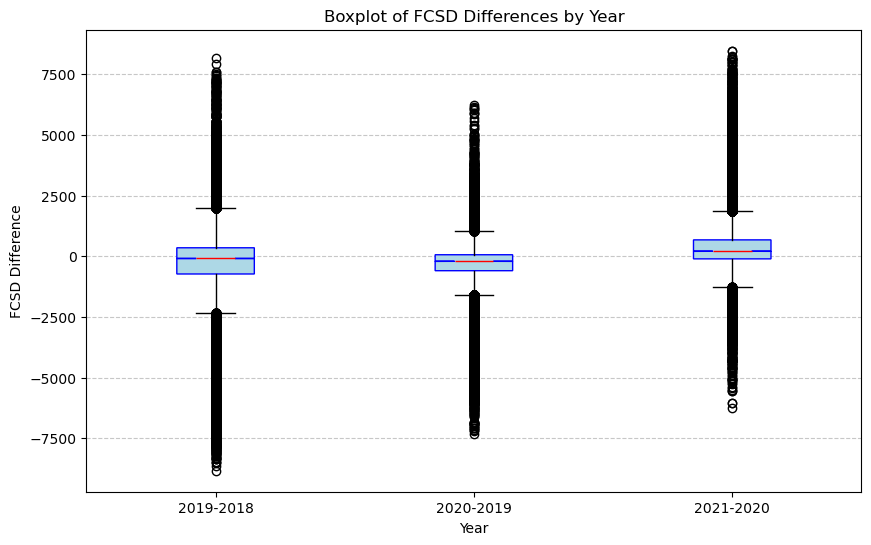

In [15]:
# Convert differences to Pandas DataFrame for easy plotting
data = {
    '2019-2018': diff_2019_2018.values.flatten(),
    '2020-2019': diff_2020_2019.values.flatten(),
    '2021-2020': diff_2021_2020.values.flatten(),
}

# Remove NaN values and divide values by 100
data = {year: values[~pd.isnull(values)] / 100 for year, values in data.items()}

# Convert dictionary to long-form format for Seaborn
long_data = []
for year, values in data.items():
    long_data.extend([(year, val) for val in values])

# Create a Pandas DataFrame from the long-form data
df = pd.DataFrame(long_data, columns=["Year", "FCSD Difference"])

# Plot settings
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("deep")

# Create scatter plot first with lower zorder
sns.stripplot(
    data=df, x="Year", y="FCSD Difference",
    jitter=True, size=4, color="lightgray", alpha=0.6, zorder=1
)

# Overlay boxplot without outlier dots
sns.boxplot(
    data=df, x="Year", y="FCSD Difference", palette=palette, notch=True, #showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    flierprops={"marker": ""},  # Removes outlier dots
    zorder=2
)

# Add a horizontal red dashed line at value 2500
plt.axhline(y=25, color='red', linestyle='--', linewidth=1.5, label='Threshold = 25')

# Add grid, labels, legend, and title
#plt.title("Enhanced Boxplot of FCSD Differences by Year", fontsize=16, weight="bold")
plt.ylabel("Difference of FCSD [%]", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

Check how many pixels are true in each the non-stand-replacing and stand-replacing masks aswell as in both masks... Plot a stacked histogram ...

In [15]:
'''# Select the subarea using .isel
d = d.isel(x=slice(52000, 53000), y=slice(52000, 53000))'''

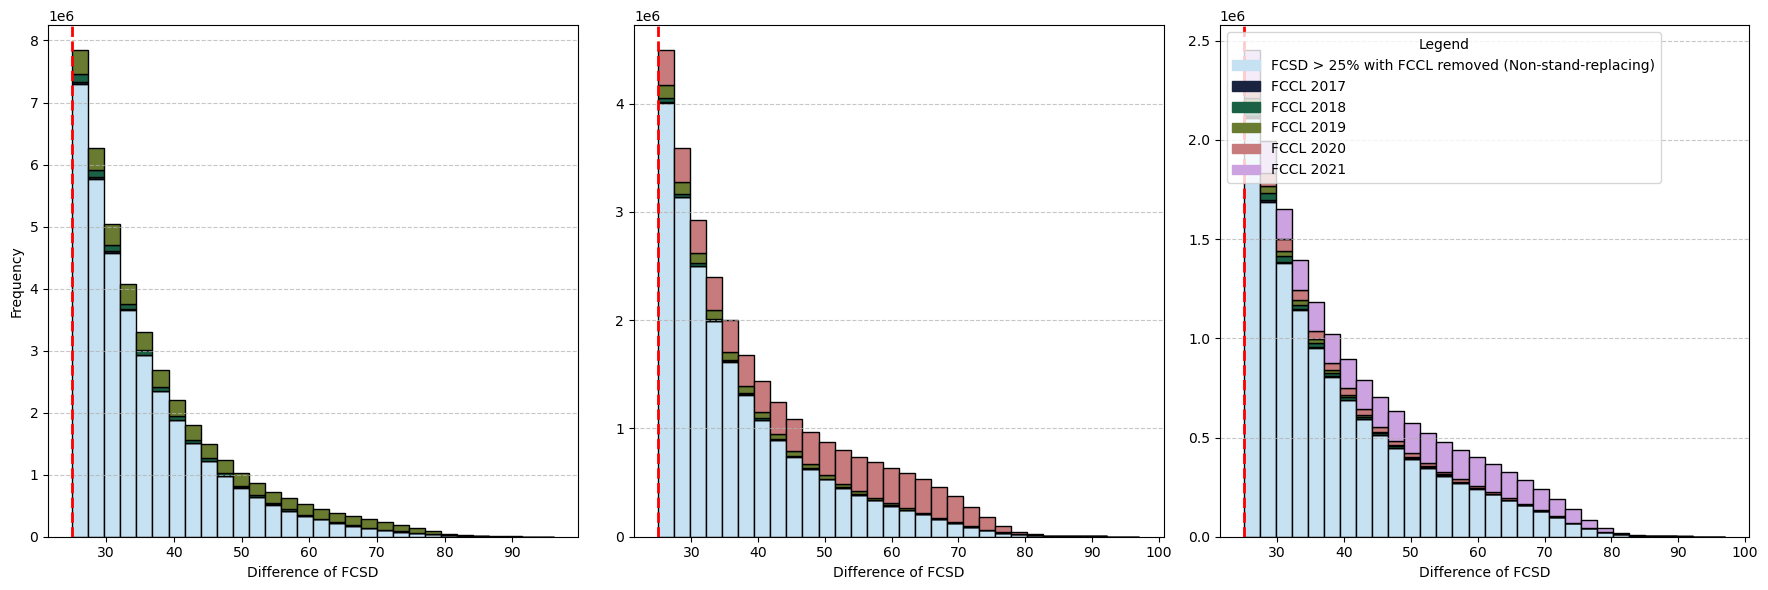

In [21]:
# Define years
years = ["2019", "2020", "2021"]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ensure enough colors (one extra for non-stand-replacing pixels)
palette = sns.color_palette("cubehelix", n_colors=6)  
fccl_colors = palette[:5]  # Colors for FCCL 2017-2021
nonexpanded_color = palette[5]  # Color for FCSD > 25% with FCCL removed

# Compute FCSD differences
fcsd_differences = [
    ((d.fcsd.sel(time="2019").squeeze().drop_vars('time') - d.fcsd.sel(time="2018").squeeze().drop_vars('time')) / 100).compute(),
    ((d.fcsd.sel(time="2020").squeeze().drop_vars('time') - d.fcsd.sel(time="2019").squeeze().drop_vars('time')) / 100).compute(),
    ((d.fcsd.sel(time="2021").squeeze().drop_vars('time') - d.fcsd.sel(time="2020").squeeze().drop_vars('time')) / 100).compute(),
]

# Compute masks for non-stand-replacing disturbances
nonexpanded_masks = [
    fcsd_diff_gt25_2019_nonexpanded.compute(),
    fcsd_diff_gt25_2020_nonexpanded.compute(),
    fcsd_diff_gt25_2021_nonexpanded.compute(),
]

# Compute FCCL masks (2017-2021)
fccl_masks = [
    fccl_mask_2017.compute(),
    fccl_mask_2018.compute(),
    fccl_mask_2019.compute(),
    fccl_mask_2020.compute(),
    fccl_mask_2021.compute(),
]

# Iterate over each year and plot histogram
for i, (ax, year, diff, mask) in enumerate(zip(axes, years, fcsd_differences, nonexpanded_masks)):
    diff_flat = diff.values.flatten()  # Flatten difference array
    mask_flat = mask.values.flatten()  # Flatten mask array

    # All pixels where FCSD difference > 25
    nonexpanded_pixels = diff_flat[(diff_flat > 25) & mask_flat]

    # Dynamically select FCCL years based on the subplot index
    relevant_fccl_masks = fccl_masks[: i + 3]  # 2017-2019 (i=0), 2017-2020 (i=1), 2017-2021 (i=2)
    fccl_pixel_stacks = [diff_flat[(diff_flat > 25) & fccl.values.flatten()] for fccl in relevant_fccl_masks]
    color_stacks = [nonexpanded_color] + fccl_colors[: len(relevant_fccl_masks)]

    # Plot histogram with stacked bars
    ax.hist(
        [nonexpanded_pixels] + fccl_pixel_stacks,  
        bins=30, stacked=True,
        color=color_stacks,
        edgecolor="black",
        label=None  # Suppress labels in individual plots
    )

    # Add threshold line
    ax.axvline(25, color='red', linestyle='--', linewidth=2)

    # Labels and formatting
    ax.set_xlabel(f"Difference of FCSD")
    ax.set_ylabel("Frequency" if i == 0 else "")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Create a single legend in the rightmost plot
legend_labels = [
    "FCSD > 25% with FCCL removed (Non-stand-replacing)",
    "FCCL 2017", "FCCL 2018", "FCCL 2019", "FCCL 2020", "FCCL 2021"
]
axes[2].legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in [nonexpanded_color] + fccl_colors[:5]], 
                labels=legend_labels, loc='upper left', title="Legend")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [7]:
'''# Count True pixels in the first mask (fccl_mask_2019)
fccl_mask_2019_count = fccl_mask_2019_nonexpanded.sum().compute().item()

# Count True pixels in the second mask (fcsd_diff_gt25_2019)
fcsd_diff_gt25_2019_count = fcsd_diff_gt25_2019_nonexpanded.sum().compute().item()

# Count True pixels in both masks (intersection)
both_masks_count = ((fccl_mask_2019_nonexpanded & fcsd_diff_gt25_2019_nonexpanded).sum().compute().item())

# Print the results
print(f"Pixels in fccl_mask_2019: {fccl_mask_2019_count}")
print(f"Pixels in fcsd_diff_gt25_2019: {fcsd_diff_gt25_2019_count}")
print(f"Pixels in both masks: {both_masks_count}")'''

Pixels in fccl_mask_2019: 16067122
Pixels in fcsd_diff_gt25_2019: 22312938
Pixels in both masks: 0


In [9]:
gc.collect()

11629

Now calculate boxplots of forest structure for the FCSD mask...

In [9]:
## create mask for NO DISTURBANCES i.e. NO non-stand-replacing and NO stand-replacing changes
years = pd.date_range('2017', '2024', freq='YE')

no_fcsd_diff_2019_2018 = (d.fcsd.sel(time='2019').squeeze().drop_vars('time') - d.fcsd.sel(time='2018').squeeze().drop_vars('time')) <= 2500
no_fcsd_diff_2020_2019 = (d.fcsd.sel(time='2020').squeeze().drop_vars('time') - d.fcsd.sel(time='2019').squeeze().drop_vars('time')) <= 2500
no_fcsd_diff_2021_2020 = (d.fcsd.sel(time='2021').squeeze().drop_vars('time') - d.fcsd.sel(time='2020').squeeze().drop_vars('time')) <= 2500

no_dist_combined = (no_fcsd_diff_2019_2018 | no_fcsd_diff_2020_2019 | no_fcsd_diff_2021_2020) & (d.fccl.all('time') == 0)
no_dist_combined = expand_years(no_dist_combined)
no_dist_combined

d = d.assign(no_dist_combined=no_dist_combined)

In [136]:
# create masks for years 2019-2021, 2020-2019 or 2021-2020
years = pd.date_range('2017', '2024', freq='YE')

# Combine the conditions
# mask for stand-rep disturbances
fccl_mask_2017 = (d.fccl.sel(time="2017") > 0).squeeze().drop_vars('time')
fccl_mask_2018 = (d.fccl.sel(time="2018") > 0).squeeze().drop_vars('time')
fccl_mask_2019 = (d.fccl.sel(time="2019") > 0).squeeze().drop_vars('time')
fccl_mask_2020 = (d.fccl.sel(time="2020") > 0).squeeze().drop_vars('time')
fccl_mask_2021 = (d.fccl.sel(time="2021") > 0).squeeze().drop_vars('time')

# mask for non-stand-rep disturbances in 2019
fccl_mask_2017_2019 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019
fcsd_diff_gt25_2019_nonexpanded = (
    ((d.fcsd.sel(time='2019').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2018').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2019
)

# mask for non-stand-rep disturbances in 2020
fccl_mask_2017_2020 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019 | fccl_mask_2020
fcsd_diff_gt25_2020_nonexpanded = (
    ((d.fcsd.sel(time='2020').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2019').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2020
)

# mask for non-stand-rep disturbances in 2019
fccl_mask_2017_2021 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019 | fccl_mask_2020 | fccl_mask_2021
fcsd_diff_gt25_2021_nonexpanded = (
    ((d.fcsd.sel(time='2021').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2020').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2021
)

# expand years
fcsd_diff_gt25_2019 = expand_years(fcsd_diff_gt25_2019_nonexpanded)
fcsd_diff_gt25_2020 = expand_years(fcsd_diff_gt25_2020_nonexpanded)
fcsd_diff_gt25_2021 = expand_years(fcsd_diff_gt25_2021_nonexpanded)

d = d.assign(fcsd_diff_gt25_2019=fcsd_diff_gt25_2019)
d = d.assign(fcsd_diff_gt25_2020=fcsd_diff_gt25_2020)
d = d.assign(fcsd_diff_gt25_2021=fcsd_diff_gt25_2021)

In [ ]:
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

# Compute statistics for 2018
stats_dict = {
    name: {
        #'fcsd_diff_gt25_2019': compute_descriptive_statistics(data, mask=d.fcsd_diff_gt25_2019),
        #'fcsd_diff_gt25_2020': compute_descriptive_statistics(data, mask=d.fcsd_diff_gt25_2020),
        'fcsd_diff_gt25_2021': compute_descriptive_statistics(data, mask=d.fcsd_diff_gt25_2021),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [ ]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/fcsd_diff_gt25_2021.csv", index=False)
stats_df

In [ ]:
# get number of samples for each mask
num_pixels_fcsd_2019 = fcsd_diff_gt25_2019_nonexpanded.sum().compute().item()
num_pixels_fcsd_2020 = fcsd_diff_gt25_2020_nonexpanded.sum().compute().item()
num_pixels_fcsd_2021 = fcsd_diff_gt25_2021_nonexpanded.sum().compute().item()

print(f"Number of pixels with non-stand replacing in 2019: {num_pixels_fcsd_2019}")
print(f"Number of pixels with non-stand replacing in 2020: {num_pixels_fcsd_2020}")
print(f"Number of pixels with non-stand replacing 2021: {num_pixels_fcsd_2021}")

In [ ]:
# get number of samples for no disturbance
no_dist_combined = (~num_pixels_fcsd_2019 | ~num_pixels_fcsd_2020 | ~num_pixels_fcsd_2021) & (d.fccl.all('time') == 0)

num_pixels_no_dist_combined = no_dist_combined.sum().compute().item()
print(f"Number of pixels with no dist: {num_pixels_no_dist_combined}")

# Further analysis on stand-replacing and non-stand-replacing disturbances

In [5]:
'''# get further information on whether stand-replacing disturbances before were non-stand replacing disturbances
# only for year 2020

# Compute the masks to check what happened with stand-replacing pixels before
fccl_mask_2020 = (d.fccl.sel(time="2020") > 0).squeeze().drop_vars('time')
fcsd_diff_2019_2018 = (d.fcsd.sel(time='2019').squeeze().drop_vars('time') - 
                        d.fcsd.sel(time='2018').squeeze().drop_vars('time')) >= 2500.

# Define the two conditions
mask_combined = fccl_mask_2020 & fcsd_diff_2019_2018  # Pixels where both are True
mask_fccl_only = fccl_mask_2020 & ~fcsd_diff_2019_2018  # Pixels where only fccl_mask_2020 is True

# Convert boolean masks to integers (0 and 1) for saving as TIFF
mask_combined = mask_combined.astype(np.uint8)
mask_fccl_only = mask_fccl_only.astype(np.uint8)

# Write to GeoTIFF
output_path_combined = "./data/mask_non_stand_rep_2019_stand_rep_2020.tif"
output_path_fccl_only = "./data/mask_only_stand_rep_2020.tif"

mask_combined.rio.to_raster(output_path_combined, compress="deflate")
mask_fccl_only.rio.to_raster(output_path_fccl_only, compress="deflate")

print("Masks saved successfully!")'''

Masks saved successfully!


In [7]:
# Compute the masks to check what happens with non-stand-replacing pixels afterwards

# mask for stand-rep disturbances
fccl_mask_2017 = (d.fccl.sel(time="2017") > 0).squeeze().drop_vars('time')
fccl_mask_2018 = (d.fccl.sel(time="2018") > 0).squeeze().drop_vars('time')
fccl_mask_2019 = (d.fccl.sel(time="2019") > 0).squeeze().drop_vars('time')
fccl_mask_2020 = (d.fccl.sel(time="2020") > 0).squeeze().drop_vars('time')
fccl_mask_2021 = (d.fccl.sel(time="2021") > 0).squeeze().drop_vars('time')

# Combine all fccl masks for 2017-2020 using logical OR
fccl_mask_2017_2020 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019 | fccl_mask_2020

# mask for non-stand-rep disturbances in 2020
fcsd_diff_gt25_2020_nonexpanded = (
    ((d.fcsd.sel(time='2020').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2019').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2020
)

print(fcsd_diff_gt25_2020_nonexpanded.sum().compute().item())

20887644


In [10]:
# Define two conditions
mask_combined_2021 = fcsd_diff_gt25_2020_nonexpanded & fccl_mask_2021  # Pixels where both are True
print(mask_combined_2021.sum().compute().item())
mask_fcsd_only_2021 = fcsd_diff_gt25_2020_nonexpanded & ~fccl_mask_2021  # Pixels where only fcsd_diff_gt25_2020_nonexpanded is True
print(mask_fcsd_only_2021.sum().compute().item())

2509472
18378172


In [8]:
years = range(2017, 2024)  # From 2017 to 2023

for year in years:
    fccl_mask = (d.fccl.sel(time=str(year)) > 0).squeeze().drop_vars('time')  # Mask for fccl presence in that year
    count = (fcsd_diff_gt25_2020_nonexpanded & fccl_mask).sum().compute().item()  # Count overlapping pixels
    print(f"Pixels with fccl in {year}: {count}")

Pixels with fccl in 2017: 0
Pixels with fccl in 2018: 0
Pixels with fccl in 2019: 0
Pixels with fccl in 2020: 0
Pixels with fccl in 2021: 2509472
Pixels with fccl in 2022: 720130
Pixels with fccl in 2023: 306424


In [11]:
# Convert boolean masks to integers (0 and 1) for saving as TIFF
mask_combined_2021 = mask_combined_2021.astype(np.uint8)
mask_fcsd_only_2021 = mask_fcsd_only_2021.astype(np.uint8)

# Write to GeoTIFF
output_path_combined_2021 = "./data/mask_non_stand_rep_2020_stand_rep_2021.tif"
output_path_fcsd_only_2021 = "./data/mask_non_stand_rep_2020_only.tif"

mask_combined_2021.rio.to_raster(output_path_combined_2021, compress="deflate")
mask_fcsd_only_2021.rio.to_raster(output_path_fcsd_only_2021, compress="deflate")

print("Masks saved successfully!")

Masks saved successfully!


In [ ]:
# read ts mask layer mask_non_stand_rep_2020_stand_rep_2021
mask_path = "./data/mask_non_stand_rep_2020_stand_rep_2021.tif"
mask = rxr.open_rasterio(mask_path, masked=True, chunks='auto').squeeze()
mask = mask.rio.write_crs("EPSG:3035")

# load the masks
# only one at a time, otherwise RAM explodes !!!
years = pd.date_range('2017', '2024', freq='YE')
mask = expand_years((mask == 1).squeeze())

# Add the time-specific mask to dataset
d = d.assign(temp=mask)

# calculate statistics for 2020
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {
    name: {
        'mask_non_stand_rep_2020_stand_rep_2021': compute_descriptive_statistics(data, mask=d.temp),
        'Dataset': name
    }
    for name, data in datasets.items()
}

# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_germany_mask_non_stand_rep_2020_stand_rep_2021_allpixels.csv", index=False)
stats_df

In [5]:
# read ts mask layer mask_non_stand_rep_2020_only
mask_path = "./data/mask_non_stand_rep_2020_only.tif"
mask = rxr.open_rasterio(mask_path, masked=True, chunks='auto').squeeze()
mask = mask.rio.write_crs("EPSG:3035")

# load the masks
# only one at a time, otherwise RAM explodes !!!
years = pd.date_range('2017', '2024', freq='YE')
mask = expand_years((mask == 1).squeeze())

# Add the time-specific mask to dataset
d = d.assign(temp=mask)

# calculate statistics for 2020
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {
    name: {
        'mask_non_stand_rep_2020_only.tif': compute_descriptive_statistics(data, mask=d.temp),
        'Dataset': name
    }
    for name, data in datasets.items()
}

# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_germany_mask_non_stand_rep_2020_only_allpixels.csv", index=False)
stats_df

/dss/dsshome1/09/di38set/micromamba/envs/forenv/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,mask_non_stand_rep_2020_only.tif,192.024353,184.766220,182.718094,173.615234,155.915298,149.162140,152.134796,194.0,...,247.5,287.0,253.5,312.0,323.0,299.0,274.0,277.0,276.0,259.0
1,TCC,mask_non_stand_rep_2020_only.tif,56.415329,56.453045,55.932877,53.745159,47.554440,49.814835,52.062492,58.0,...,82.5,87.0,83.5,79.0,83.0,86.0,83.0,83.0,83.0,84.0
2,FHDI,mask_non_stand_rep_2020_only.tif,273.902191,284.285522,282.912140,281.118469,268.693512,274.544495,273.531555,281.0,...,323.5,337.5,337.0,206.0,212.0,213.0,211.0,216.0,221.0,211.0
3,CH,mask_non_stand_rep_2020_only.tif,22.959820,21.783764,21.785891,21.596308,19.569778,18.855597,19.963755,24.0,...,28.0,29.5,26.5,30.0,29.0,31.0,30.0,30.0,29.0,28.0
4,FCSD,mask_non_stand_rep_2020_only.tif,NaN,2172.805664,1812.659790,5362.180176,2648.805176,NaN,NaN,NaN,...,6428.5,NaN,NaN,NaN,9824.0,7177.0,7280.0,9753.0,NaN,NaN


In [ ]:
'''# read ts mask layer mask_non_stand_rep_2020_stand_rep_2021
mask_non_stand_rep_2020_stand_rep_2021_path = "./data/mask_non_stand_rep_2020_stand_rep_2021.tif"
mask_non_stand_rep_2020_stand_rep_2021 = rxr.open_rasterio(mask_non_stand_rep_2020_stand_rep_2021_path, masked=True, chunks='auto').squeeze()
mask_non_stand_rep_2020_stand_rep_2021 = mask_non_stand_rep_2020_stand_rep_2021.rio.write_crs("EPSG:3035")
mask_non_stand_rep_2020_stand_rep_2021 = (mask_non_stand_rep_2020_stand_rep_2021 == 1).squeeze()

num_mask_non_stand_rep_2020_stand_rep_2021 = (mask_non_stand_rep_2020_stand_rep_2021 == 1).squeeze().sum().compute().item()
print(f"Number of pixels non-stand replacing disturbance in 2020 and stand-replacing disturbance in 2021: {num_mask_non_stand_rep_2020_stand_rep_2021}")'''

In [ ]:
'''# read ts mask layer mask_non_stand_rep_2020_stand_rep_2021
mask_non_stand_rep_2020_only_path = "./data/mask_only_stand_rep_2020.tif"
mask_non_stand_rep_2020_only = rxr.open_rasterio(mask_non_stand_rep_2020_only_path, masked=True, chunks='auto').squeeze()
mask_non_stand_rep_2020_only = mask_non_stand_rep_2020_only.rio.write_crs("EPSG:3035")
mask_non_stand_rep_2020_only = (mask_non_stand_rep_2020_only == 1).squeeze()

num_mask_non_stand_rep_2020_only = (mask_non_stand_rep_2020_only == 1).squeeze().sum().compute().item()
print(f"Number of pixels non-stand replacing disturbance in 2020 and recovery in 2021: {num_mask_non_stand_rep_2020_only}")'''

# Characteristics of Forest Structure for different Change Agents

In [23]:
# read aggregated change agent layer
ca_path = "./data/reproj/final/disturbance_agent_aggregated_germany_epsg3035.tif"
ca = rxr.open_rasterio(ca_path, masked=True, chunks='auto').squeeze()
ca = ca.rio.write_crs("EPSG:3035")

In [24]:
# select pixels based on change agent, ONLY IN FCCL AREAS BY THONFELD ET AL
# add the yearly change agent layers to d

change_agents = {
    "wind_bb": 1,
    "fire": 2,
    "harvest": 3,
    "mixed": 4,
}

# Initialize a dictionary to store yearly overlaps for each change agent
overlap_data = {}

# Loop over each change agent
for agent_name, agent_value in change_agents.items():
    agent_overlap_list = []
    agent_mask = (ca == agent_value).squeeze()  # Create a mask for the current change agent

    # Iterate over each year in the dataset
    for year in d.time.values:
        fccl_mask = (d.fccl.sel(time=year) > 0).squeeze()  # Extract fccl > 0 for the current year
        year_mask = xr.where((fccl_mask & agent_mask), 1, 0)  # Compute the overlap
        year_mask = year_mask.assign_coords(time=year)  # Assign time dimension
        agent_overlap_list.append(year_mask)

    # Combine all yearly masks into a single DataArray
    agent_overlap = xr.concat(agent_overlap_list, dim='time')
    agent_overlap.name = f"{agent_name}_fccl_overlap"
    overlap_data[agent_name] = agent_overlap

    # Add the new variable to the dataset
    d = d.assign(**{f"ca_{agent_name}": agent_overlap})


In [25]:
d

<xarray.Dataset>
Dimensions:               (x: 69419, y: 87752, time: 7)
Coordinates:
    band                  int64 1
  * x                     (x) float64 4.008e+06 4.008e+06 ... 4.702e+06
  * y                     (y) float64 3.562e+06 3.562e+06 ... 2.684e+06
    spatial_ref           int64 0
  * time                  (time) datetime64[ns] 2017-12-31 ... 2023-12-31
Data variables:
    agbd                  (time, y, x) float32 dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    cover                 (time, y, x) float32 dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    fhd_normal            (time, y, x) float32 dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    rh_95                 (time, y, x) float32 dask.array<chunksize=(1, 966, 69419), meta=np.ndarray>
    fccl                  (time, y, x) float64 dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
    fcsd                  (time, y, x) float32 dask.array<chunksize=(2, 966, 69419), meta=np.ndarray>
    small_dist_2020_mask  (y, x, time) bool dask.array<chunksize=(483, 69419, 7), meta=np.ndarray>
    large_dist_2020_mask  (y, x, time) bool dask.array<chunksize=(483, 69419, 7), meta=np.ndarray>
    ca_wind_bb            (time, y, x) int64 dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
    ca_fire               (time, y, x) int64 dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
    ca_harvest            (time, y, x) int64 dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
    ca_mixed              (time, y, x) int64 dask.array<chunksize=(1, 483, 69419), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [27]:
# Calculate yearly area lost in hectares for each change agent
area_lost_ha = {}
pixel_area_ha = 0.01  # Each pixel represents 0.01 ha

for agent_name, agent_overlap in overlap_data.items():
    # Sum over spatial dimensions and convert to hectares
    area_lost_ha[agent_name] = (agent_overlap.sum(dim=["x", "y"]) * pixel_area_ha)

In [28]:
# Convert area lost data to a DataFrame for plotting
area_lost_ha_df = pd.DataFrame({
    agent_name: area_lost_ha[agent_name].values for agent_name in change_agents.keys()
}, index=d.time.dt.year)

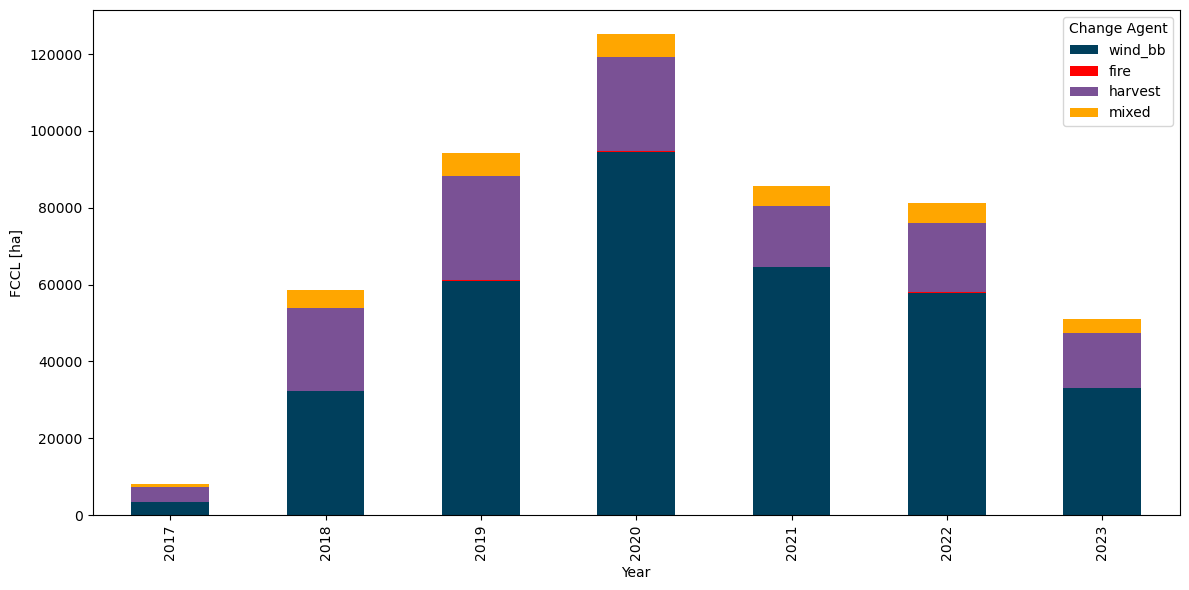

In [34]:
# Define specific colors for each change agent
colors = {
    "wind_bb": "#003f5c",
    "fire": "red",
    "harvest": "#7a5195",
    "mixed": "#ffa600"
}

# Plot the stacked bar chart with specific colors
ax = area_lost_ha_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12, 6), 
    color=[colors[agent] for agent in area_lost_ha_df.columns]
)
ax.set_xlabel("Year")
ax.set_ylabel("FCCL [ha]")
plt.legend(title="Change Agent")
plt.tight_layout()
plt.show()

In [36]:
# print losses by fire
fire_loss = area_lost_ha_df["fire"]

print("Yearly Area Lost by Fire (in ha):")
print(fire_loss)

Yearly Area Lost by Fire (in ha):
2017     25.96
2018     75.46
2019    379.83
2020    107.41
2021     20.11
2022    235.29
2023     92.54
Name: fire, dtype: float64


check how many fccl pixels are covered with the change agent layer

In [41]:
total_loss_ha = area_lost_ha_df.sum(axis=1)
cumulative_total_loss_ha = total_loss_ha.cumsum()
print(f"Total Cumulative Loss of Area (in ha): {cumulative_total_loss_ha.iloc[-1]:.2f}")

Total Cumulative Loss of Area (in ha): 504159.32


In [42]:
# Calculate yearly FCCL area in hectares
pixel_area_ha = 0.01  # Each pixel represents 0.01 ha
yearly_fccl_area = []

for year in d.time.values:
    # Extract FCCL data for the year
    yearly_fccl = d.fccl.sel(time=year)
    
    # Count valid pixels (fccl > 0) and multiply by pixel area
    valid_pixel_count = xr.where(yearly_fccl > 0, 1, 0).sum(dim=["x", "y"])
    yearly_fccl_area.append(valid_pixel_count * pixel_area_ha)

In [44]:
# Compute cumulative FCCL area
cumulative_fccl_area = xr.concat(yearly_fccl_area, dim="time").cumsum(dim="time")
cumulative_fccl_area.name = "cumulative_fccl_area"
# Print total cumulative FCCL
print(f"Total Cumulative FCCL Area (in ha): {cumulative_fccl_area[-1].values:.2f}")

Total Cumulative FCCL Area (in ha): 866729.92


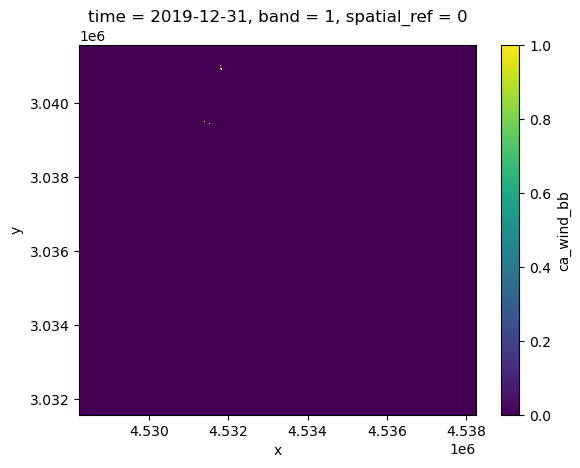

In [40]:
d.ca_wind_bb.sel(time="2019").isel(x=slice(52000,53000),y=slice(52000,53000)).plot()

Calculate descriptive statistics for year 2019

In [7]:
ca_mixed_2019 = expand_years((d.ca_mixed.sel(time="2019") == 1).squeeze().drop_vars('time'))
ca_mixed_2019

<xarray.DataArray 'ca_mixed' (y: 87752, x: 69419, time: 7)> Size: 43GB
dask.array<repeat, shape=(87752, 69419, 7), dtype=bool, chunksize=(483, 69419, 7), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 555kB 4.008e+06 4.008e+06 ... 4.702e+06 4.702e+06
  * y            (y) float64 702kB 3.562e+06 3.562e+06 ... 2.684e+06 2.684e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 56B 2017-12-31 2018-12-31 ... 2023-12-31

In [ ]:
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

# Compute statistics for wind damage in the same year as the statistics of the forest structure
stats_dict = {
    name: {
        'ca_mixed_2019': compute_descriptive_statistics(data, mask=ca_mixed_2019),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [ ]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_german_ca_mixed_2019_allpixels.csv", index=False)
stats_df

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
dataset_names = ['AGBD', 'TCC', 'FHDI', 'CH', 'FCSD']
mask_type = 'ca_mixed_2019'

# Iterate over datasets to fill each subplot
for col, dataset_name in enumerate(dataset_names):
    ax = axes[col]
    plot_statistics_df(ax, years, dataset_name, mask_type, stats_df, highlight_time=highlight_time)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [18]:
# get number of samples for each mask

ca_wind_bb_2020_nonexpanded = d.ca_wind_bb.sel(time="2020") == 1
ca_fire_2020_nonexpanded = d.ca_fire.sel(time="2020") == 1
ca_harvest_2020_nonexpanded = d.ca_harvest.sel(time="2020") == 1

num_pixels_ca_wind_bb_2020 = ca_wind_bb_2020_nonexpanded.sum().compute().item()
num_pixels_ca_fire_2020 = ca_fire_2020_nonexpanded.sum().compute().item()
num_pixels_ca_harvest_2020 = ca_harvest_2020_nonexpanded.sum().compute().item()

print(f"Number of pixels with ca wind/bb in 2020: {num_pixels_ca_wind_bb_2020}")
print(f"Number of pixels with ca fire in 2020: {num_pixels_ca_fire_2020}")
print(f"Number of pixels with ca harvest in 2020: {num_pixels_ca_harvest_2020}")

Number of pixels with ca wind/bb in 2020: 9457289
Number of pixels with ca fire in 2020: 10741
Number of pixels with ca harvest in 2020: 2446302


Check for the average month of FCCL for the different change agents...

In [27]:
# calculate the mean of fccl where large_dist_2020_mask is true
mean_fccl_wind_bb_dist = d.fccl.sel(time="2020").where(d.ca_wind_bb.sel(time="2020") == 1).mean()
mean_fccl_fire_dist = d.fccl.sel(time="2020").where(d.ca_fire.sel(time="2020") == 1).mean()
mean_fccl_harvest_dist = d.fccl.sel(time="2020").where(d.ca_harvest.sel(time="2020") == 1).mean()

# Now you can access the calculated means
print("Mean of fccl where wind_bb is true:", mean_fccl_wind_bb_dist.values)
print("Mean of fccl where fire is true:", mean_fccl_fire_dist.values)
print("Mean of fccl where harvest is true:", mean_fccl_harvest_dist.values)

Mean of fccl where wind_bb is true: 34.14255131676742
Mean of fccl where fire is true: 32.28461037147379
Mean of fccl where harvest is true: 33.22078467826131


# Histogram of differences of forest structure between 2023 and 2017 for FCCL areas (and FCSD > 25% areas)

Try plotting a histogram...

In [13]:
## for stand-replacing changes, i.e. FCCL areas
## Exemplary: CH
fccl_mask_combined = (d.fccl > 0).any(dim='time').compute()
rh_95_diff = d.rh_95.sel(time="2023").squeeze().drop_vars('time') - d.rh_95.sel(time="2017").squeeze().drop_vars('time')
rh_95_diff_masked = rh_95_diff.where(fccl_mask_combined, drop=True)
rh_95_diff_values = rh_95_diff_masked.values.flatten()
valid_values = rh_95_diff_values[~np.isnan(rh_95_diff_values)]

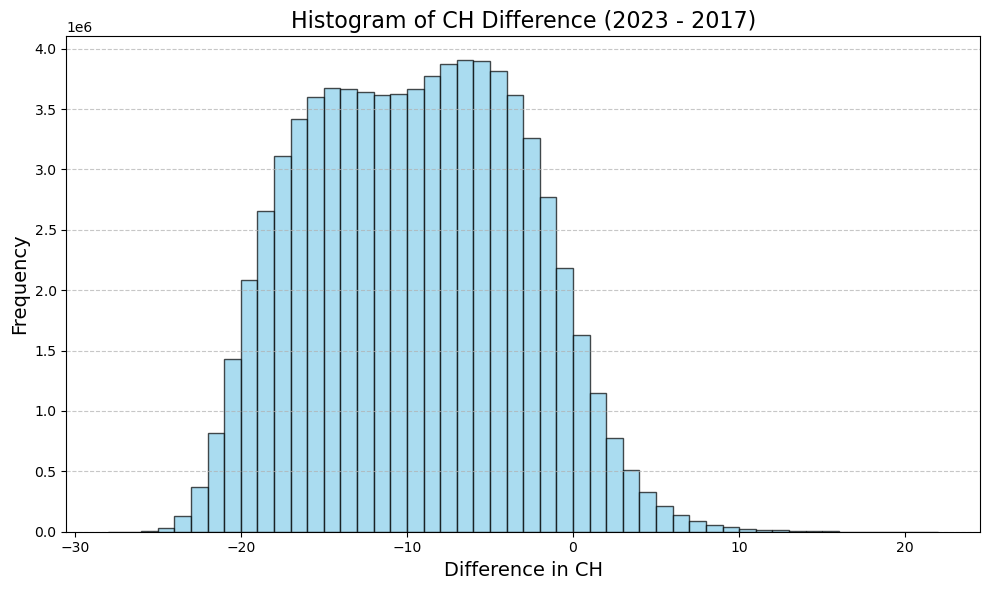

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(valid_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of CH Difference (2023 - 2017)", fontsize=16)
plt.xlabel("Difference in CH", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# test stacking by year
# Extract valid values for each year based on FCCL classification
yearly_values = {}
for year, (min_val, max_val) in value_ranges.items():
    yearly_mask = ((fccl >= min_val) & (fccl <= max_val)).compute()  # Compute the mask
    yearly_diff_masked = rh_95_diff.where(yearly_mask, drop=True)
    yearly_diff_values = yearly_diff_masked.values.flatten()
    yearly_values[year] = yearly_diff_values[~np.isnan(yearly_diff_values)]

# Calculate skewness for each year
skewness_values = {year: skew(values) for year, values in yearly_values.items()}

# Prepare data for the stacked histogram
stacked_data = [yearly_values[year] for year in yearly_values]
labels = [year for year in yearly_values]

<Figure size 1200x800 with 0 Axes>

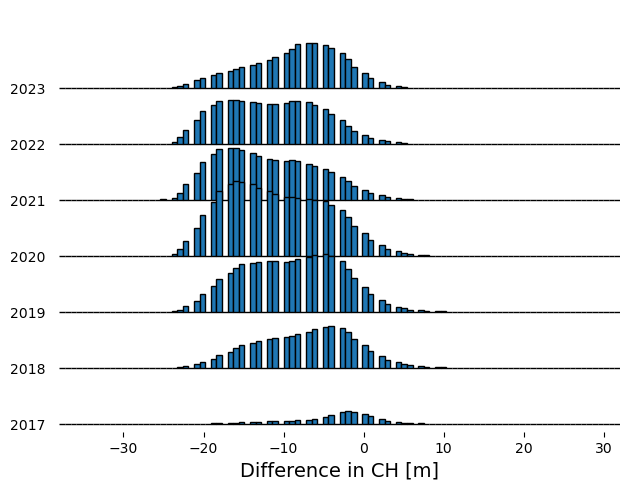

In [24]:
'''# Generate a discrete Cubehelix color palette
colors = sns.color_palette("cubehelix", n_colors=len(yearly_values))

# Prepare data: reverse order for proper stacking
data_sorted = {year: yearly_values[year] for year in sorted(yearly_values.keys(), reverse=True)}

# Create the ridgeline plot
plt.figure(figsize=(12, 8))
joyplot(
    data=data_sorted, 
    colormap=sns.color_palette("cubehelix", as_cmap=True), 
    linewidth=1, 
    overlap=0.6  # Adjust overlap for better visibility
)

plt.xlabel("Difference in CH [m]", fontsize=14)
plt.ylabel("Disturbance Year", fontsize=14)
#plt.title("Mountain Range Plot of CH Difference (2023 - 2017) by FCCL Year", fontsize=16)
plt.show()'''

# Generate a discrete Cubehelix color palette
colors = sns.color_palette("cubehelix", n_colors=len(yearly_values))

# Prepare data: reverse order for proper stacking
data_sorted = {year: yearly_values[year] for year in sorted(yearly_values.keys(), reverse=True)}

# Create the ridgeline plot using histograms for discrete data
plt.figure(figsize=(12, 8))
joyplot(
    data=data_sorted, 
    hist=True,  # Enables histogram-based ridgeline plots
    bins=100,  # Adjust number of bins for better resolution
    colormap=sns.color_palette("cubehelix", as_cmap=True), 
    overlap=0.5  # Adjust overlap to avoid excessive stacking
)

plt.xlabel("Difference in CH [m]", fontsize=14)
plt.ylabel("Disturbance Year", fontsize=14)
plt.show()

In [13]:
# Calculate skewness for each year
skewness_values = {year: skew(values) for year, values in yearly_values.items()}

-3.837988
-7.423253
-9.075662
-10.911158
-12.003402
-11.537673
-8.584238


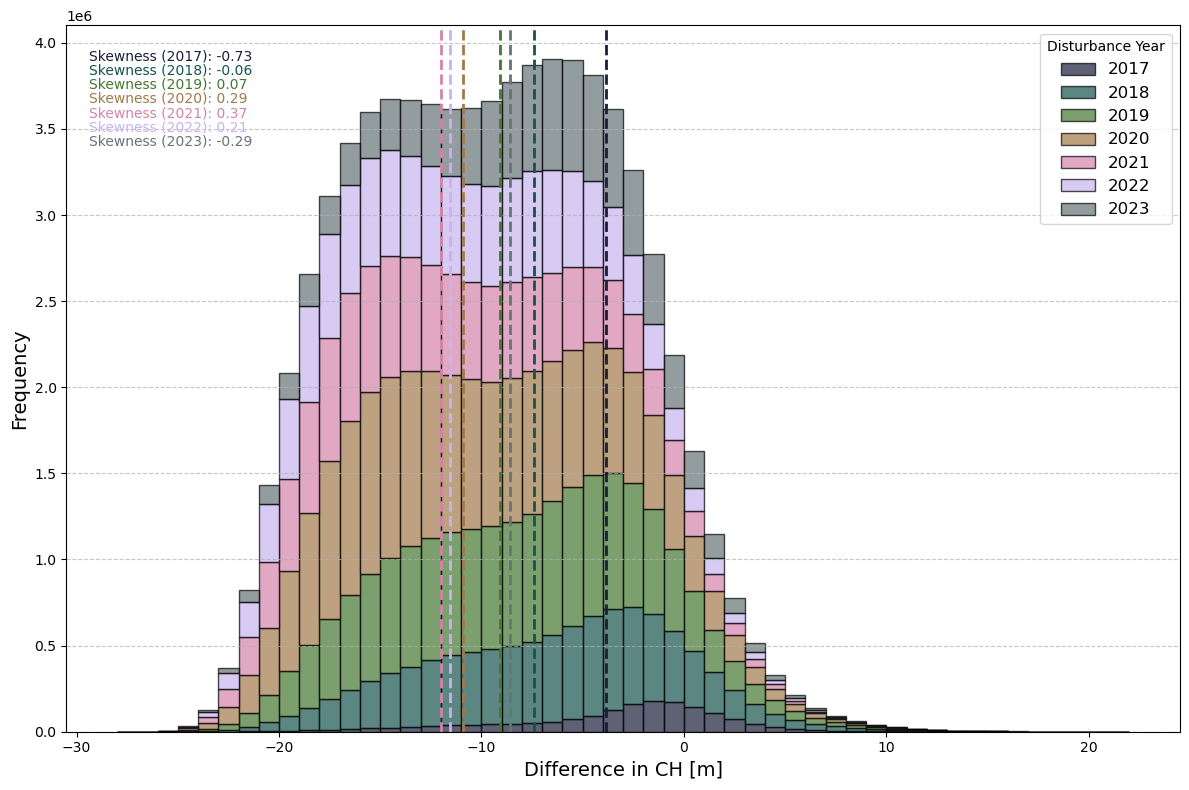

In [30]:
# Generate discrete Cubehelix color palette
colors = sns.color_palette("cubehelix", n_colors=7)
colors[6] = tuple(max(0, c * 0.5) for c in colors[6]) # darken last colour a bit

# Prepare data for the stacked histogram (keep 2017 at the bottom, 2023 at the top for stacking)
stacked_data = [yearly_values[year] for year in sorted(yearly_values.keys())]
labels = sorted(yearly_values.keys())
labels = labels[::-1]

# Plot the stacked histogram with the correct stacking order
plt.figure(figsize=(12, 8))
plt.hist(stacked_data, bins=50, stacked=True, label=labels, edgecolor='black', alpha=0.7, color=colors)
#plt.title("Stacked Histogram of CH Difference (2023 - 2017) by FCCL Year", fontsize=16)
plt.xlabel("Difference in CH [m]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Plot the means for each year as a vertical line
for i, label in enumerate(labels[::-1]):
    mean_value = np.mean(yearly_values[label])  # Calculate the mean for each year
    print(mean_value)
    plt.axvline(mean_value, color=colors[i], linestyle='--', linewidth=2)  # Add vertical line for mean

# Add skewness values to the plot for each year
for i, label in enumerate(labels[::-1]):
    plt.text(0.02, 0.95 - i * 0.02, f"Skewness ({label}): {skewness_values[label]:.2f}", 
             transform=plt.gca().transAxes, fontsize=10, color=colors[i])

# Reverse the legend order (2023 at the top and 2017 at the bottom)
plt.legend(title="Disturbance Year", fontsize=12, labels=labels[::-1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [70]:
## for non-stand-replacing changes, i.e. FCSD areas
## Exemplary: CH
# Create masks for year differences
fcsd_diff_2019_2018 = (d.fcsd.sel(time='2019').squeeze().drop_vars('time') - d.fcsd.sel(time='2018').squeeze().drop_vars('time')) > 2500
fcsd_diff_2020_2019 = (d.fcsd.sel(time='2020').squeeze().drop_vars('time') - d.fcsd.sel(time='2019').squeeze().drop_vars('time')) > 2500
fcsd_diff_2021_2020 = (d.fcsd.sel(time='2021').squeeze().drop_vars('time') - d.fcsd.sel(time='2020').squeeze().drop_vars('time')) > 2500

fcsd_diff_combined = (fcsd_diff_2019_2018 | fcsd_diff_2020_2019 | fcsd_diff_2021_2020) & (d.fccl.any('time') == 0)
fcsd_diff_combined = fcsd_diff_combined.compute()
fcsd_diff_combined

<xarray.DataArray (y: 87752, x: 69419)> Size: 6GB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 555kB 4.008e+06 4.008e+06 ... 4.702e+06 4.702e+06
  * y            (y) float64 702kB 3.562e+06 3.562e+06 ... 2.684e+06 2.684e+06
    spatial_ref  int64 8B 0

In [71]:
rh_95_diff = d.rh_95.sel(time="2021").squeeze().drop_vars('time') - d.rh_95.sel(time="2018").squeeze().drop_vars('time')
rh_95_diff_masked = rh_95_diff.where(fcsd_diff_combined, drop=True)
rh_95_diff_values = rh_95_diff_masked.values.flatten()
valid_values = rh_95_diff_values[~np.isnan(rh_95_diff_values)]

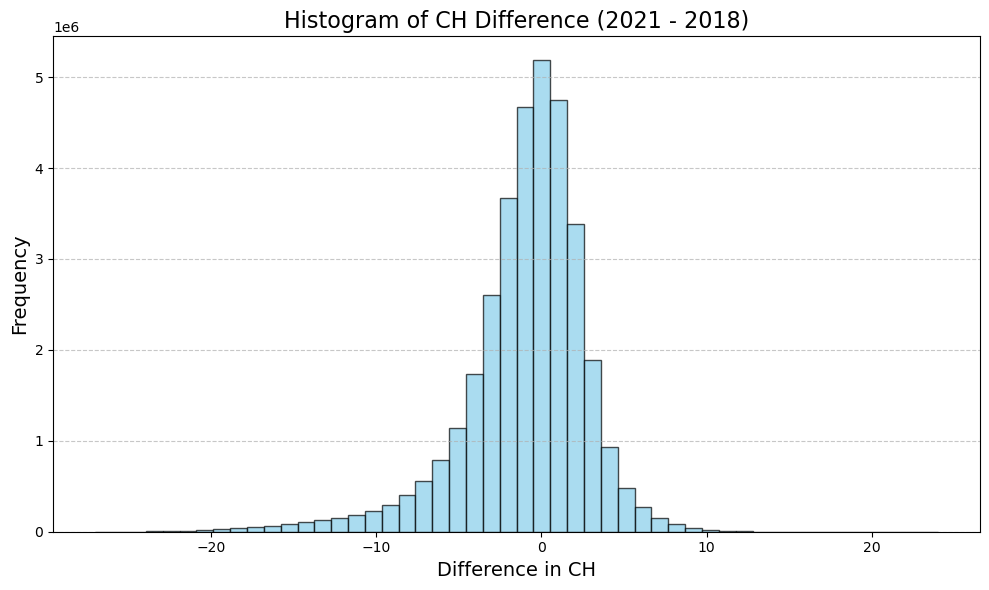

In [72]:
plt.figure(figsize=(10, 6))
plt.hist(valid_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of CH Difference (2021 - 2018)", fontsize=16)
plt.xlabel("Difference in CH", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the figure to a directory
#save_path = "./data/difference_2023_17_FCCL_gt0_histogram"
#plt.savefig(save_path, dpi=300, bbox_inches='tight')
#plt.show()

In [4]:
# Compute FCSD masks explicitly
fcsd_diff_2019_2018 = (
    (d.fcsd.sel(time="2019").squeeze().drop_vars("time") - d.fcsd.sel(time="2018").squeeze().drop_vars("time")) > 2500
).compute()
fcsd_diff_2020_2019 = (
    (d.fcsd.sel(time="2020").squeeze().drop_vars("time") - d.fcsd.sel(time="2019").squeeze().drop_vars("time")) > 2500
).compute()
fcsd_diff_2021_2020 = (
    (d.fcsd.sel(time="2021").squeeze().drop_vars("time") - d.fcsd.sel(time="2020").squeeze().drop_vars("time")) > 2500
).compute()

# Combine masks and compute
fcsd_diff_combined = ((fcsd_diff_2019_2018 | fcsd_diff_2020_2019 | fcsd_diff_2021_2020) & (d.fccl.any("time") == 0)).compute()

# Compute RH_95 differences
rh_95_diff = d.rh_95.sel(time="2021").squeeze().drop_vars("time") - d.rh_95.sel(time="2018").squeeze().drop_vars("time")
rh_95_diff_masked = rh_95_diff.where(fcsd_diff_combined, drop=True)

# Group RH_95 differences by FCSD masks
grouped_values = {
    "2019": rh_95_diff.where(fcsd_diff_2019_2018, drop=True).values.flatten(),
    "2020": rh_95_diff.where(fcsd_diff_2020_2019, drop=True).values.flatten(),
    "2021": rh_95_diff.where(fcsd_diff_2021_2020, drop=True).values.flatten(),
}

# Remove NaN values
grouped_values = {key: values[~np.isnan(values)] for key, values in grouped_values.items()}

# Calculate skewness for each group
skewness_values = {key: skew(values) for key, values in grouped_values.items()}

# Prepare data for stacked barplot
stacked_data = [grouped_values[key] for key in ["2019", "2020", "2021"]]
labels = ["2019", "2020", "2021"]

-3.984788
-7.2870216
-3.832558


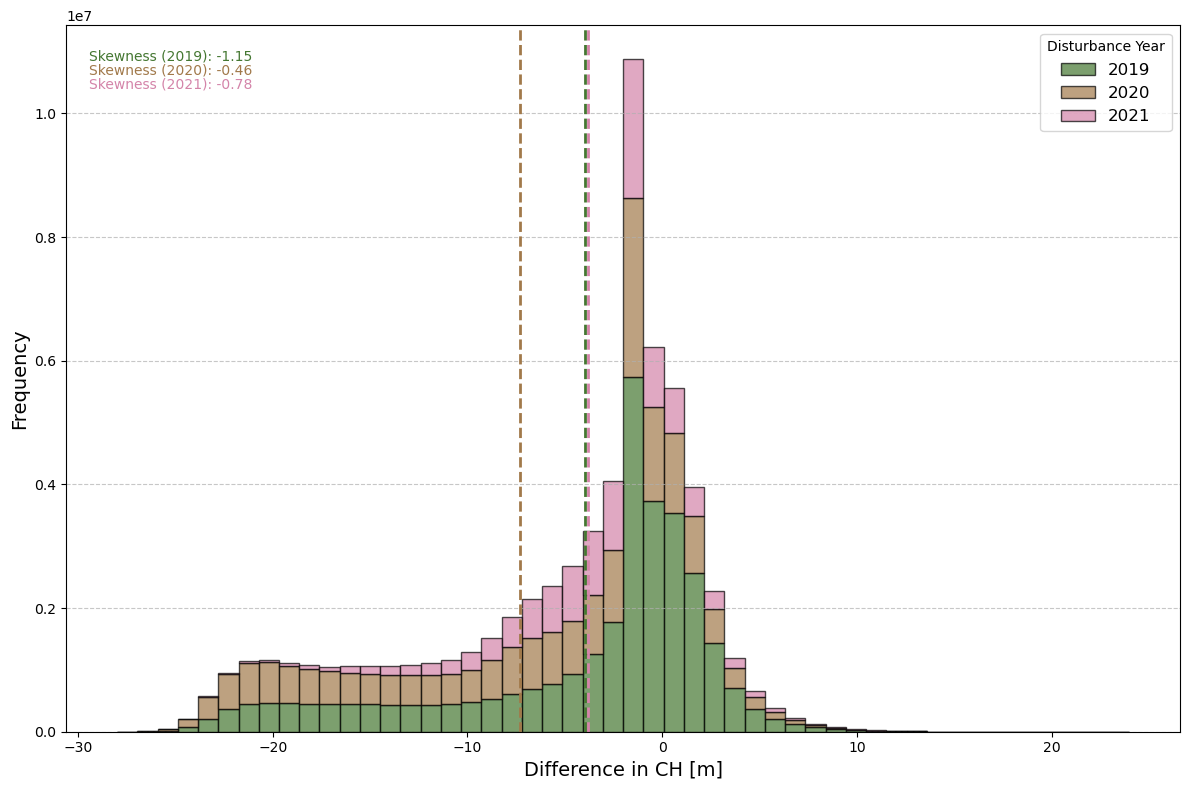

In [9]:
# Generate discrete Cubehelix color palette
colors = sns.color_palette("cubehelix", n_colors=7)
#colors[6] = tuple(max(0, c * 0.7) for c in colors[6]) # darken last colour a bit
colors = colors[2:5]

# Plot
plt.figure(figsize=(12, 8))
plt.hist(stacked_data, bins=50, stacked=True, label=labels, edgecolor='black', alpha=0.7, color=colors)

# Add labels and title
plt.xlabel("Difference in CH [m]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
#plt.title("Stacked Barplot of RH_95 Differences (2021 - 2018) by FCSD Year", fontsize=16)

# Plot the means for each year as a vertical line
for i, label in enumerate(labels[::-1]):
    mean_value = np.mean(grouped_values[label])  # Calculate the mean for each year
    print(mean_value)
    plt.axvline(mean_value, color=colors[i], linestyle='--', linewidth=2)  # Add vertical line for mean

# Add skewness values to the plot for each year
for i, label in enumerate(labels):
    plt.text(0.02, 0.95 - i * 0.02, f"Skewness ({label}): {skewness_values[label]:.2f}", 
             transform=plt.gca().transAxes, fontsize=10, color=colors[i])

# Add legend
plt.legend(title="Disturbance Year", fontsize=12)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Characteristics of Forest Structure for Small-scale and Large-scale Disturbances

In [9]:
# read disturbance size layer
dist_size_path = "./data/reproj/final/FCCL_2020_area_m2_epsg3035.tif"
dist_size_2020 = rxr.open_rasterio(dist_size_path, masked=True, chunks='auto').squeeze()
dist_size_2020 = dist_size_2020.rio.write_crs("EPSG:3035")

In [10]:
dist_size_values = dist_size_2020.values.flatten()
dist_size_values = dist_size_values[~np.isnan(dist_size_values)]

In [ ]:
'''# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(dist_size_values, bins=100, color='skyblue', edgecolor='black')
plt.title("Histogram of Raster Values")
plt.xlabel("Raster Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()
# linear scale dosn't show anything...'''

In [11]:
sns.histplot(dist_size_values, bins=10, log_scale=True)
plt.gca().set(xlabel='disturbance size [m²]')
plt.axvline(50000, color='red', linestyle='--', linewidth=2)  # Add vertical dashed red line
plt.show()

NameError: name 'sns' is not defined

In [12]:
# Calculate statistics
raster_mean = np.mean(dist_size_values)
raster_median = np.median(dist_size_values)
raster_min = np.min(dist_size_values)
raster_max = np.max(dist_size_values)
raster_std = np.std(dist_size_values)
raster_sum = np.sum(dist_size_values)

# Print statistics
print(f"Raster Statistics:")
print(f"- Mean: {raster_mean}")
print(f"- Median: {raster_median}")
print(f"- Min: {raster_min}")
print(f"- Max: {raster_max}")
print(f"- Standard Deviation: {raster_std}")
print(f"- Sum: {raster_sum}")

Raster Statistics:
- Mean: 71648.04819399456
- Median: 8500.0
- Min: 100.0
- Max: 3634200.0
- Standard Deviation: 237757.2441467115
- Sum: 1394183105700.0


In [13]:
# Define the threshold
threshold = 50000 # approx. mean

# Count values smaller than the threshold
num_smaller = np.sum(dist_size_values < threshold)

# Count values larger than or equal to the threshold
num_larger = np.sum(dist_size_values >= threshold)

# Print the results
print(f"Number of raster values smaller than {threshold}: {num_smaller}")
print(f"Number of raster values larger than or equal to {threshold}: {num_larger}")

Number of raster values smaller than 50000: 15185672
Number of raster values larger than or equal to 50000: 4273101


Calculate statistics

In [16]:
# create masks for years 2019-2021, 2020-2019 or 2021-2020
years = pd.date_range('2017', '2024', freq='YE')

# Create mask for small-scale changes
small_dist_2020_mask = expand_years((dist_size_2020 <= 50000).squeeze())
d = d.assign(small_dist_2020_mask=small_dist_2020_mask)

# Create mask for large-scale changes
large_dist_2020_mask = expand_years((dist_size_2020 > 50000).squeeze())
d = d.assign(large_dist_2020_mask=large_dist_2020_mask)

In [ ]:
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {
    name: {
        'small_dist_2020_mask': compute_descriptive_statistics(data, mask=d.small_dist_2020_mask),
        'large_dist_2020_mask': compute_descriptive_statistics(data, mask=d.large_dist_2020_mask),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [ ]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_german_small_dist_2020_allpixels.csv", index=False)
stats_df

In [20]:
# get number of samples for each mask

small_dist_2020_mask_nonexpanded_mask_nonexpanded = dist_size_2020 <= 50000
large_dist_2020_mask_nonexpanded = dist_size_2020 > 50000

num_pixels_small_dist_2020 = small_dist_2020_mask_nonexpanded_mask_nonexpanded.sum().compute().item()
num_pixels_large_dist_2020 = large_dist_2020_mask_nonexpanded.sum().compute().item()

print(f"Number of pixels with small-scale disturbances in 2020: {num_pixels_small_dist_2020}")
print(f"Number of pixels with large-scale disturbances in 2020: {num_pixels_large_dist_2020}")

Number of pixels with small-scale disturbances in 2020: 15189172
Number of pixels with large-scale disturbances in 2020: 4269601


Check for the average month where small-scale and large-scale disturbances occur

In [22]:
# calculate the mean of fccl where large_dist_2020_mask is true
mean_fccl_large_dist = d.fccl.sel(time="2020").where(d.large_dist_2020_mask.sel(time="2020") == 1).mean()

# calculate the mean of fccl where small_dist_2020_mask is true
mean_fccl_small_dist = d.fccl.sel(time="2020").where(d.small_dist_2020_mask.sel(time="2020") == 1).mean()

# Now you can access the calculated means
print("Mean of fccl where large_dist is true:", mean_fccl_large_dist.values)
print("Mean of fccl where small_dist is true:", mean_fccl_small_dist.values)

Mean of fccl where large_dist is true: 34.74162972137209
Mean of fccl where small_dist is true: 34.00458240910038


# Multivariate descriptive statistics of the Single RS Products

Compute descriptive statistics 
* the single tree species in the year 2017 and 2023.

In [164]:
# read ts mask layer
ts_path = "./data/reproj/final/Thuenen_Germany_stockedForest_TreeSpecies_combined_epsg3035.tif"
ts = rxr.open_rasterio(ts_path, masked=True, chunks='auto').squeeze()
ts = ts.rio.write_crs("EPSG:3035")

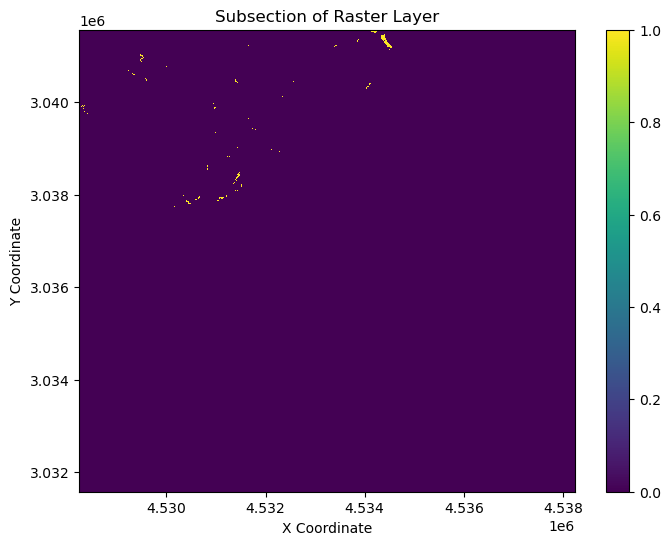

In [8]:
'''
# Select a subsection by slicing (example: rows 100:200, columns 100:200)
subsection = (ts == 3).isel(x=slice(52000,53000),y=slice(52000,53000))

# Plot the subsection
plt.figure(figsize=(8, 6))
subsection.plot(cmap='viridis')  # Change cmap as needed for better visualization
plt.title("Subsection of Raster Layer")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
'''

In [19]:
# select pixels based on tree species
# only one at a time, otherwise RAM explodes !!!

years = pd.date_range('2017', '2024', freq='YE')

#beech_mask = expand_years((ts == 3).squeeze())
#oak_mask = expand_years((ts == 5).squeeze())
#spruce_mask = expand_years((ts == 8).squeeze())
pine_mask = expand_years((ts == 9).squeeze())

# Add the time-specific mask to dataset
#d = d.assign(beech_mask=beech_mask)
#d = d.assign(oak_mask=oak_mask)
#d = d.assign(spruce_mask=spruce_mask)
d = d.assign(pine_mask=pine_mask)

In [20]:
datasets = {
    'AGBD': d.agbd,
    'TCC': d.cover,
    'FHDI': d.fhd_normal,
    'CH': d.rh_95,
    'FCSD': d.fcsd
}

stats_dict = {
    name: {
        #'beech_mask': compute_descriptive_statistics(data, mask=d.beech_mask),
        #'oak_mask': compute_descriptive_statistics(data, mask=d.oak_mask),
        #'spruce_mask': compute_descriptive_statistics(data, mask=d.spruce_mask),
        'pine_mask': compute_descriptive_statistics(data, mask=d.pine_mask),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [21]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_german_pine_mask_allpixels.csv", index=False)
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,pine_mask,194.644592,176.036301,170.983643,178.396561,169.615738,169.901627,168.885483,195.0,...,217.5,252.0,221.5,312.0,297.0,294.0,281.0,276.0,284.0,260.0
1,TCC,pine_mask,59.675350,55.780731,53.470379,55.482552,49.889946,49.594269,55.505024,62.0,...,72.5,74.0,80.0,79.0,80.0,82.0,82.0,82.0,82.0,81.0
2,FHDI,pine_mask,281.616882,280.436615,277.410156,283.321899,279.671021,282.881805,282.097015,285.0,...,309.0,324.0,316.0,206.0,203.0,208.0,191.0,220.0,222.0,214.0
3,CH,pine_mask,22.769394,20.437922,20.977945,21.345612,20.590933,20.120073,20.854319,23.0,...,25.0,24.0,25.0,30.0,28.0,30.0,30.0,30.0,29.0,28.0
4,FCSD,pine_mask,NaN,2666.350342,3051.238281,2600.310303,1892.742554,NaN,NaN,NaN,...,3454.0,NaN,NaN,NaN,9652.0,9711.0,9758.0,9735.0,NaN,NaN


In [16]:
'''
# load stats_df, if necessary
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
stats_df = pd.read_csv("./data/descriptive_stats_german_spruce_mask_allpixels.csv")
stats_df
'''

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,spruce_mask,210.453410,200.216640,199.52638,190.237990,180.582500,178.199100,169.123250,214.0,...,299.0,320.5,270.0,311.0,332.0,330.0,288.0,314.0,299.0,268.0
1,TCC,spruce_mask,58.587723,58.987278,57.70272,58.544342,54.541626,57.075000,55.768227,60.0,...,87.5,86.5,87.5,79.0,83.0,85.0,84.0,84.0,85.0,83.0
2,FHDI,spruce_mask,279.694100,294.472260,290.36460,287.904660,278.960080,284.987820,280.185880,287.0,...,336.5,350.5,344.5,206.0,200.0,210.0,210.0,218.0,220.0,212.0
3,CH,spruce_mask,24.944717,24.016920,23.35822,23.007639,21.873823,21.575222,21.764315,26.0,...,31.0,33.5,32.5,30.0,30.0,35.0,32.0,37.0,32.0,28.0
4,FCSD,spruce_mask,NaN,1724.347500,1971.98020,2028.951500,1669.971600,NaN,NaN,NaN,...,2830.5,NaN,NaN,NaN,9733.0,9760.0,9808.0,9779.0,NaN,NaN


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
dataset_names = ['AGBD', 'TCC', 'FHDI', 'CH', 'FCSD']
mask_type = 'pine_mask'  # Specify the mask type to plot

# Iterate over datasets to fill each subplot
for col, dataset_name in enumerate(dataset_names):
    ax = axes[col]
    plot_statistics_df(ax, years, dataset_name, mask_type, stats_df)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Plot the timeseries of Forest Structure

In [54]:
# load stats_df, if necessary
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
stats_df = pd.read_csv("./data/descriptive_stats_bavarianforest_2020_removed_size.csv")

# Divide all values in the FCSD row by 100 to convert to Percent
stats_df.loc[stats_df['Dataset'] == 'FCSD', stats_df.columns[2:]] /= 100

stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,ref_bavarianforest_2020_removed_smallscale,219.384610,193.704070,192.787730,123.929825,108.679306,112.440796,116.735280,224.0,...,224.000,266.0,276.0,259.0,270.00,247.00,228.00,242.00,241.0,209.0
1,AGBD,ref_bavarianforest_2020_removed_largescale,227.486800,201.489170,186.643260,109.327995,89.265310,80.157400,86.224320,229.0,...,194.500,130.0,159.5,229.0,216.00,190.00,190.00,163.00,191.0,166.0
2,TCC,ref_bavarianforest_2020_removed_smallscale,57.971912,53.959057,52.574890,35.475880,27.420050,39.156425,41.722630,59.0,...,59.000,79.0,74.0,58.0,66.00,71.00,67.00,65.00,70.0,63.0
3,TCC,ref_bavarianforest_2020_removed_largescale,57.452404,52.670593,49.933550,28.895382,20.991990,30.089539,35.531574,57.0,...,38.500,53.0,61.5,40.0,56.00,51.00,58.00,50.00,56.0,51.0
4,FHDI,ref_bavarianforest_2020_removed_smallscale,285.835700,296.951870,289.160300,250.248780,218.597170,245.265760,246.688780,291.0,...,323.000,332.5,346.5,142.0,152.00,148.00,174.00,181.00,178.0,161.0
5,FHDI,ref_bavarianforest_2020_removed_largescale,289.567870,302.031600,289.196040,236.430250,199.335530,224.698400,229.648910,292.0,...,254.500,285.5,284.0,85.0,89.00,121.00,148.00,149.00,135.0,146.0
6,CH,ref_bavarianforest_2020_removed_smallscale,25.990421,24.469082,23.072357,16.865013,14.214045,14.734491,17.212059,27.0,...,26.000,28.5,31.5,26.0,26.00,25.00,26.00,27.00,26.0,23.0
7,CH,ref_bavarianforest_2020_removed_largescale,27.102262,25.325636,22.824694,14.520264,11.865221,11.309142,14.703582,28.0,...,19.000,21.5,22.0,19.0,20.00,22.00,22.00,19.00,22.0,20.0
8,FCSD,ref_bavarianforest_2020_removed_smallscale,NaN,15.357533,31.782268,37.727544,20.047081,NaN,NaN,NaN,...,65.970,NaN,NaN,NaN,84.69,95.22,95.20,94.72,NaN,NaN
9,FCSD,ref_bavarianforest_2020_removed_largescale,NaN,15.081641,38.242869,45.504697,15.580098,NaN,NaN,NaN,...,53.655,NaN,NaN,NaN,55.06,92.48,91.82,90.89,NaN,NaN


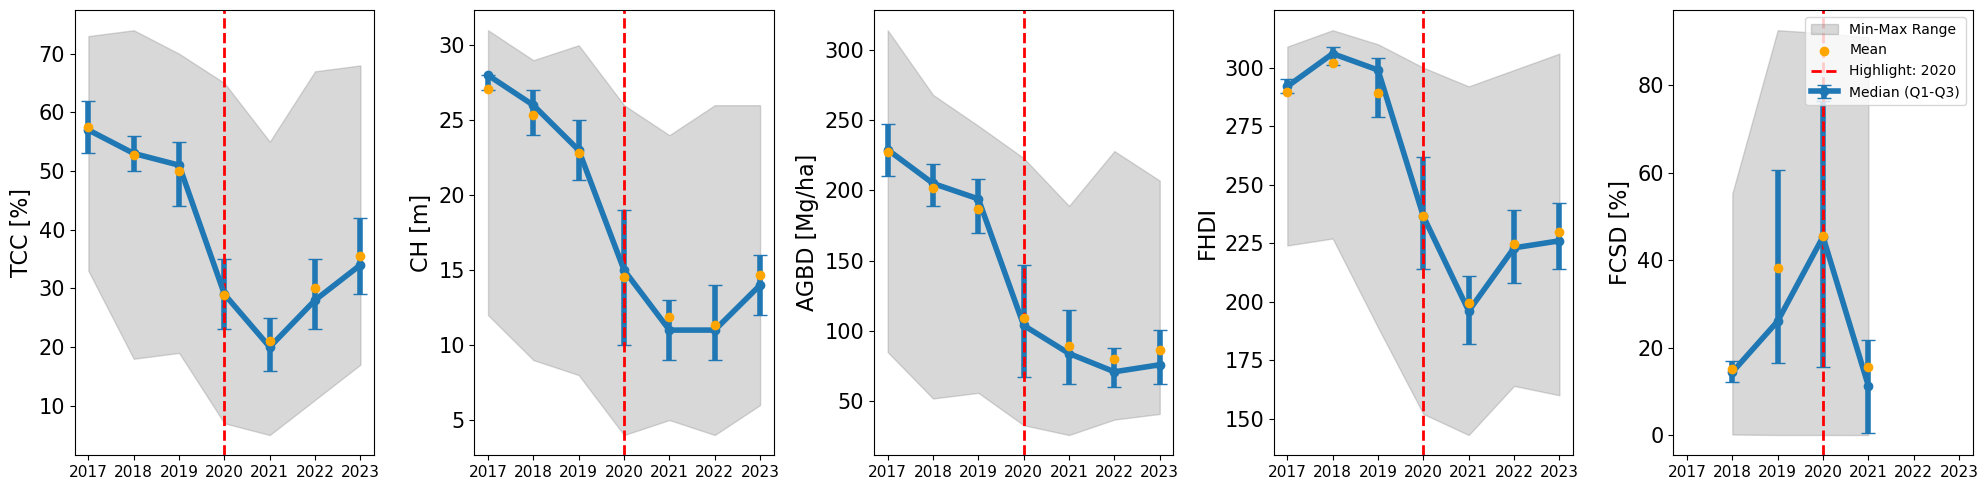

In [56]:
highlight_time = 2020

metrics_dict = {
    'TCC': '%',
    'CH': 'm',
    'AGBD': 'Mg/ha',
    'FHDI': '',
    'FCSD': '%'
}

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
dataset_names = ['TCC', 'CH', 'AGBD', 'FHDI', 'FCSD']
#mask_type = 'ca_fire_2020' 

# Iterate over datasets to fill each subplot
for col, dataset_name in enumerate(dataset_names):
    ax = axes[col]
    plot_statistics_df(
        ax=ax, 
        time_values=years, 
        dataset_name=dataset_name, 
        mask_type='ref_bavarianforest_2020_removed_largescale', 
        stats_df=stats_df, 
        highlight_time=highlight_time, 
        metrics_dict=metrics_dict
    )
    
    # Only add legend to the first subplot
    if col != 4:
        ax.legend().remove()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Plot number of Samples for each Class

In [25]:
# Load data
data = {
    'Unnamed: 0': [2019, 2020, 2021, 'allyears'],
    'no disturbace': [None, None, None, 953821236.0],
    'stand-replacing': [16067122.0, 19458773.0, 12659626.0, None],
    'non-stand-replacing': [36014921.0, 20887644.0, 12829796.0, None],
    'wind_bb': [6085077.0, 9457289.0, None, None],
    'fire': [37983.0, 10741.0, None, None],
    'harvest': [2703127.0, 2446302.0, None, None],
    'small-scale': [None, 15189172.0, None, None],
    'large-scale': [None, 4269601.0, None, None],
}

df = pd.DataFrame(data)

# Filter for years 2019, 2020, 2021
df_filtered = df[df['Unnamed: 0'].isin([2019, 2020, 2021])]

# Rename 'Unnamed: 0' to 'Year' for clarity
df_filtered.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

# Extract data for 2020
data_2020 = df_filtered[df_filtered['Year'] == 2020]

# Extract the 'no disturbace' value
no_disturbance_value = df.loc[df['Unnamed: 0'] == 'allyears', 'no disturbace'].values[0]

/dss/dsstbyfs02/scratch/09/di38set/di38set/ipykernel_52193/3885940686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)


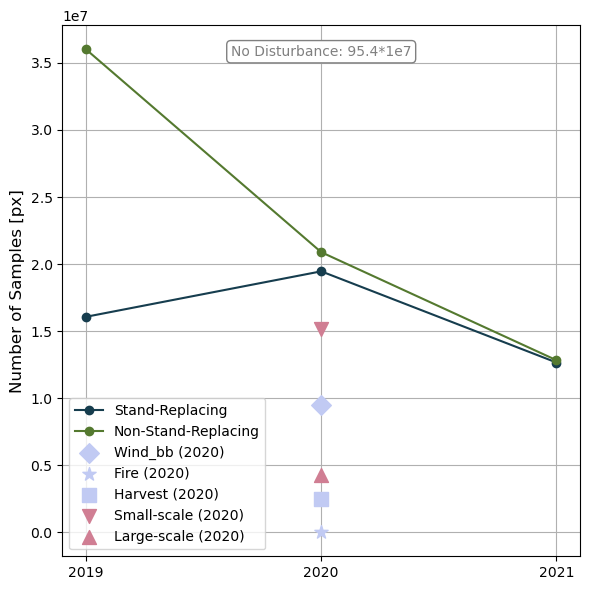

In [26]:
# Colours
palette = sns.color_palette("cubehelix", n_colors=4)
#palette = sns.color_palette("husl", 4)
stand_replacing_color = palette[0]
non_stand_replacing_color = palette[1]
size_colour = palette[2]
ca_color = palette[3]

# Define markers for the scatterplots
markers = {
    "wind_bb": "D",    
    "fire": "*",      
    "harvest": "s",    
    "small-scale": "v", 
    "large-scale": "^" 
}

# Plot
plt.figure(figsize=(6, 6))

# Line plots for stand-replacing and non-stand-replacing
plt.plot(df_filtered['Year'], df_filtered['stand-replacing'], label='Stand-Replacing', marker='o', color=stand_replacing_color)
plt.plot(df_filtered['Year'], df_filtered['non-stand-replacing'], label='Non-Stand-Replacing', marker='o', color=non_stand_replacing_color)

# Add data points for 2020 using different markers
plt.scatter(2020, data_2020['wind_bb'], label='Wind_bb (2020)', marker=markers['wind_bb'], s=100, zorder=5, color=ca_color)
plt.scatter(2020, data_2020['fire'], label='Fire (2020)', marker=markers['fire'], s=100, zorder=5, color=ca_color)
plt.scatter(2020, data_2020['harvest'], label='Harvest (2020)', marker=markers['harvest'], s=100, zorder=5, color=ca_color)
plt.scatter(2020, data_2020['small-scale'], label='Small-scale (2020)', marker=markers['small-scale'], s=100, zorder=5, color=size_colour)
plt.scatter(2020, data_2020['large-scale'], label='Large-scale (2020)', marker=markers['large-scale'], s=100, zorder=5, color=size_colour)

# Add the legend
legend = plt.legend(loc='upper right', fontsize=10)

# Get the bounding box of the legend and calculate annotation position
legend_bbox = legend.get_window_extent()
annotation_x = 2020  # Align with year 2020 on the x-axis
annotation_y = plt.gca().get_ylim()[0] + 0.95 * (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0]) 

# Annotate the value of no_disturbance_value at the top of the plot
scaled_no_disturbance_value = no_disturbance_value / 1e7
plt.text(
    annotation_x, annotation_y, 
    f"No Disturbance: {scaled_no_disturbance_value:.1f}*1e7",
    color='gray', fontsize=10,
    verticalalignment='center', horizontalalignment='center',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# Customize the plot
#plt.title('Disturbance Patterns Over Years', fontsize=14)
#plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Samples [px]', fontsize=12)
plt.xticks([2019, 2020, 2021])
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Analyse Regional Example - Windstorm Frederieke 2018 in Hesse

In [2]:
# load reference data
ref = gpd.read_file("./data/reproj/frederieke_jan2018_ref_merged.gpkg")
ref = ref.to_crs("EPSG:3035")

# calculate the total area of all polygons in square meters and then convert to hectares
total_area = ref.geometry.area.sum() / 10000  # Convert to hectares
print(f"Total area of all polygons: {total_area:.2f} hectares")


# calculate the area for each "DAM" value in hectares
dam_areas = ref.groupby('DAM')['geometry'].apply(lambda x: x.area.sum()) / 10000  # Convert to hectares

# print the areas for each DAM value and their percentages
for dam, area in dam_areas.items():
    percentage = (area / total_area) * 100
    print(f"Area for DAM {dam}: {area:.2f} hectares ({percentage:.2f}%)")

Total area of all polygons: 304.44 hectares
Area for DAM 1: 96.74 hectares (31.77%)
Area for DAM 2: 13.29 hectares (4.36%)
Area for DAM 3: 194.42 hectares (63.86%)


In [3]:
# Load the FCCL raster
fccl = rxr.open_rasterio(fccl_path, masked=True).squeeze()
fccl = fccl.rio.write_crs("EPSG:3035")  # Ensure CRS matches vector data

# Mask the FCCL dataset with the vector polygons
fccl_roi = fccl.rio.clip(ref.geometry, ref.crs, drop=True)
fccl_roi.name = "fccl"
fccl_roi.plot()

NameError: name 'fccl_path' is not defined

In [6]:
# Flatten and count occurrences of FCCL values
df = fccl_roi.to_dataframe().reset_index()

# count occurrences of each FCCL value
fccl_counts = df.groupby('fccl').size().reset_index(name='count')

# total amount of fccl 
total_fccl_count = fccl_counts['count'].sum()

# normalize to get proportions
fccl_counts['proportion'] = (fccl_counts['count'] / total_fccl_count)*100

# Sort values for better visualization
fccl_counts = fccl_counts.sort_values(by='fccl')

# Calculate total mapped area of FCCL in all years and in 2018
a_all = fccl_counts.drop(index=fccl_counts[fccl_counts['fccl'] == 0].index[0])['proportion'].sum()
a_2018 = fccl_counts.loc[(fccl_counts['fccl'] >= 5) & (fccl_counts['fccl'] <= 16), 'proportion'].sum()

print(fccl_counts.to_string())
print(f"Total proportion mapped over all years: {a_all}")
print(f"Total proportion mapped in 2018: {a_2018}")

    fccl  count  proportion
0    0.0   5396   18.191012
1    1.0     10    0.033712
2    4.0      1    0.003371
3    5.0    171    0.576476
4    6.0   1069    3.603816
5    7.0   7081   23.871490
6    8.0   9717   32.757981
7    9.0   1461    4.925328
8   10.0    327    1.102383
9   11.0    102    0.343863
10  12.0     36    0.121363
11  13.0    136    0.458484
12  14.0     52    0.175303
13  15.0     37    0.124735
14  16.0     44    0.148333
15  17.0    105    0.353976
16  18.0    713    2.403668
17  19.0    228    0.768634
18  20.0    987    3.327378
19  21.0     79    0.266325
20  22.0     76    0.256211
21  23.0     36    0.121363
22  24.0     64    0.215757
23  25.0     61    0.205643
24  26.0     68    0.229242
25  27.0      7    0.023598
26  28.0    165    0.556249
27  29.0     40    0.134848
28  30.0      9    0.030341
29  31.0    432    1.456360
30  32.0     58    0.195530
31  33.0     30    0.101136
32  34.0     15    0.050568
33  35.0     28    0.094394
34  36.0     54    0

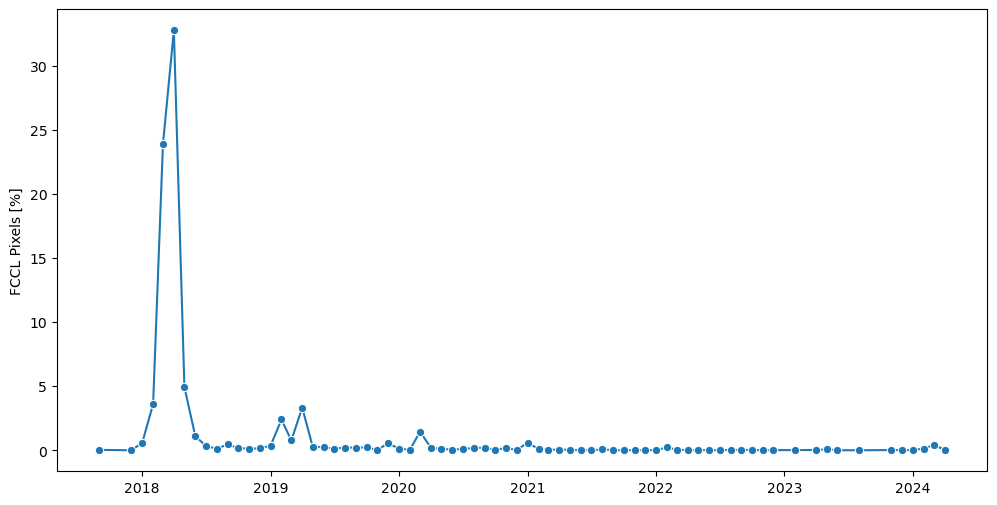

In [10]:
# convert fccl to dates
start_date = pd.Timestamp("2017-09-01")
fccl_counts["date"] = fccl_counts["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)

# Drop na
fccl_counts = fccl_counts.dropna(subset=["date"])
fccl_counts

# Plot timeline
plt.figure(figsize=(12, 6))
sns.lineplot(data=fccl_counts, x="date", y="proportion", marker="o", linestyle="-", color="#1f77b4")
#plt.title("FCCL Pixel Proportions Over Time")
plt.xlabel("")
plt.ylabel("FCCL Pixels [%]")
plt.xticks()
#plt.grid(True)
plt.show()

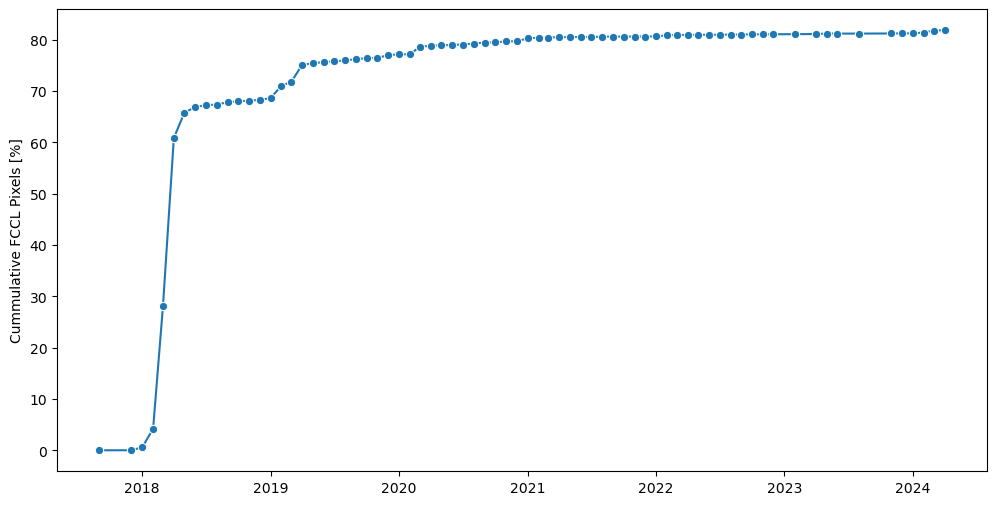

In [11]:
# Plot the cumulative timeline
# Filter out rows where fccl == 0
filtered_fccl_counts = fccl_counts[fccl_counts["fccl"] != 0].copy()
filtered_fccl_counts["cumulative_proportion"] = filtered_fccl_counts["proportion"].cumsum()

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", marker="o", linestyle="-", color="#1f77b4")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.xticks()
#plt.grid(True)
plt.show()

Now, check for the different damage intensities provided by the reference...

In [12]:
# Rasterize the DAM attribute onto the FCCL grid
dam_raster = rasterize(
    [(geom, dam) for geom, dam in zip(ref.geometry, ref["DAM"])], 
    out_shape=fccl_roi.shape,
    fill=np.nan,  # Keep NaN where there's no data
    transform=fccl_roi.rio.transform(),
    dtype="float32"
)

# Convert to Xarray DataArray
dam_xr = xr.DataArray(dam_raster, coords=fccl_roi.coords, dims=fccl_roi.dims, name="DAM")

# Combine FCCL and DAM into a single dataset
fccl_with_dam = xr.merge([fccl_roi, dam_xr])

# Convert to DataFrame
df = fccl_with_dam.to_dataframe().reset_index()

In [13]:
# Compute proportion of DAM of all FCCL pixels mapped in the reference areas

start_date = pd.Timestamp("2017-09-01")

df["date"] = df["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)
df = df.dropna(subset=["date"])  # Remove NaN dates (FCCL = 0)

# calculate proportion of fccl
def compute_proportion(df_dam):
    df_counts = df_dam.groupby(["date", "fccl"]).size().reset_index(name="count")  # Keep fccl column
    df_counts["proportion"] = (df_counts["count"] / total_fccl_count)*100
    return df_counts

df_dam1_counts = compute_proportion(df[df["DAM"] == 1])
df_dam2_counts = compute_proportion(df[df["DAM"] == 2])
df_dam3_counts = compute_proportion(df[df["DAM"] == 3])

# Now, calculate cumulative proportions while excluding fccl == 0
def compute_cumulative(df_counts):
    df_counts = df_counts[df_counts["fccl"] != 0].copy()  # Exclude fccl == 0
    df_counts["cumulative_proportion"] = df_counts.sort_values("date")["proportion"].cumsum() 
    return df_counts

df_dam1_counts = compute_cumulative(df_dam1_counts)
df_dam2_counts = compute_cumulative(df_dam2_counts)
df_dam3_counts = compute_cumulative(df_dam3_counts)

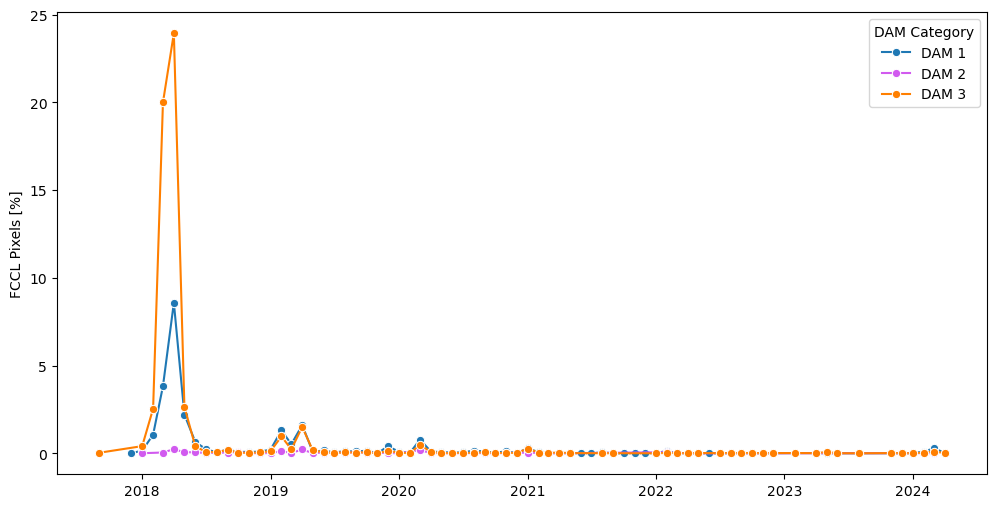

In [14]:
# plot
plt.figure(figsize=(12, 6))

# Plot for DAM 1
sns.lineplot(data=df_dam1_counts, x="date", y="proportion", marker="o", linestyle="-", label="DAM 1", color="#1f78b4")

# Plot for DAM 2
sns.lineplot(data=df_dam2_counts, x="date", y="proportion", marker="o", linestyle="-", label="DAM 2", color="#d15aef")

# Plot for DAM 3
sns.lineplot(data=df_dam3_counts, x="date", y="proportion", marker="o", linestyle="-", label="DAM 3", color="#ff7f00")

#plt.title("FCCL Proportions Over Time by DAM Category (2017-2024)")
plt.xlabel("")
plt.ylabel("FCCL Pixels [%]")
plt.xticks()
plt.legend(title="DAM Category")
#plt.grid(True)
plt.show()

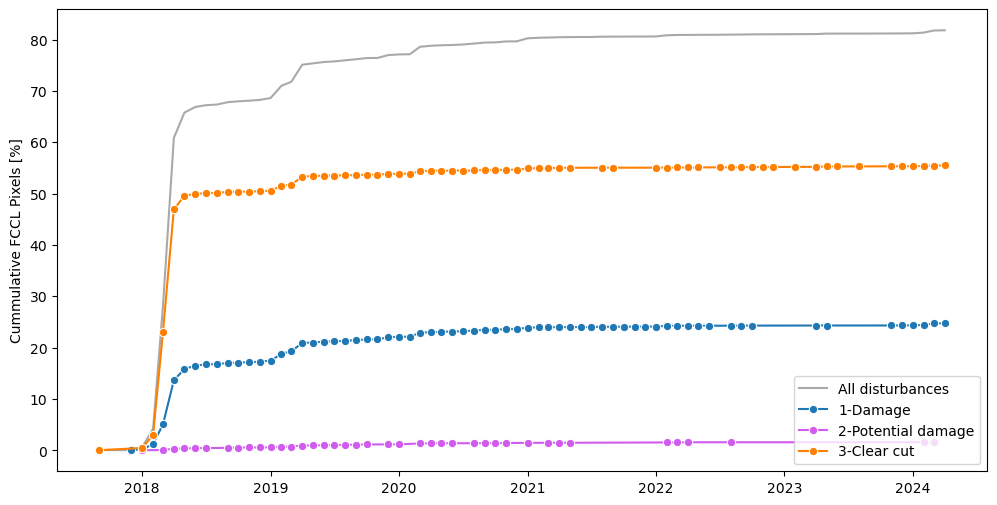

In [15]:
# plot cummulative
plt.figure(figsize=(12, 6))

# Plot for all DAM
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances ", color="darkgrey")

# Plot for DAM 1
sns.lineplot(data=df_dam1_counts, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="1-Damage", color="#1f78b4")

# Plot for DAM 2
sns.lineplot(data=df_dam2_counts, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="2-Potential damage", color="#d15aef")

# Plot for DAM 3
sns.lineplot(data=df_dam3_counts, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="3-Clear cut", color="#ff7f00")

#plt.title("FCCL Proportions Over Time by DAM Category (2017-2024)")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.yticks(np.arange(0, 81, 10)) 
plt.xticks()
plt.legend(loc="lower right")
#plt.grid(True)
plt.show()

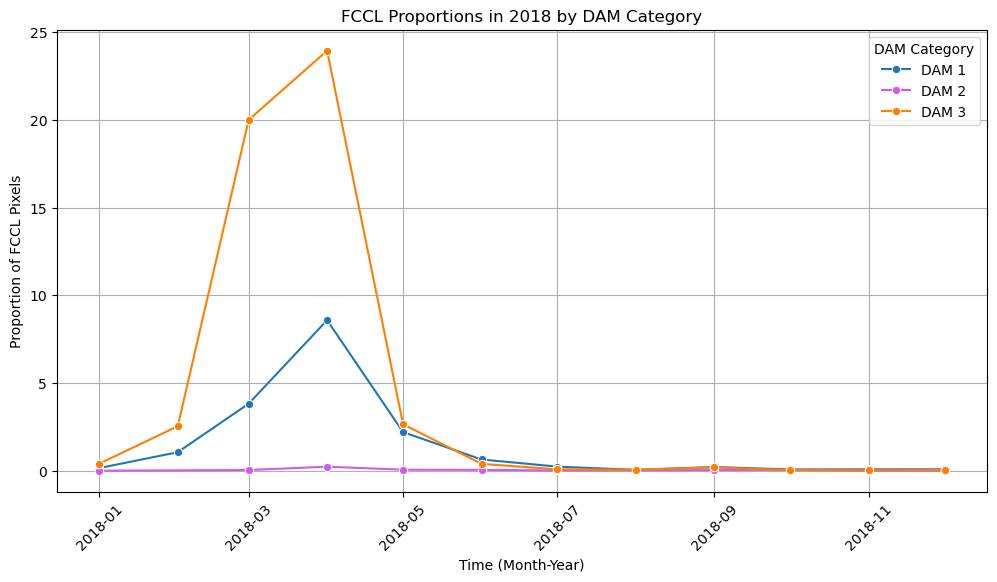

In [16]:
# Filter data to focus on 2018
df_dam1_2018 = df_dam1_counts[(df_dam1_counts["date"] >= "2018-01-01") & (df_dam1_counts["date"] <= "2018-12-31")]
df_dam2_2018 = df_dam2_counts[(df_dam2_counts["date"] >= "2018-01-01") & (df_dam2_counts["date"] <= "2018-12-31")]
df_dam3_2018 = df_dam3_counts[(df_dam3_counts["date"] >= "2018-01-01") & (df_dam3_counts["date"] <= "2018-12-31")]

plt.figure(figsize=(12, 6))

# Plot for DAM 1 (2018)
sns.lineplot(data=df_dam1_2018, x="date", y="proportion", marker="o", linestyle="-", label="DAM 1", color="#1f78b4")

# Plot for DAM 2 (2018)
sns.lineplot(data=df_dam2_2018, x="date", y="proportion", marker="o", linestyle="-", label="DAM 2", color="#d15aef")

# Plot for DAM 3 (2018)
sns.lineplot(data=df_dam3_2018, x="date", y="proportion", marker="o", linestyle="-", label="DAM 3", color="#ff7f00")

plt.title("FCCL Proportions in 2018 by DAM Category")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Proportion of FCCL Pixels")
plt.xticks(rotation=45)
plt.legend(title="DAM Category")
plt.grid(True)
plt.show()

Normalize timeline by area of DAM category

In [17]:
# Count the number of pixels for each DAM category (excluding NaN values)
dam_categories = np.unique(dam_raster[~np.isnan(dam_raster)])  # Get unique DAM categories excluding NaN

# Calculate the total number of pixels mapped for each DAM category
total_dam_pixels = {}
for dam_category in dam_categories:
    total_dam_pixels[dam_category] = np.sum(dam_raster == dam_category)  # Count pixels for this DAM category

# Now, total_dam_pixels will have the total pixel count for each DAM category
print(total_dam_pixels)

# Adjusted function to normalize proportions by the total mapped pixels for each DAM category
def compute_normalized_proportion(df_dam, dam_category, total_dam_pixels):
    df_counts = df_dam.groupby(["date", "fccl"]).size().reset_index(name="count")  # Keep fccl column
    df_counts["proportion"] = (df_counts["count"] / total_fccl_count) * 100  # Normalized by all FCCL pixels
    df_counts["normalized_proportion"] = (df_counts["count"] / total_dam_pixels[dam_category]) * 100  # Normalized by DAM pixels
    return df_counts

# Now calculate normalized proportions for each DAM category by passing the correct total pixels
df_dam1_counts = compute_normalized_proportion(df[df["DAM"] == 1], 1, total_dam_pixels)
df_dam2_counts = compute_normalized_proportion(df[df["DAM"] == 2], 2, total_dam_pixels)
df_dam3_counts = compute_normalized_proportion(df[df["DAM"] == 3], 3, total_dam_pixels)

# Compute cumulative normalized proportion (but ensuring it doesn't exceed 100% for each DAM)
def compute_cumulative(df_counts):
    df_counts = df_counts[df_counts["fccl"] != 0].copy()  # Exclude fccl == 0
    df_counts["cumulative_normalized_proportion"] = df_counts.sort_values("date")["normalized_proportion"].cumsum()
    df_counts["cumulative_normalized_proportion"] = df_counts["cumulative_normalized_proportion"].clip(upper=100)  # Ensure it doesn't go beyond 100%
    return df_counts

# Apply cumulative calculation
df_dam1_counts = compute_cumulative(df_dam1_counts)
df_dam2_counts = compute_cumulative(df_dam2_counts)
df_dam3_counts = compute_cumulative(df_dam3_counts)

{np.float32(1.0): np.int64(9696), np.float32(2.0): np.int64(1309), np.float32(3.0): np.int64(19488)}


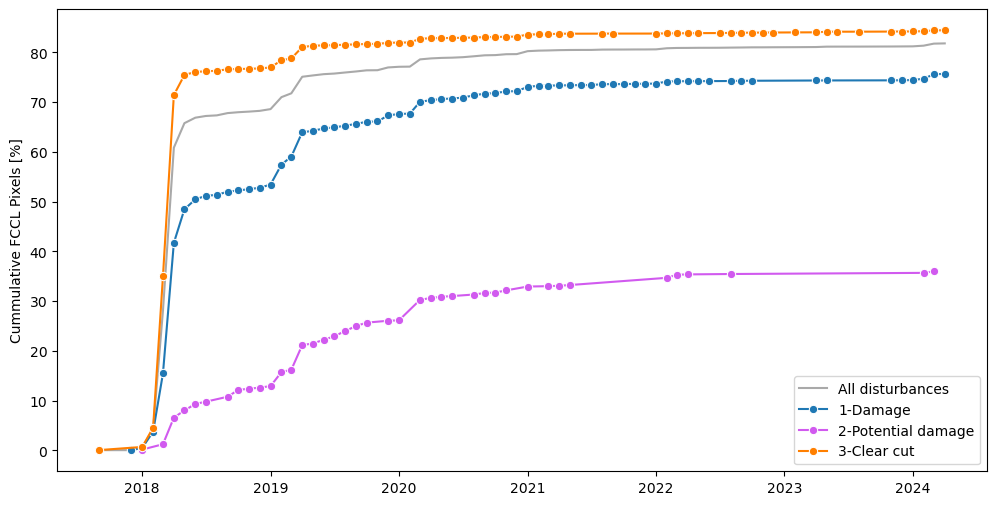

In [18]:
# plot cummulative
plt.figure(figsize=(12, 6))

# Plot for all DAM
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances ", color="darkgrey")

# Plot for DAM 1
sns.lineplot(data=df_dam1_counts, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="1-Damage", color="#1f78b4")

# Plot for DAM 2
sns.lineplot(data=df_dam2_counts, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="2-Potential damage", color="#d15aef")

# Plot for DAM 3
sns.lineplot(data=df_dam3_counts, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="3-Clear cut", color="#ff7f00")

#plt.title("FCCL Proportions Over Time by DAM Category (2017-2024)")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.yticks(np.arange(0, 81, 10)) 
plt.xticks()
plt.legend(loc="lower right")
#plt.grid(True)
plt.show()

Analyse how forest structure and fcsd change in the ref areas

In [4]:
# read mask layer
# analyse the disturbance patterns
roi_path = "./data/reproj/final/frederieke_jan2018_ref_merged_rasterized.tif"
roi = rxr.open_rasterio(roi_path, masked=True, chunks='auto').squeeze()
roi = roi.rio.write_crs("EPSG:3035")

In [10]:
years = pd.date_range('2017', '2024', freq='YE')
roi_expanded = expand_years((roi>0).squeeze())
roi_dam1_expanded = expand_years((roi==1).squeeze())
roi_dam2_expanded = expand_years((roi==2).squeeze())
roi_dam3_expanded = expand_years((roi==3).squeeze())

In [11]:
# Add the time-specific mask to dataset
d = d.assign(roi_mask=roi_expanded)
d = d.assign(roi_dam1_mask=roi_dam1_expanded)
d = d.assign(roi_dam2_mask=roi_dam2_expanded)
d = d.assign(roi_dam3_mask=roi_dam3_expanded)

In [12]:
# clip to extent of roi
minx, miny, maxx, maxy = ref.total_bounds
d_subset = d.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 

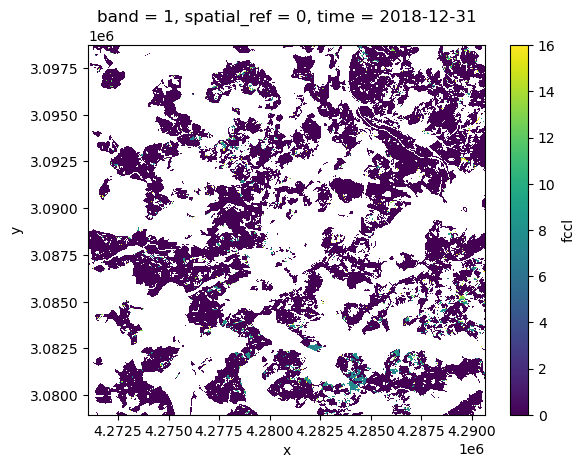

In [13]:
d_subset.fccl.sel(time="2018").plot()

In [14]:
# count area of pixels mapped as FCCL from Jan-May 2018 in the AOI
d_2018 = d_subset.fccl.sel(time="2018")
mask = ((d_2018 >= 5) & (d_2018 <= 10)).compute()
filtered_data = d_2018.where(mask, drop=True)
sum_pixels = filtered_data.sum().compute().values
print(sum_pixels)

322244.0


In [180]:
'''# export layers of interest of d_subset
# Assuming d_subset is already loaded as an xarray dataset
data = d_subset.ca_harvest.sel(time="2018").squeeze().drop_vars('time')

# Define output filename
output_file = "./data/ca_harvest_roi_hesse.tif"

# Extract x and y coordinates
x = data["x"].values
y = data["y"].values

# Compute affine transform (assumes regularly spaced grid)
transform = from_origin(x.min(), y.max(), abs(x[1] - x[0]), abs(y[1] - y[0]))

# Save as TIFF using rasterio
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype=data.dtype,
    crs="EPSG:3035",  # Change to the correct CRS if different
    transform=transform
) as dst:
    dst.write(data.values, 1)

print(f"Saved as {output_file}")'''

Saved as ./data/ca_harvest_roi_hesse.tif


In [ ]:
datasets = {
    'AGBD': d_subset.agbd,
    'TCC': d_subset.cover,
    'FHDI': d_subset.fhd_normal,
    'CH': d_subset.rh_95,
    'FCSD': d_subset.fcsd
}

stats_dict = {
    name: {
        'roi_mask': compute_descriptive_statistics(data, mask=d_subset.roi_mask),
        'roi_dam1_mask': compute_descriptive_statistics(data, mask=d_subset.roi_dam1_mask),
        'roi_dam2_mask': compute_descriptive_statistics(data, mask=d_subset.roi_dam2_mask),
        'roi_dam3_mask': compute_descriptive_statistics(data, mask=d_subset.roi_dam3_mask),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [34]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_frederiekede_all.csv", index=False)
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,roi_mask,209.353409,81.395317,71.855446,68.438637,83.638046,77.755440,92.840057,216.0,...,188.50,173.5,212.50,275.0,237.0,219.0,213.0,225.0,220.0,201.0
1,AGBD,roi_dam1_mask,213.499100,105.352776,89.067764,80.360191,93.106300,87.189308,100.739227,216.0,...,228.50,216.5,245.50,265.0,227.0,217.0,210.0,225.0,219.0,188.0
2,AGBD,roi_dam2_mask,189.841354,147.660614,128.348068,113.049721,121.374901,119.483032,124.868980,193.0,...,311.75,343.5,307.00,242.0,213.0,207.0,192.0,212.0,208.0,170.0
3,AGBD,roi_dam3_mask,208.585068,64.881081,59.391567,59.436123,76.332588,70.198128,86.708450,217.0,...,161.50,144.0,188.00,275.0,237.0,214.0,213.0,205.0,217.0,200.0
4,TCC,roi_mask,58.238083,26.394840,21.676418,21.838903,27.024374,30.957354,35.164894,61.0,...,58.50,75.5,83.00,71.0,76.0,77.0,77.0,78.0,76.0,69.0
5,TCC,roi_dam1_mask,60.219376,34.322922,27.597460,25.568872,30.370249,34.681736,37.477394,62.0,...,73.00,90.0,89.00,68.0,73.0,74.0,77.0,77.0,76.0,69.0
6,TCC,roi_dam2_mask,54.989738,45.784531,40.382793,36.119179,39.438831,43.606155,44.582478,57.0,...,99.00,109.5,96.75,62.0,70.0,71.0,68.0,74.0,72.0,64.0
7,TCC,roi_dam3_mask,57.461037,21.101139,17.437880,19.000479,24.504898,28.231768,33.367081,60.0,...,52.50,66.0,75.50,70.0,76.0,77.0,72.0,77.0,76.0,68.0
8,FHDI,roi_mask,282.185211,220.569702,208.723679,210.450104,212.998413,229.864670,233.102417,290.0,...,316.50,331.5,318.50,180.0,188.0,191.0,179.0,181.0,185.0,160.0
9,FHDI,roi_dam1_mask,284.149719,246.138489,227.506622,222.155212,220.749176,236.880676,237.050400,289.0,...,355.50,355.5,342.00,149.0,187.0,183.0,179.0,170.0,185.0,160.0


Check how much percent of the reference data is mapped as wind/bb and harvest

In [16]:
d_subset

<xarray.Dataset>
Dimensions:        (x: 1964, y: 1977, time: 7)
Coordinates:
    band           int64 1
  * x              (x) float64 4.271e+06 4.271e+06 ... 4.291e+06 4.291e+06
  * y              (y) float64 3.099e+06 3.099e+06 ... 3.079e+06 3.079e+06
    spatial_ref    int64 0
  * time           (time) datetime64[ns] 2017-12-31 2018-12-31 ... 2023-12-31
Data variables:
    agbd           (time, y, x) float32 dask.array<chunksize=(1, 83, 1964), meta=np.ndarray>
    cover          (time, y, x) float32 dask.array<chunksize=(1, 83, 1964), meta=np.ndarray>
    fhd_normal     (time, y, x) float32 dask.array<chunksize=(1, 83, 1964), meta=np.ndarray>
    rh_95          (time, y, x) float32 dask.array<chunksize=(1, 83, 1964), meta=np.ndarray>
    fccl           (time, y, x) float64 dask.array<chunksize=(1, 83, 1964), meta=np.ndarray>
    fcsd           (time, y, x) float32 dask.array<chunksize=(2, 83, 1964), meta=np.ndarray>
    roi_mask       (y, x, time) bool dask.array<chunksize=(83, 1964, 7), meta=np.ndarray>
    roi_dam1_mask  (y, x, time) bool dask.array<chunksize=(83, 1964, 7), meta=np.ndarray>
    roi_dam2_mask  (y, x, time) bool dask.array<chunksize=(83, 1964, 7), meta=np.ndarray>
    roi_dam3_mask  (y, x, time) bool dask.array<chunksize=(83, 1964, 7), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [197]:
# Select the timestamp 2018
roi_2018 = d_subset.roi_mask.sel(time="2018")
harvest_2018 = d_subset.ca_harvest.sel(time="2018")
wind_2018 = d_subset.ca_wind_bb.sel(time="2018")

# Calculate total number of True pixels in roi_mask
roi_count = roi_2018.sum().compute().item()

# Calculate the overlap (where both are 1)
harvest_overlap = ((roi_2018 == 1) & (harvest_2018 == 1)).sum().compute().item()
wind_overlap = ((roi_2018 == 1) & (wind_2018 == 1)).sum().compute().item()

# Compute the percentage
harvest_percentage = (harvest_overlap / roi_count) * 100 if roi_count > 0 else 0
wind_percentage = (wind_overlap / roi_count) * 100 if roi_count > 0 else 0

print(f"Percentage of alignment with ca_harvest in 2018: {harvest_percentage:.2f}%")
print(f"Percentage of alignment with ca_wind_bb in 2018: {wind_percentage:.2f}%")

Percentage of alignment with ca_harvest in 2018: 1.86%
Percentage of alignment with ca_wind_bb in 2018: 50.71%


Analyse FCCL of the following years for area around Oberaula

In [24]:
aoi_Oberaula = gpd.read_file("./aoi.gpkg")
aoi_Oberaula = aoi_Oberaula.to_crs("EPSG:3035")

In [25]:
# clip to extent of roi
minx, miny, maxx, maxy = aoi_Oberaula.total_bounds
d_subset_aoi_Oberaula = d_subset.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 

In [30]:
# create mask where FCCL has been mapped in any year between 2017 and 2023
mask = (d_subset_aoi_Oberaula.fccl > 0).any(dim='time')
mask_expanded = expand_years(mask.squeeze())
d_subset_aoi_Oberaula = d_subset_aoi_Oberaula.assign(roi_mask_fccl_2017_24_Oberaula=mask_expanded)

datasets = {
    'AGBD': d_subset_aoi_Oberaula.agbd,
    'TCC': d_subset_aoi_Oberaula.cover,
    'FHDI': d_subset_aoi_Oberaula.fhd_normal,
    'CH': d_subset_aoi_Oberaula.rh_95,
    'FCSD': d_subset_aoi_Oberaula.fcsd
}

stats_dict = {
    name: {
        'roi_mask_fccl_2017_24_Oberaula': compute_descriptive_statistics(data, mask=d_subset_aoi_Oberaula.roi_mask_fccl_2017_24_Oberaula),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [31]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_frederiekede_fccl_2017_24_Oberaula.csv", index=False)
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,roi_mask_fccl_2017_24_Oberaula,219.123856,174.803101,153.482391,113.152985,90.777695,76.804237,84.403900,220.0,...,232.5,174.0,193.0,301.0,290.0,261.0,260.0,249.0,240.0,214.0
1,TCC,roi_mask_fccl_2017_24_Oberaula,60.878445,50.769722,45.028282,33.695911,27.703850,29.489798,32.181507,62.0,...,65.0,76.0,73.5,69.0,81.0,81.0,81.0,79.0,79.0,75.0
2,FHDI,roi_mask_fccl_2017_24_Oberaula,286.599304,280.388214,265.740631,237.475189,214.900650,226.302887,227.542755,290.0,...,348.5,348.5,316.5,156.0,188.0,192.0,184.0,193.0,201.0,166.0
3,CH,roi_mask_fccl_2017_24_Oberaula,25.885836,21.631966,18.990088,14.744761,11.625729,10.834399,12.496566,27.0,...,27.0,26.0,26.5,27.0,29.0,29.0,28.0,26.0,27.0,25.0
4,FCSD,roi_mask_fccl_2017_24_Oberaula,NaN,2504.363770,2974.142822,2932.714111,1513.055420,NaN,NaN,NaN,...,4728.5,NaN,NaN,NaN,9392.0,9718.0,9642.0,9547.0,NaN,NaN


Analyse the disturbance sies among DAM3

In [13]:
# read data
roi_path = "./data/reproj/final/frederieke_jan2018_ref_dam3_size_rasterized.tif"
roi = rxr.open_rasterio(roi_path, masked=True, chunks='auto').squeeze()
roi = roi.rio.write_crs("EPSG:3035")

In [14]:
years = pd.date_range('2017', '2024', freq='YE')
roi_dam3_smallscale_expanded = expand_years((roi<5).squeeze())
roi_dam3_largescale_expanded = expand_years((roi>=5).squeeze())

In [15]:
# Add the time-specific mask to dataset
d = d.assign(roi_dam3_smallscale_expanded=roi_dam3_smallscale_expanded)
d = d.assign(roi_dam3_largescale_expanded=roi_dam3_largescale_expanded)

# clip to extent of roi
minx, miny, maxx, maxy = ref.total_bounds
d_subset = d.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 

In [16]:
datasets = {
    'AGBD': d_subset.agbd,
    'TCC': d_subset.cover,
    'FHDI': d_subset.fhd_normal,
    'CH': d_subset.rh_95,
    'FCSD': d_subset.fcsd
}

stats_dict = {
    name: {
        'roi_dam3_smallscale_expanded': compute_descriptive_statistics(data, mask=d_subset.roi_dam3_smallscale_expanded),
        'roi_dam3_largescale_expanded': compute_descriptive_statistics(data, mask=d_subset.roi_dam3_largescale_expanded),
        'Dataset': name
    }
    for name, data in datasets.items()
}

/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [17]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_frederiekede_dam3_size.csv", index=False)
stats_df

/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,roi_dam3_smallscale_expanded,208.762543,65.558006,58.940758,58.641991,78.386299,72.568260,89.937607,216.0,...,164.5,149.5,192.0,274.0,218.0,206.0,207.0,203.0,209.0,171.0
1,AGBD,roi_dam3_largescale_expanded,209.853592,44.477474,43.599873,47.595196,61.330215,54.325115,73.059074,224.0,...,116.5,91.5,133.0,274.0,195.0,181.0,177.0,180.0,195.0,184.0
2,TCC,roi_dam3_smallscale_expanded,57.762051,21.767374,17.491474,19.142139,25.250566,29.704681,35.076786,60.0,...,51.0,68.0,79.0,70.0,76.0,76.0,72.0,77.0,76.0,68.0
3,TCC,roi_dam3_largescale_expanded,56.464302,12.548874,11.332979,14.337016,19.187420,21.411390,28.098173,61.0,...,44.5,48.0,55.0,68.0,64.0,66.0,58.0,70.0,75.0,61.0
4,FHDI,roi_dam3_smallscale_expanded,282.520447,207.165405,196.982254,203.183533,208.632721,227.721039,231.869781,291.0,...,291.5,307.0,305.5,165.0,181.0,181.0,172.0,181.0,172.0,154.0
5,FHDI,roi_dam3_largescale_expanded,281.107086,174.411819,174.459412,187.235870,193.868469,210.499786,222.468765,291.0,...,258.5,279.5,281.0,180.0,171.0,184.0,165.0,154.0,167.0,139.0
6,CH,roi_dam3_smallscale_expanded,24.676195,9.373878,8.453623,8.413701,9.987777,10.477871,13.081814,26.0,...,19.5,22.0,25.0,27.0,26.0,25.0,27.0,26.0,23.0,23.0
7,CH,roi_dam3_largescale_expanded,24.120909,6.228857,6.368041,6.737569,7.609435,8.137909,10.891627,26.0,...,13.5,13.5,20.5,28.0,24.0,23.0,21.0,20.0,22.0,19.0
8,FCSD,roi_dam3_smallscale_expanded,NaN,2372.335693,1381.028564,1009.221130,618.131592,NaN,NaN,NaN,...,2521.5,NaN,NaN,NaN,9268.0,9519.0,9019.0,7745.0,NaN,NaN
9,FCSD,roi_dam3_largescale_expanded,NaN,2368.022461,466.050262,418.391937,374.376709,NaN,NaN,NaN,...,1498.0,NaN,NaN,NaN,9020.0,8978.0,9333.0,5979.0,NaN,NaN


Calculate precision and recall...

In [30]:
# Condition where ref_bavarianforest_left > 0 is mapped in any year
roi_1 = (d_subset.roi_dam1_mask > 0).sel(time="2018")
roi_2 = (d_subset.roi_dam2_mask > 0).sel(time="2018")
roi_3 = (d_subset.roi_dam3_mask > 0).sel(time="2018")
roi_all = (d_subset.roi_mask > 0).sel(time="2018")

fccl_2018 = (d_subset.fccl > 0).sel(time="2018")
temp = d_subset.fccl.sel(time="2018")
fccl_2018_jan_may = ((temp >= 5) & (temp <= 10))
fccl_allyears = (d_subset.fccl > 0).any(dim="time")

In [18]:
# compute precision and recall
true_positives = (fccl_allyears & roi_all).sum().compute().item()
false_positives = (fccl_allyears & ~(roi_all)).sum().compute().item()
false_negatives = (~(fccl_allyears) & (roi_all)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.07538379094032721
0.7864377795317021


In [19]:
# compute precision and recall
true_positives = (fccl_2018 & roi_all).sum().compute().item()
false_positives = (fccl_2018 & ~(roi_all)).sum().compute().item()
false_negatives = (~(fccl_2018) & (roi_all)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.3552323103154305
0.6577545382794001


In [31]:
# compute precision and recall
true_positives = (fccl_2018_jan_may & roi_all).sum().compute().item()
false_positives = (fccl_2018_jan_may & ~(roi_all)).sum().compute().item()
false_negatives = (~(fccl_2018_jan_may) & (roi_all)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.47777506708953404
0.6440410418310971


In [32]:
# compute precision and recall
true_positives = (fccl_2018_jan_may & roi_1).sum().compute().item()
false_positives = (fccl_2018_jan_may & ~(roi_1)).sum().compute().item()
false_negatives = (~(fccl_2018_jan_may) & (roi_1)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.11763844840204928
0.4992752122592669


In [33]:
# compute precision and recall
true_positives = (fccl_2018_jan_may & roi_2).sum().compute().item()
false_positives = (fccl_2018_jan_may & ~(roi_2)).sum().compute().item()
false_negatives = (~(fccl_2018_jan_may) & (roi_2)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.0028299585264698708
0.08669656203288491


In [34]:
# compute precision and recall
true_positives = (fccl_2018_jan_may & roi_3).sum().compute().item()
false_positives = (fccl_2018_jan_may & ~(roi_3)).sum().compute().item()
false_negatives = (~(fccl_2018_jan_may) & (roi_3)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.35730666016101487
0.7544817638574078


In [36]:
# compute precision and recall
true_positives = (fccl_2018_jan_may & (roi_1|roi_3)).sum().compute().item()
false_positives = (fccl_2018_jan_may & ~(roi_1|roi_3)).sum().compute().item()
false_negatives = (~(fccl_2018_jan_may) & (roi_1|roi_3)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.47494510856306416
0.6696938424492604


# Analyse Regional Example - Bark Beetle Outbreaks 2018-2021 Bavarian Forest

In [5]:
# load reference data
ref = gpd.read_file("./data/reproj/BavarianForestNP_DeadwoodManagement_2018_22.gpkg")
ref = ref.to_crs("EPSG:3035")

# calculate the total area of all polygons in square meters and then convert to hectares
total_area = ref.geometry.area.sum() / 10000  # Convert to hectares
print(f"Total area of all polygons: {total_area:.2f} hectares")

# calculate the area for each YEAR in hectares
dam_areas = ref.groupby('Flight_Year')['geometry'].apply(lambda x: x.area.sum()) / 10000  # Convert to hectares
for dam, area in dam_areas.items():
    percentage = (area / total_area) * 100
    print(f"Area for year {dam}: {area:.2f} hectares ({percentage:.2f}%)")

# Calculate the total area for each "Removal" over all years
Removals_total_area = ref.groupby('Removal')['geometry'].apply(lambda x: x.area.sum()) / 10000

# Print the total areas for each Removal and their percentages over the entire dataset
for Removal, area in Removals_total_area.items():
    percentage = (area / total_area) * 100
    print(f"Total area for Deadwood Type '{Removal}': {area:.2f} hectares ({percentage:.2f}%)")

# Calculate the area for each "Removal" per "Flight_Year"
Removal_year_areas = ref.groupby(['Flight_Year', 'Removal'])['geometry'].apply(lambda x: x.area.sum()) / 10000

# Print the areas for each combination of Flight_Year and Removal, and their percentages for each year
for (year, Removal), area in Removal_year_areas.items():
    # Total area for the given year
    year_total_area = dam_areas[year]
    
    # Calculate the percentage for this combination of Year and Removal
    percentage = (area / year_total_area) * 100
    print(f"Area for year {year}, Deadwood Type '{Removal}': {area:.2f} hectares ({percentage:.2f}%)")

Total area of all polygons: 1513.77 hectares
Area for year 2018.0: 115.23 hectares (7.61%)
Area for year 2019.0: 158.46 hectares (10.47%)
Area for year 2020.0: 623.50 hectares (41.19%)
Area for year 2021.0: 249.98 hectares (16.51%)
Area for year 2022.0: 366.59 hectares (24.22%)
Total area for Deadwood Type 'left': 1115.40 hectares (73.68%)
Total area for Deadwood Type 'removed': 398.36 hectares (26.32%)
Area for year 2018.0, Deadwood Type 'left': 66.59 hectares (57.79%)
Area for year 2018.0, Deadwood Type 'removed': 48.64 hectares (42.21%)
Area for year 2019.0, Deadwood Type 'left': 116.49 hectares (73.51%)
Area for year 2019.0, Deadwood Type 'removed': 41.98 hectares (26.49%)
Area for year 2020.0, Deadwood Type 'left': 388.20 hectares (62.26%)
Area for year 2020.0, Deadwood Type 'removed': 235.30 hectares (37.74%)
Area for year 2021.0, Deadwood Type 'left': 227.32 hectares (90.94%)
Area for year 2021.0, Deadwood Type 'removed': 22.65 hectares (9.06%)
Area for year 2022.0, Deadwood Typ

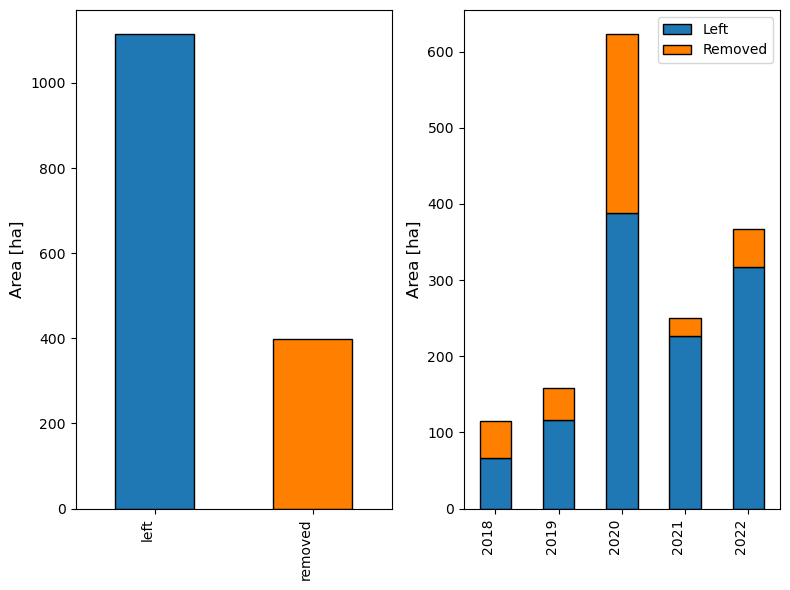

In [6]:
# Create a 1-row, 2-column subplot layout
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# 1. Plot total area per Removal (left plot)
Removals_total_area.plot(kind='bar', ax=ax[0], color=["#1f77b4", "#ff7f00"], edgecolor='black')
ax[0].set_xlabel("")
ax[0].set_ylabel("Area [ha]", fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), ha="right")

# 2. Pivot the data for better visualization
pivoted_data = Removal_year_areas.unstack(fill_value=0)

# Convert the Year index to integers
pivoted_data.index = pivoted_data.index.astype(int)

# Plot the stacked bar chart (right plot)
pivoted_data.plot(kind='bar', stacked=True, ax=ax[1], color=["#1f77b4", "#ff7f00"], edgecolor='black')
ax[1].set_xlabel("", fontsize=12)
ax[1].set_ylabel("Area [ha]", fontsize=12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), ha="right")

# Modify legend labels with capitalized text
ax[1].legend(title="", labels=[label.title() for label in pivoted_data.columns])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

    fccl  count  proportion
0    0.0  34117   22.773665
1    1.0    802    0.535348
2    2.0    547    0.365132
3    4.0      8    0.005340
4    6.0    320    0.213605
..   ...    ...         ...
73  76.0   1421    0.948541
74  77.0    527    0.351781
75  78.0   2089    1.394442
76  79.0   1594    1.064022
77  80.0   2195    1.465199

[78 rows x 3 columns]
    fccl  count  proportion
0    0.0  34117   22.773665
1    1.0    802    0.535348
2    2.0    547    0.365132
3    4.0      8    0.005340
4    6.0    320    0.213605
5    7.0   1165    0.777657
6    8.0    442    0.295042
7    9.0    649    0.433218
8   10.0    398    0.265672
9   11.0    587    0.391832
10  12.0    582    0.388495
11  13.0   1428    0.953214
12  14.0   1038    0.692882
13  15.0    734    0.489957
14  16.0    198    0.132168
15  17.0   1187    0.792342
16  18.0    230    0.153529
17  19.0   1656    1.105408
18  20.0   1832    1.222890
19  21.0    531    0.354451
20  22.0   1725    1.151466
21  23.0    781    0.5213

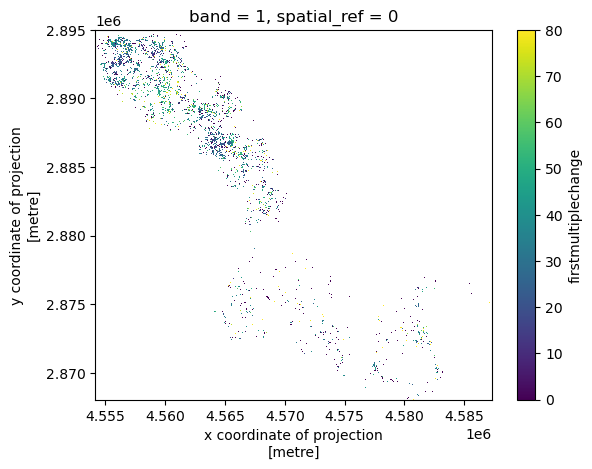

In [7]:
# Load the FCCL raster
fccl = rxr.open_rasterio(fccl_path, masked=True).squeeze()
fccl = fccl.rio.write_crs("EPSG:3035")  # Ensure CRS matches vector data

# Mask the FCCL dataset with the vector polygons
fccl_roi = fccl.rio.clip(ref.geometry, ref.crs, drop=True)
fccl_roi.name = "fccl"
fccl_roi.plot()

# Flatten and count occurrences of FCCL values
df = fccl_roi.to_dataframe().reset_index()

# count occurrences of each FCCL value
fccl_counts = df.groupby('fccl').size().reset_index(name='count')

# total amount of fccl 
total_fccl_count = fccl_counts['count'].sum() # this works because fccl 0 is included

# normalize to get proportions
fccl_counts['proportion'] = (fccl_counts['count'] / total_fccl_count)*100

# Sort values for better visualization
fccl_counts = fccl_counts.sort_values(by='fccl')

print(fccl_counts)

# Calculate total mapped area of FCCL in all years and between 2018-2022
a_all = fccl_counts.drop(index=fccl_counts[fccl_counts['fccl'] == 0].index[0])['proportion'].sum()
a_2018_22 = fccl_counts.loc[(fccl_counts['fccl'] >= 5) & (fccl_counts['fccl'] <= 64), 'proportion'].sum()

print(fccl_counts.to_string())
print(f"Total proportion mapped over all years: {a_all}")
print(f"Total proportion mapped between 2018 and 2022: {a_2018_22}")

    fccl  count  proportion
0    0.0  25728   17.148342
1    1.0    802    0.534553
2    2.0    547    0.364589
3    4.0      8    0.005332
4    6.0    320    0.213288
..   ...    ...         ...
73  76.0   1015    0.676522
74  77.0    374    0.249280
75  78.0   1289    0.859150
76  79.0   1107    0.737843
77  80.0   1504    1.002453

[78 rows x 3 columns]


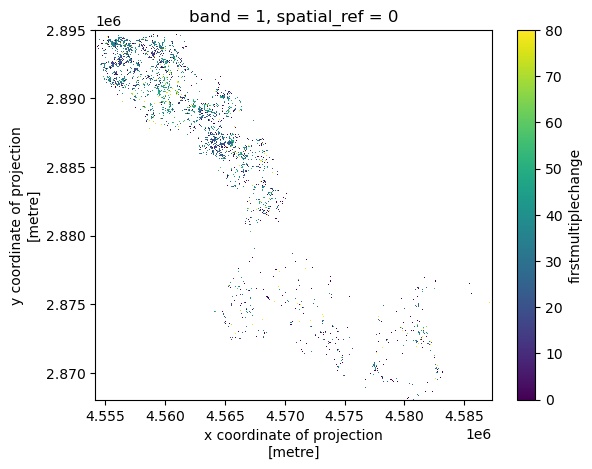

In [8]:
# load integrated FCCL/non-stand-replacing raster
fccl_integ = rxr.open_rasterio("./data/fccl_non_stand_rep_integrated_roi_bavarianforest.tif", masked=True).squeeze()
fccl_integ = fccl_integ.rio.write_crs("EPSG:3035")  # Ensure CRS matches vector data

# Mask the fccl_integ dataset with the vector polygons
fccl_integ_roi = fccl_integ.rio.clip(ref.geometry, ref.crs, drop=True)
fccl_integ_roi.name = "fccl"
fccl_integ_roi.plot()

# Flatten and count occurrences of fccl_integ values
df = fccl_integ_roi.to_dataframe().reset_index()

# count occurrences of each fccl_integ value
fccl_integ_counts = df.groupby('fccl').size().reset_index(name='count')

# total amount of fccl_integ 
total_fccl_integ_count = fccl_integ_counts['count'].sum() # this works because fccl_integ 0 is included

# normalize to get proportions
fccl_integ_counts['proportion'] = (fccl_integ_counts['count'] / total_fccl_integ_count)*100

# Sort values for better visualization
fccl_integ_counts = fccl_integ_counts.sort_values(by='fccl')

print(fccl_integ_counts)

In [9]:
# convert fccl to dates
start_date = pd.Timestamp("2017-09-01")
fccl_counts["date"] = fccl_counts["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)
fccl_integ_counts["date"] = fccl_integ_counts["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)

# Drop na
fccl_counts = fccl_counts.dropna(subset=["date"])
fccl_counts

# Plot timeline
plt.figure(figsize=(12, 6))
sns.lineplot(data=fccl_counts, x="date", y="proportion", marker="o", linestyle="-", color="#1f77b4")
#plt.title("FCCL Pixel Proportions Over Time")
plt.xlabel("")
plt.ylabel("FCCL Pixels [%]")
plt.xticks()
#plt.grid(True)
plt.show()

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Plot the cumulative timeline
# Filter out rows where fccl == 0
filtered_fccl_counts = fccl_counts[fccl_counts["fccl"] != 0].copy()
filtered_fccl_counts["cumulative_proportion"] = filtered_fccl_counts["proportion"].cumsum()
filtered_integ_fccl_counts = fccl_integ_counts[fccl_integ_counts["fccl"] != 0].copy()
filtered_integ_fccl_counts["cumulative_proportion"] = filtered_integ_fccl_counts["proportion"].cumsum()

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", marker="o", linestyle="-", color="#1f77b4")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.xticks()
#plt.grid(True)
plt.show()

In [ ]:
# Rasterize the DAM attribute onto the FCCL grid
dam_raster = rasterize(
    [(geom, dam) for geom, dam in zip(ref.geometry, ref["Removal_Code"])], 
    out_shape=fccl_roi.shape,
    fill=np.nan,  # Keep NaN where there's no data
    transform=fccl_roi.rio.transform(),
    dtype="float32"
)

# Convert to Xarray DataArray
dam_xr = xr.DataArray(dam_raster, coords=fccl_roi.coords, dims=fccl_roi.dims, name="Removal_Code")

# Combine FCCL and DAM into a single dataset
fccl_with_dam = xr.merge([fccl_roi, dam_xr])
df = fccl_with_dam.to_dataframe().reset_index()

# Combine FCCL and DAM into a single dataset
fccl_integ_with_dam = xr.merge([fccl_integ_roi, dam_xr])
df_integ = fccl_integ_with_dam.to_dataframe().reset_index()

In [ ]:
# Compute proportion of Removal_Code of all FCCL pixels mapped in the reference areas
start_date = pd.Timestamp("2017-09-01")

df["date"] = df["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)
df = df.dropna(subset=["date"])  # Remove NaN dates (FCCL = 0)
df_integ["date"] = df_integ["fccl"].apply(lambda x: start_date + pd.DateOffset(months=int(x)-1) if x > 0 else None)
df_integ = df_integ.dropna(subset=["date"])  # Remove NaN dates (FCCL = 0)

# calculate proportion of fccl
def compute_proportion(df_dam):
    df_counts = df_dam.groupby(["date", "fccl"]).size().reset_index(name="count")  # Keep fccl column
    df_counts["proportion"] = (df_counts["count"] / total_fccl_count)*100
    return df_counts

df_left_counts = compute_proportion(df[df["Removal_Code"] == 2])
df_removed_counts = compute_proportion(df[df["Removal_Code"] == 1])
df_integ_left_counts = compute_proportion(df_integ[df_integ["Removal_Code"] == 2])
df_integ_removed_counts = compute_proportion(df_integ[df_integ["Removal_Code"] == 1])

# Now, calculate cumulative proportions while excluding fccl == 0
def compute_cumulative(df_counts):
    df_counts = df_counts[df_counts["fccl"] != 0].copy()  # Exclude fccl == 0
    df_counts["cumulative_proportion"] = df_counts.sort_values("date")["proportion"].cumsum() 
    return df_counts

df_left_counts_cum = compute_cumulative(df_left_counts)
df_removed_counts_cum = compute_cumulative(df_removed_counts)
df_integ_left_counts_cum = compute_cumulative(df_integ_left_counts)
df_integ_removed_counts_cum = compute_cumulative(df_integ_removed_counts)

In [ ]:
# plot cummulative
plt.figure(figsize=(12, 6))

# Plot for FCCL and Non-Stand_Replacing disturbances
sns.lineplot(data=filtered_integ_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances (with non-stand-replacing)", color="darkgrey")
sns.lineplot(data=df_integ_left_counts_cum, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="Left", color="#1f78b4")
sns.lineplot(data=df_integ_removed_counts_cum, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="Removed", color="#ff7f00")


# Plot for ONLY FCCL
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances (only stand-replacing)", color="darkgrey", alpha=.2)
sns.lineplot(data=df_left_counts_cum, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="Left", color="#1f78b4", alpha=.2)
sns.lineplot(data=df_removed_counts_cum, x="date", y="cumulative_proportion", marker="o", linestyle="-", label="Removed", color="#ff7f00", alpha=.2)

#plt.title("FCCL Proportions Over Time by DAM Category (2017-2024)")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.yticks(np.arange(0, 81, 10)) 
plt.xticks()
plt.legend(loc="upper left")
#plt.grid(True)
plt.show()

Now, normalize by area of management categories

In [ ]:
# Normalize by the size of the management categories
management_categories = np.unique(management_raster[~np.isnan(management_raster)])  # Get unique management categories excluding NaN

# Calculate the total number of pixels mapped for each management category
total_management_pixels = {}
for management_category in management_categories:
    total_management_pixels[management_category] = np.sum(management_raster == management_category)  # Count pixels for this management category

# Now, total_management_pixels will have the total pixel count for each management category
print(total_management_pixels)

# Adjusted function to normalize proportions by the total mapped pixels for each management category
def compute_normalized_proportion(df_management, management_category, total_management_pixels):
    df_counts = df_management.groupby(["date", "fccl"]).size().reset_index(name="count")  # Keep fccl column
    df_counts["proportion"] = (df_counts["count"] / total_fccl_count) * 100  # Normalized by all FCCL pixels
    df_counts["normalized_proportion"] = (df_counts["count"] / total_management_pixels[management_category]) * 100  # Normalized by management pixels
    return df_counts

# Now calculate normalized proportions for each management category by passing the correct total pixels
df_management1_counts = compute_normalized_proportion(df[df["Removal_Code"] == 2], 2, total_management_pixels)
df_management2_counts = compute_normalized_proportion(df[df["Removal_Code"] == 1], 1, total_management_pixels)
df_integ_management1_counts = compute_normalized_proportion(df_integ[df_integ["Removal_Code"] == 2], 2, total_management_pixels)
df_integ_management2_counts = compute_normalized_proportion(df_integ[df_integ["Removal_Code"] == 1], 1, total_management_pixels)

# Compute cumulative normalized proportion (but ensuring it doesn't exceed 100% for each management)
def compute_cumulative(df_counts):
    df_counts = df_counts[df_counts["fccl"] != 0].copy()  # Exclude fccl == 0
    df_counts["cumulative_normalized_proportion"] = df_counts.sort_values("date")["normalized_proportion"].cumsum()
    df_counts["cumulative_normalized_proportion"] = df_counts["cumulative_normalized_proportion"].clip(upper=100)  # Ensure it doesn't go beyond 100%
    return df_counts

# Apply cumulative calculation
df_management_left_counts_normalized = compute_cumulative(df_management1_counts)
df_management2_removed_counts_normalized = compute_cumulative(df_management2_counts)
df_integ_management_left_counts_normalized = compute_cumulative(df_integ_management1_counts)
df_integ_management2_removed_counts_normalized = compute_cumulative(df_integ_management2_counts)

In [ ]:
# plot cummulative
plt.figure(figsize=(12, 6))

# Plot for FCCL and Non-Stand_Replacing disturbances
sns.lineplot(data=filtered_integ_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances (with non-stand-replacing)", color="darkgrey")
sns.lineplot(data=df_integ_management_left_counts_normalized, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="Left", color="#1f78b4")
sns.lineplot(data=df_integ_management2_removed_counts_normalized, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="Removed", color="#ff7f00")

# Plot for ONLY FCCL
sns.lineplot(data=filtered_fccl_counts, x="date", y="cumulative_proportion", linestyle="-", label="All disturbances (only stand-replacing)", color="darkgrey", alpha=.2)
sns.lineplot(data=df_management_left_counts_normalized, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="Left", color="#1f78b4", alpha=.2)
sns.lineplot(data=df_management2_removed_counts_normalized, x="date", y="cumulative_normalized_proportion", marker="o", linestyle="-", label="Removed", color="#ff7f00", alpha=.2)


#plt.title("FCCL Proportions Over Time by DAM Category (2017-2024)")
plt.xlabel("")
plt.ylabel("Cummulative FCCL Pixels [%]")
plt.yticks(np.arange(0, 81, 10)) 
plt.xticks()
plt.legend(loc="upper left")
#plt.grid(True)
plt.show()

Analyse how forest structure and fcsd change in the ref areas

In [13]:
# read mask layers
ref_bavarianforest_year_path = "./data/reproj/final/ref_bavarianforest_year.tif"
ref_bavarianforest_year = rxr.open_rasterio(ref_bavarianforest_year_path, masked=True, chunks='auto').squeeze()
ref_bavarianforest_year = ref_bavarianforest_year.rio.write_crs("EPSG:3035")

ref_bavarianforest_removalcode_path = "./data/reproj/final/ref_bavarianforest_removalcode.tif"
ref_bavarianforest_removalcode = rxr.open_rasterio(ref_bavarianforest_removalcode_path, masked=True, chunks='auto').squeeze()
ref_bavarianforest_removalcode = ref_bavarianforest_removalcode.rio.write_crs("EPSG:3035")

In [ ]:
# create a mask for each year and removal code
years = pd.date_range('2017', '2024', freq='YE')
ref_bavarianforest_2018_left_expanded = expand_years((ref_bavarianforest_year==2018).squeeze()&(ref_bavarianforest_removalcode==2).squeeze())
ref_bavarianforest_2019_left_expanded = expand_years((ref_bavarianforest_year==2019).squeeze()&(ref_bavarianforest_removalcode==2).squeeze())
ref_bavarianforest_2020_left_expanded = expand_years((ref_bavarianforest_year==2020).squeeze()&(ref_bavarianforest_removalcode==2).squeeze())
ref_bavarianforest_2021_left_expanded = expand_years((ref_bavarianforest_year==2021).squeeze()&(ref_bavarianforest_removalcode==2).squeeze())
ref_bavarianforest_2022_left_expanded = expand_years((ref_bavarianforest_year==2022).squeeze()&(ref_bavarianforest_removalcode==2).squeeze())

ref_bavarianforest_2018_removed_expanded = expand_years((ref_bavarianforest_year==2018).squeeze()&(ref_bavarianforest_removalcode==1).squeeze())
ref_bavarianforest_2019_removed_expanded = expand_years((ref_bavarianforest_year==2019).squeeze()&(ref_bavarianforest_removalcode==1).squeeze())
ref_bavarianforest_2020_removed_expanded = expand_years((ref_bavarianforest_year==2020).squeeze()&(ref_bavarianforest_removalcode==1).squeeze())
ref_bavarianforest_2021_removed_expanded = expand_years((ref_bavarianforest_year==2021).squeeze()&(ref_bavarianforest_removalcode==1).squeeze())
ref_bavarianforest_2022_removed_expanded = expand_years((ref_bavarianforest_year==2022).squeeze()&(ref_bavarianforest_removalcode==1).squeeze())

In [ ]:
# Add masks to dataset
d = d.assign(ref_bavarianforest_2018_left_expanded=ref_bavarianforest_2018_left_expanded)
d = d.assign(ref_bavarianforest_2019_left_expanded=ref_bavarianforest_2019_left_expanded)
d = d.assign(ref_bavarianforest_2020_left_expanded=ref_bavarianforest_2020_left_expanded)
d = d.assign(ref_bavarianforest_2021_left_expanded=ref_bavarianforest_2021_left_expanded)
d = d.assign(ref_bavarianforest_2022_left_expanded=ref_bavarianforest_2022_left_expanded)

d = d.assign(ref_bavarianforest_2018_removed_expanded=ref_bavarianforest_2018_removed_expanded)
d = d.assign(ref_bavarianforest_2019_removed_expanded=ref_bavarianforest_2019_removed_expanded)
d = d.assign(ref_bavarianforest_2020_removed_expanded=ref_bavarianforest_2020_removed_expanded)
d = d.assign(ref_bavarianforest_2021_removed_expanded=ref_bavarianforest_2021_removed_expanded)
d = d.assign(ref_bavarianforest_2022_removed_expanded=ref_bavarianforest_2022_removed_expanded)

In [ ]:
# clip to extent of roi
minx, miny, maxx, maxy = ref.total_bounds
d_subset = d.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 
d_subset

In [ ]:
d_subset.ref_bavarianforest_2018_removed_expanded.sel(time="2018").plot()

In [48]:
'''# export layers of interest of d_subset
# Assuming d_subset is already loaded as an xarray dataset
data = d_subset.fcsd_diff_gt25_2021.sel(time="2018").squeeze().drop_vars('time')

# convert boolean to integer
data_uint8 = data.astype("uint8")

# Define output filename
output_file = "./data/fcsd_diff_gt25_2021_roi_bavarianforest.tif"

# Extract x and y coordinates
x = data_uint8["x"].values
y = data_uint8["y"].values

# Compute affine transform (assumes regularly spaced grid)
transform = from_origin(x.min(), y.max(), abs(x[1] - x[0]), abs(y[1] - y[0]))

# Save as TIFF using rasterio
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=data_uint8.shape[0],
    width=data_uint8.shape[1],
    count=1,
    dtype=data_uint8.dtype,
    crs="EPSG:3035",  # Change to the correct CRS if different
    transform=transform
) as dst:
    dst.write(data_uint8.values, 1)

print(f"Saved as {output_file}")'''

'# export layers of interest of d_subset\n# Assuming d_subset is already loaded as an xarray dataset\ndata = d_subset.fcsd_diff_gt25_2021.sel(time="2018").squeeze().drop_vars(\'time\')\n\n# convert boolean to integer\ndata_uint8 = data.astype("uint8")\n\n# Define output filename\noutput_file = "./data/fcsd_diff_gt25_2021_roi_bavarianforest.tif"\n\n# Extract x and y coordinates\nx = data_uint8["x"].values\ny = data_uint8["y"].values\n\n# Compute affine transform (assumes regularly spaced grid)\ntransform = from_origin(x.min(), y.max(), abs(x[1] - x[0]), abs(y[1] - y[0]))\n\n# Save as TIFF using rasterio\nwith rasterio.open(\n    output_file,\n    "w",\n    driver="GTiff",\n    height=data_uint8.shape[0],\n    width=data_uint8.shape[1],\n    count=1,\n    dtype=data_uint8.dtype,\n    crs="EPSG:3035",  # Change to the correct CRS if different\n    transform=transform\n) as dst:\n    dst.write(data_uint8.values, 1)\n\nprint(f"Saved as {output_file}")'

In [49]:
# calculate descriptive stats for each mask

datasets = {
    'AGBD': d_subset.agbd,
    'TCC': d_subset.cover,
    'FHDI': d_subset.fhd_normal,
    'CH': d_subset.rh_95,
    'FCSD': d_subset.fcsd
}

stats_dict = {
    name: {
        'ref_bavarianforest_2018_left': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2018_left_expanded),
        'ref_bavarianforest_2019_left': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2019_left_expanded),
        'ref_bavarianforest_2020_left': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2020_left_expanded),
        'ref_bavarianforest_2021_left': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2021_left_expanded),
        'ref_bavarianforest_2022_left': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2022_left_expanded),
        'ref_bavarianforest_2018_removed': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2018_removed_expanded),
        'ref_bavarianforest_2019_removed': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2019_removed_expanded),
        'ref_bavarianforest_2020_removed': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2020_removed_expanded),
        'ref_bavarianforest_2021_removed': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2021_removed_expanded),
        'ref_bavarianforest_2022_removed': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2022_removed_expanded),
        'Dataset': name
    }
    for name, data in datasets.items()
}

In [50]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_bavarianforest_all.csv", index=False)
stats_df

,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,ref_bavarianforest_2018_left,210.872314,130.690964,143.524506,143.681351,143.095062,151.241806,150.031143,214.0,...,198.50,298.0,279.0,220.0,231.0,255.0,207.0,211.0,229.0,195.0
1,AGBD,ref_bavarianforest_2019_left,221.280716,179.290802,145.899017,149.604050,147.716644,157.001694,149.027435,224.0,...,190.50,282.5,280.5,233.0,212.0,213.0,201.0,225.0,225.0,204.0
2,AGBD,ref_bavarianforest_2020_left,220.806580,193.839584,194.501038,157.441620,149.946823,159.816269,146.304413,223.0,...,191.00,253.0,275.0,241.0,230.0,232.0,219.0,241.0,231.0,221.0
3,AGBD,ref_bavarianforest_2021_left,219.336121,194.291061,203.752777,184.032883,154.752533,165.046524,143.722198,222.0,...,199.00,240.5,266.5,241.0,242.0,233.0,233.0,226.0,238.0,209.0
4,AGBD,ref_bavarianforest_2022_left,216.370514,191.844208,203.760803,194.165390,167.821579,160.705688,136.344391,220.0,...,232.50,223.5,244.0,252.0,261.0,241.0,234.0,208.0,229.0,193.0
5,AGBD,ref_bavarianforest_2018_removed,197.142532,98.182030,106.449524,108.108337,115.871796,126.528526,127.293602,203.0,...,228.50,289.5,283.0,257.0,231.0,235.0,201.0,228.0,222.0,191.0
6,AGBD,ref_bavarianforest_2019_removed,217.404434,172.417496,114.729240,97.824020,108.324020,110.631851,112.193733,223.0,...,224.50,262.5,271.0,255.0,238.0,215.0,210.0,223.0,227.0,202.0
7,AGBD,ref_bavarianforest_2020_removed,220.265137,194.492416,191.941681,122.375237,106.679771,109.199966,113.759506,225.0,...,223.50,259.0,273.0,259.0,276.0,247.0,228.0,242.0,236.0,209.0
8,AGBD,ref_bavarianforest_2021_removed,223.016495,205.733276,208.951935,187.871826,128.497650,129.193207,130.798782,225.0,...,222.50,294.0,282.0,221.0,223.0,245.0,192.0,220.0,221.0,214.0
9,AGBD,ref_bavarianforest_2022_removed,224.180649,199.535141,206.022552,195.734619,166.105759,117.109047,118.457191,227.0,...,268.50,271.5,289.0,252.0,228.0,236.0,214.0,231.0,236.0,218.0


Analyse disturbance sizes

In [11]:
ref_bavarianforest_year_path = "./data/reproj/final/Bavarian_NP_2020_removed_size.tif"
ref_bavarianforest_year = rxr.open_rasterio(ref_bavarianforest_year_path, masked=True, chunks='auto').squeeze()
ref_bavarianforest_year = ref_bavarianforest_year.rio.write_crs("EPSG:3035")

In [49]:
# create a mask for each year and removal code
years = pd.date_range('2017', '2024', freq='YE')
ref_bavarianforest_2020_removed_smallscale_expanded = expand_years((ref_bavarianforest_year<5).squeeze())
ref_bavarianforest_2020_removed_largescale_expanded = expand_years((ref_bavarianforest_year>=5).squeeze())

# Add masks to dataset
d = d.assign(ref_bavarianforest_2020_removed_smallscale=ref_bavarianforest_2020_removed_smallscale_expanded)
d = d.assign(ref_bavarianforest_2020_removed_largescale=ref_bavarianforest_2020_removed_largescale_expanded)

In [50]:
# clip to extent of roi
minx, miny, maxx, maxy = ref.total_bounds
d_subset = d.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 
d_subset

<xarray.Dataset>
Dimensions:                                     (x: 3319, y: 2698, time: 7)
Coordinates:
    band                                        int64 1
  * x                                           (x) float64 4.554e+06 ... 4.5...
  * y                                           (y) float64 2.895e+06 ... 2.8...
    spatial_ref                                 int64 0
  * time                                        (time) datetime64[ns] 2017-12...
Data variables:
    agbd                                        (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    cover                                       (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    fhd_normal                                  (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    rh_95                                       (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    fccl                                        (time, y, x) float64 dask.array<chunksize=(1, 481, 3319), meta=np.ndarray>
    fcsd                                        (time, y, x) float32 dask.array<chunksize=(2, 964, 3319), meta=np.ndarray>
    ref_bavarianforest_2020_removed_smallscale  (y, x, time) bool dask.array<chunksize=(481, 3319, 7), meta=np.ndarray>
    ref_bavarianforest_2020_removed_largescale  (y, x, time) bool dask.array<chunksize=(481, 3319, 7), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

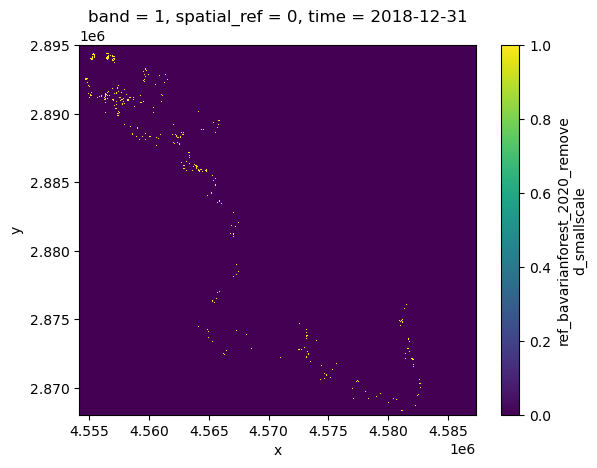

In [51]:
d_subset.ref_bavarianforest_2020_removed_smallscale.sel(time="2018").plot()

In [52]:
# calculate descriptive stats for each mask

datasets = {
    'AGBD': d_subset.agbd,
    'TCC': d_subset.cover,
    'FHDI': d_subset.fhd_normal,
    'CH': d_subset.rh_95,
    'FCSD': d_subset.fcsd
}

stats_dict = {
    name: {
        'ref_bavarianforest_2020_removed_smallscale': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2020_removed_smallscale),
        'ref_bavarianforest_2020_removed_largescale': compute_descriptive_statistics(data, mask=d_subset.ref_bavarianforest_2020_removed_largescale),
        'Dataset': name
    }
    for name, data in datasets.items()
}

/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [53]:
# write to dataframe
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
records = []
for dataset_name, mask_data in stats_dict.items():
    for mask, stats in mask_data.items():
        # Skip the 'Dataset' entry to avoid including it as a separate row
        if mask == 'Dataset':
            continue
        # Create a record for each dataset and mask combination
        record = {
            "Dataset": dataset_name,
            "mask": mask,
            **stats
        }
        records.append(record)
stats_df = pd.DataFrame.from_records(records)
expanded_columns = {}
for stat in ['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range']:
    for year in years:
        new_col_name = f"{stat}_{year}"
        expanded_columns[new_col_name] = stats_df[stat].apply(
            lambda x: x[year - 2017] if isinstance(x, (np.ndarray, list)) else None
        )
for col, values in expanded_columns.items():
    stats_df[col] = values
stats_df.drop(columns=['mean', 'median', 'std_dev', 'min', 'max', 'q1', 'q3', 'iqr', 'outlier_min', 'outlier_max', 'range'], inplace=True)
stats_df.to_csv("./data/descriptive_stats_bavarianforest_2020_removed_size.csv", index=False)
stats_df

/dss/dsstbyfs01/pn56su/pn56su-dss-0020/opt/micromamba/envs/terrabyte_base/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,Dataset,mask,mean_2017,mean_2018,mean_2019,mean_2020,mean_2021,mean_2022,mean_2023,median_2017,...,outlier_max_2021,outlier_max_2022,outlier_max_2023,range_2017,range_2018,range_2019,range_2020,range_2021,range_2022,range_2023
0,AGBD,ref_bavarianforest_2020_removed_smallscale,219.384613,193.704071,192.787735,123.929825,108.679306,112.440796,116.735283,224.0,...,224.0,266.0,276.0,259.0,270.0,247.0,228.0,242.0,241.0,209.0
1,AGBD,ref_bavarianforest_2020_removed_largescale,227.486801,201.489166,186.643265,109.327995,89.265312,80.157402,86.224319,229.0,...,194.5,130.0,159.5,229.0,216.0,190.0,190.0,163.0,191.0,166.0
2,TCC,ref_bavarianforest_2020_removed_smallscale,57.971912,53.959057,52.574890,35.475880,27.420050,39.156425,41.722630,59.0,...,59.0,79.0,74.0,58.0,66.0,71.0,67.0,65.0,70.0,63.0
3,TCC,ref_bavarianforest_2020_removed_largescale,57.452404,52.670593,49.933552,28.895382,20.991989,30.089539,35.531574,57.0,...,38.5,53.0,61.5,40.0,56.0,51.0,58.0,50.0,56.0,51.0
4,FHDI,ref_bavarianforest_2020_removed_smallscale,285.835693,296.951874,289.160309,250.248779,218.597168,245.265762,246.688782,291.0,...,323.0,332.5,346.5,142.0,152.0,148.0,174.0,181.0,178.0,161.0
5,FHDI,ref_bavarianforest_2020_removed_largescale,289.567871,302.031586,289.196045,236.430252,199.335526,224.698395,229.648911,292.0,...,254.5,285.5,284.0,85.0,89.0,121.0,148.0,149.0,135.0,146.0
6,CH,ref_bavarianforest_2020_removed_smallscale,25.990421,24.469082,23.072357,16.865013,14.214045,14.734491,17.212059,27.0,...,26.0,28.5,31.5,26.0,26.0,25.0,26.0,27.0,26.0,23.0
7,CH,ref_bavarianforest_2020_removed_largescale,27.102262,25.325636,22.824694,14.520264,11.865221,11.309142,14.703582,28.0,...,19.0,21.5,22.0,19.0,20.0,22.0,22.0,19.0,22.0,20.0
8,FCSD,ref_bavarianforest_2020_removed_smallscale,NaN,1535.753296,3178.226807,3772.754395,2004.708130,NaN,NaN,NaN,...,6597.0,NaN,NaN,NaN,8469.0,9522.0,9520.0,9472.0,NaN,NaN
9,FCSD,ref_bavarianforest_2020_removed_largescale,NaN,1508.164062,3824.286865,4550.469727,1558.009766,NaN,NaN,NaN,...,5365.5,NaN,NaN,NaN,5506.0,9248.0,9182.0,9089.0,NaN,NaN


Calculate precision and recall

In [14]:
years = pd.date_range('2017', '2024', freq='YE')

# Create zero-filled arrays for the years 2017, 2018, 2022, and 2023
zero_array = xr.full_like(d.fccl.isel(time=0).drop_vars("time"), 0)

ref_bavarianforest_2017_left = zero_array.assign_coords(time=years[0])
ref_bavarianforest_2018_left = (ref_bavarianforest_year==2018).squeeze()&(ref_bavarianforest_removalcode==2).squeeze().assign_coords(time=years[1])
ref_bavarianforest_2019_left = (ref_bavarianforest_year==2019).squeeze()&(ref_bavarianforest_removalcode==2).squeeze().assign_coords(time=years[2])
ref_bavarianforest_2020_left = (ref_bavarianforest_year==2020).squeeze()&(ref_bavarianforest_removalcode==2).squeeze().assign_coords(time=years[3])
ref_bavarianforest_2021_left = (ref_bavarianforest_year==2021).squeeze()&(ref_bavarianforest_removalcode==2).squeeze().assign_coords(time=years[4])
ref_bavarianforest_2022_left = (ref_bavarianforest_year==2022).squeeze()&(ref_bavarianforest_removalcode==2).squeeze().assign_coords(time=years[5])
ref_bavarianforest_2023_left = zero_array.assign_coords(time=years[6])
ref_bavarianforest_left = xr.concat([ref_bavarianforest_2017_left,ref_bavarianforest_2018_left,ref_bavarianforest_2019_left,ref_bavarianforest_2020_left,ref_bavarianforest_2021_left,ref_bavarianforest_2022_left,ref_bavarianforest_2023_left], dim='time')

ref_bavarianforest_2017_removed = zero_array.assign_coords(time=years[0])
ref_bavarianforest_2018_removed = (ref_bavarianforest_year==2018).squeeze()&(ref_bavarianforest_removalcode==1).squeeze().assign_coords(time=years[1])
ref_bavarianforest_2019_removed = (ref_bavarianforest_year==2019).squeeze()&(ref_bavarianforest_removalcode==1).squeeze().assign_coords(time=years[2])
ref_bavarianforest_2020_removed = (ref_bavarianforest_year==2020).squeeze()&(ref_bavarianforest_removalcode==1).squeeze().assign_coords(time=years[3])
ref_bavarianforest_2021_removed = (ref_bavarianforest_year==2021).squeeze()&(ref_bavarianforest_removalcode==1).squeeze().assign_coords(time=years[4])
ref_bavarianforest_2022_removed = (ref_bavarianforest_year==2022).squeeze()&(ref_bavarianforest_removalcode==1).squeeze().assign_coords(time=years[5])
ref_bavarianforest_2023_removed = zero_array.assign_coords(time=years[6])
ref_bavarianforest_removed = xr.concat([ref_bavarianforest_2017_removed,ref_bavarianforest_2018_removed,ref_bavarianforest_2019_removed,ref_bavarianforest_2020_removed,ref_bavarianforest_2021_removed,ref_bavarianforest_2022_removed,ref_bavarianforest_2023_removed], dim='time')

# Add the new variable to the dataset
d = d.assign(ref_bavarianforest_left=ref_bavarianforest_left)
d = d.assign(ref_bavarianforest_removed=ref_bavarianforest_removed)

In [15]:
# create masks for years 2019-2021, 2020-2019 or 2021-2020
years = pd.date_range('2017', '2024', freq='YE')

# Combine the conditions
# mask for stand-rep disturbances
fccl_mask_2017 = (d.fccl.sel(time="2017") > 0).squeeze().drop_vars('time')
fccl_mask_2018 = (d.fccl.sel(time="2018") > 0).squeeze().drop_vars('time')
fccl_mask_2019 = (d.fccl.sel(time="2019") > 0).squeeze().drop_vars('time')
fccl_mask_2020 = (d.fccl.sel(time="2020") > 0).squeeze().drop_vars('time')
fccl_mask_2021 = (d.fccl.sel(time="2021") > 0).squeeze().drop_vars('time')

# mask for non-stand-rep disturbances in 2019
fccl_mask_2017_2019 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019
fcsd_diff_gt25_2019_nonexpanded = (
    ((d.fcsd.sel(time='2019').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2018').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2019
)

# mask for non-stand-rep disturbances in 2020
fccl_mask_2017_2020 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019 | fccl_mask_2020
fcsd_diff_gt25_2020_nonexpanded = (
    ((d.fcsd.sel(time='2020').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2019').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2020
)

# mask for non-stand-rep disturbances in 2019
fccl_mask_2017_2021 = fccl_mask_2017 | fccl_mask_2018 | fccl_mask_2019 | fccl_mask_2020 | fccl_mask_2021
fcsd_diff_gt25_2021_nonexpanded = (
    ((d.fcsd.sel(time='2021').squeeze().drop_vars('time') - 
      d.fcsd.sel(time='2020').squeeze().drop_vars('time')) > 2500) & 
    ~fccl_mask_2017_2021
)

# expand years
fcsd_diff_gt25_2019 = expand_years(fcsd_diff_gt25_2019_nonexpanded)
fcsd_diff_gt25_2020 = expand_years(fcsd_diff_gt25_2020_nonexpanded)
fcsd_diff_gt25_2021 = expand_years(fcsd_diff_gt25_2021_nonexpanded)

d = d.assign(fcsd_diff_gt25_2019=fcsd_diff_gt25_2019)
d = d.assign(fcsd_diff_gt25_2020=fcsd_diff_gt25_2020)
d = d.assign(fcsd_diff_gt25_2021=fcsd_diff_gt25_2021)

In [16]:
# Extract required data for 2019, 2020, and 2021
non_stand_rep_2017 = zero_array.assign_coords(time=years[0])
non_stand_rep_2018 = zero_array.assign_coords(time=years[1])
non_stand_rep_2019 = d.fcsd_diff_gt25_2019.sel(time="2017").drop_vars("time").squeeze().assign_coords(time=years[2])
non_stand_rep_2020 = d.fcsd_diff_gt25_2020.sel(time="2017").drop_vars("time").squeeze().assign_coords(time=years[3])
non_stand_rep_2021 = d.fcsd_diff_gt25_2021.sel(time="2017").drop_vars("time").squeeze().assign_coords(time=years[4])
non_stand_rep_2022 = zero_array.assign_coords(time=years[5])
non_stand_rep_2023 = zero_array.assign_coords(time=years[6])
non_stand_rep = xr.concat([non_stand_rep_2017,non_stand_rep_2018,non_stand_rep_2019,non_stand_rep_2020,non_stand_rep_2021,non_stand_rep_2022,non_stand_rep_2023], dim='time')

# Add the new variable to the dataset
d = d.assign(non_stand_rep=non_stand_rep)

In [17]:
# clip to extent of roi
minx, miny, maxx, maxy = ref.total_bounds
d_subset = d.sel(x=slice(minx, maxx), y=slice(maxy, miny)) 
d_subset

<xarray.Dataset>
Dimensions:                     (x: 3319, y: 2698, time: 7)
Coordinates:
    band                        int64 1
  * x                           (x) float64 4.554e+06 4.554e+06 ... 4.587e+06
  * y                           (y) float64 2.895e+06 2.895e+06 ... 2.868e+06
    spatial_ref                 int64 0
  * time                        (time) datetime64[ns] 2017-12-31 ... 2023-12-31
Data variables:
    agbd                        (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    cover                       (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    fhd_normal                  (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    rh_95                       (time, y, x) float32 dask.array<chunksize=(1, 964, 3319), meta=np.ndarray>
    fccl                        (time, y, x) float64 dask.array<chunksize=(1, 481, 3319), meta=np.ndarray>
    fcsd                        (time, y, x) float32 dask.array<chunksize=(2, 964, 3319), meta=np.ndarray>
    ref_bavarianforest_left     (time, y, x) float64 dask.array<chunksize=(1, 481, 3319), meta=np.ndarray>
    ref_bavarianforest_removed  (time, y, x) float64 dask.array<chunksize=(1, 481, 3319), meta=np.ndarray>
    fcsd_diff_gt25_2019         (y, x, time) bool dask.array<chunksize=(481, 3319, 7), meta=np.ndarray>
    fcsd_diff_gt25_2020         (y, x, time) bool dask.array<chunksize=(481, 3319, 7), meta=np.ndarray>
    fcsd_diff_gt25_2021         (y, x, time) bool dask.array<chunksize=(481, 3319, 7), meta=np.ndarray>
    non_stand_rep               (time, y, x) float64 dask.array<chunksize=(1, 481, 3319), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [18]:
# clip d_subset by Shapefile of Bavarian Forest
Bavarian_NP = gpd.read_file("./data/Bavarian_NP.shp")
Bavarian_NP = Bavarian_NP.to_crs(epsg=3035)
d_Bavarian_NP = d_subset.rio.clip(Bavarian_NP.geometry, Bavarian_NP.crs)

In [19]:
# Condition where ref_bavarianforest_left > 0 is mapped in any year
ref_any_year_left = (d_subset.ref_bavarianforest_left > 0).sel(time=slice("2018", "2022")).any(dim="time")

# Condition where ref_bavarianforest_left > 0 is mapped in the correct year
ref_correct_year_left = d_subset.ref_bavarianforest_left > 0

# Condition where ref_bavarianforest_removed > 0 is mapped in any year
ref_any_year_removed = (d_subset.ref_bavarianforest_removed > 0).sel(time=slice("2018", "2022")).any(dim="time")

# Condition where ref_bavarianforest_removed > 0 is mapped in the correct year
ref_correct_year_removed = d_subset.ref_bavarianforest_removed > 0

# Reference data
total_ref_removed = ref_any_year_removed.sum().compute()
total_ref_left = ref_any_year_left.sum().compute()

# Condition where fccl is mapped between 2018 and 2022
fccl_18_22 = (d_subset.fccl > 0).sel(time=slice("2018", "2022")).any(dim="time")

# Condition where fccl is mapped between 2018 and 2022
fccl_allyears = (d_subset.fccl > 0).any(dim="time")

# Condition where non_stand_rep is mapped
non_stand_rep = (d_subset.non_stand_rep > 0).sel(time=slice("2018", "2022")).any(dim="time")

# Reference data
total_ref = total_ref_removed + total_ref_left

In [21]:
# of only fccl independant of management and time
true_positives = ((fccl_18_22) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_18_22) & ~(ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.36231692302037966
0.7451379073160039


In [22]:
# compute precision and recall

# independant of management and time
true_positives = ((fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_18_22 | non_stand_rep) & ~(ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.2741864342157398
0.7654334729314207


In [23]:
# of only fccl (all years) independant of management and time
true_positives = ((fccl_allyears) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_allyears) & ~(ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_allyears | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.26402566304164454
0.7840830915562468


In [24]:
# independant of management and time
true_positives = ((fccl_18_22) & (ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_18_22) & ~(ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_18_22) & (ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.09904257860595035
0.7067215651307335


In [25]:
# independant of management and time
true_positives = ((non_stand_rep) & (ref_any_year_left)).sum().compute().item()
false_positives = ((non_stand_rep) & ~(ref_any_year_left)).sum().compute().item()
false_negatives = (~(non_stand_rep) & (ref_any_year_left)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.09845737815745806
0.15168299957392417


In [26]:
# check if years are mapped correctly
non_stand_rep = (d_subset.non_stand_rep > 0).sel(time=slice("2018", "2022"))
fccl_18_22 = (d_subset.fccl > 0).sel(time=slice("2018", "2022"))
ref_any_year_removed = (d_subset.ref_bavarianforest_removed > 0).sel(time=slice("2018", "2022"))
ref_any_year_left = (d_subset.ref_bavarianforest_left > 0).sel(time=slice("2018", "2022"))

true_positives = ((fccl_18_22) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_18_22) & ~(ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

true_positives = ((fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_positives = ((fccl_18_22 | non_stand_rep) & ~(ref_any_year_left | ref_any_year_removed)).sum().compute().item()
false_negatives = (~(fccl_18_22 | non_stand_rep) & (ref_any_year_left | ref_any_year_removed)).sum().compute().item()

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(precision)
print(recall)

0.16565779076391568
0.33224239475759787
0.12126963992799929
0.3697911594061748


# Plot summary of results

Table taken from Appendix

In [3]:
# Data for TCC, CH, AGBD, FHDI, and FCSD
data = [
    ["Stand-replacing", "Pre-disturbance", -8, -8, -11, 2, 70],
    ["Stand-replacing", "Disturbance", -33, -20, -32, -14, 34],
    ["Stand-replacing", "Disturbance and Subsequent Year", -48, -46, -52, -22, -12],
    ["Stand-replacing", "Post-disturbance", 28, 16, 7, 5, -42],
    ["Stand-replacing", "Entire Time Period", -38, -43, -54, -17, 22],
    ["Non-stand-replacing", "Pre-disturbance", -1, -5, -6, 3, 14],
    ["Non-stand-replacing", "Disturbance", -11, -5, -10, -3, 212],
    ["Non-stand-replacing", "Disturbance and Subsequent Year", -19, -16, -22, -7, 74],
    ["Non-stand-replacing", "Post-disturbance", 9, 4, 3, 1, -30],
    ["Non-stand-replacing", "Entire Time Period", -14, -20, -29, -4, 78],
    ["Wind/Bark Beetle", "Pre-disturbance", -7, -7, -7, 7, 68],
    ["Wind/Bark Beetle", "Disturbance", -32, -25, -30, -13, 58],
    ["Wind/Bark Beetle", "Disturbance and Subsequent Year", -60, -55, -60, -30, -30],
    ["Wind/Bark Beetle", "Post-disturbance", 39, 15, -5, 10, None],
    ["Wind/Bark Beetle", "Entire Time Period", -49, -52, -64, -23, 22],
    ["Fire", "Pre-disturbance", -18, -6, -18, -3, 85],
    ["Fire", "Disturbance", -20, -11, -7, -2, 10],
    ["Fire", "Disturbance and Subsequent Year", -33, -18, -17, -7, -32],
    ["Fire", "Post-disturbance", 33, -4, -21, -5, None],
    ["Fire", "Entire Time Period", -27, -26, -46, -14, 26],
    ["Harvest", "Pre-disturbance", -12, -12, -15, 0, 53],
    ["Harvest", "Disturbance", -31, -24, -33, -11, 12],
    ["Harvest", "Disturbance and Subsequent Year", -44, -40, -45, -20, 40],
    ["Harvest", "Post-disturbance", 29, 11, 1, 6, None],
    ["Harvest", "Entire Time Period", -37, -41, -53, -15, -8],
    ["Small-scale", "Pre-disturbance", -9, -10, -12, 1, 53],
    ["Small-scale", "Disturbance", -28, -22, -30, -10, 26],
    ["Small-scale", "Disturbance and Subsequent Year", -44, -40, -45, -21, -30],
    ["Small-scale", "Post-disturbance", 26, 11, 0, 6, None],
    ["Small-scale", "Entire Time Period", -35, -40, -51, -15, 8],
    ["Large-Scale", "Pre-disturbance", -6, -6, -5, 1, 63],
    ["Large-Scale", "Disturbance", -30, -23, -28, -12, 79],
    ["Large-Scale", "Disturbance and Subsequent Year", -65, -60, -64, -34, -24],
    ["Large-Scale", "Post-disturbance", 46, 19, -6, 12, None],
    ["Large-Scale", "Entire Time Period", -61, -55, -67, -25, 23],
]

# Creating the dataframe
df = pd.DataFrame(data, columns=["Disturbance Pattern", "Time Period", "TCC", "CH", "AGBD", "FHDI", "FCSD"])
time_order = ["Pre-disturbance", "Disturbance", "Disturbance and Subsequent Year", "Post-disturbance", "Entire Time Period"]
main_time_order = time_order[:-1]  # exclude 'Entire Time Period' for smoothing
df["Time Period"] = pd.Categorical(df["Time Period"], categories=time_order, ordered=True)

df

,Disturbance Pattern,Time Period,TCC,CH,AGBD,FHDI,FCSD
0,Stand-replacing,Pre-disturbance,-8,-8,-11,2,70.0
1,Stand-replacing,Disturbance,-33,-20,-32,-14,34.0
2,Stand-replacing,Disturbance and Subsequent Year,-48,-46,-52,-22,-12.0
3,Stand-replacing,Post-disturbance,28,16,7,5,-42.0
4,Stand-replacing,Entire Time Period,-38,-43,-54,-17,22.0
5,Non-stand-replacing,Pre-disturbance,-1,-5,-6,3,14.0
6,Non-stand-replacing,Disturbance,-11,-5,-10,-3,212.0
7,Non-stand-replacing,Disturbance and Subsequent Year,-19,-16,-22,-7,74.0
8,Non-stand-replacing,Post-disturbance,9,4,3,1,-30.0
9,Non-stand-replacing,Entire Time Period,-14,-20,-29,-4,78.0


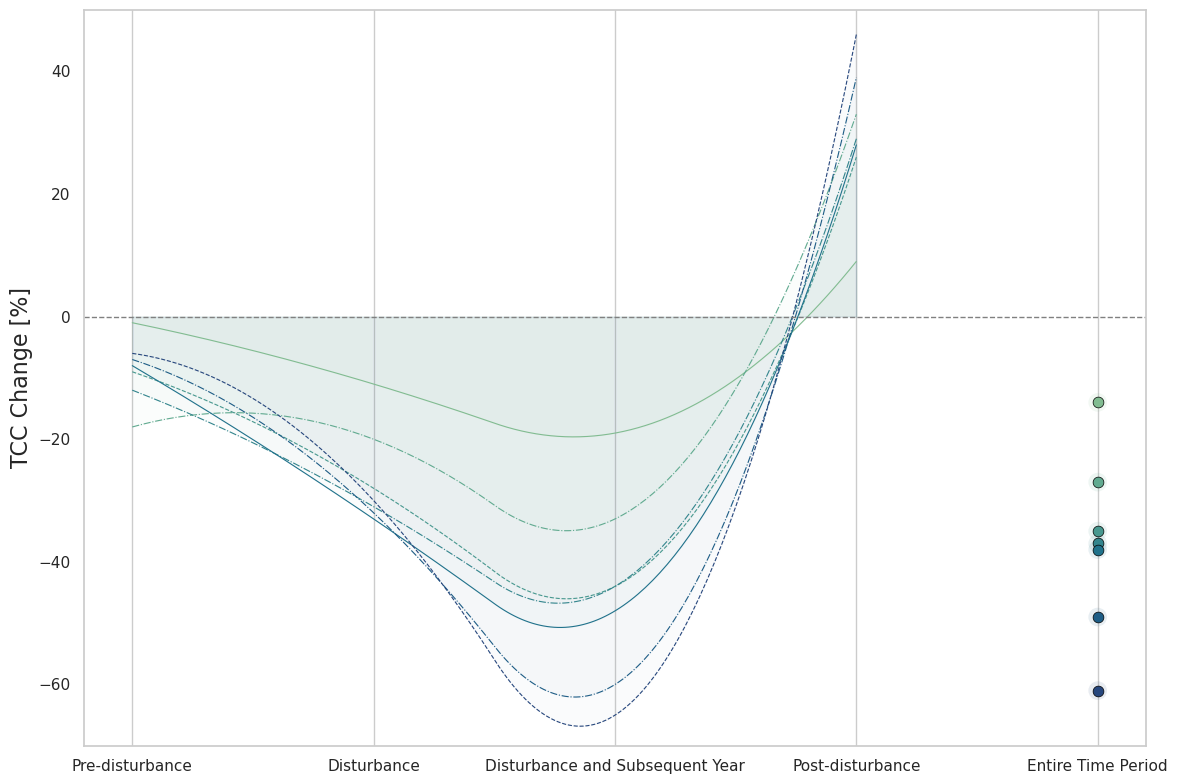

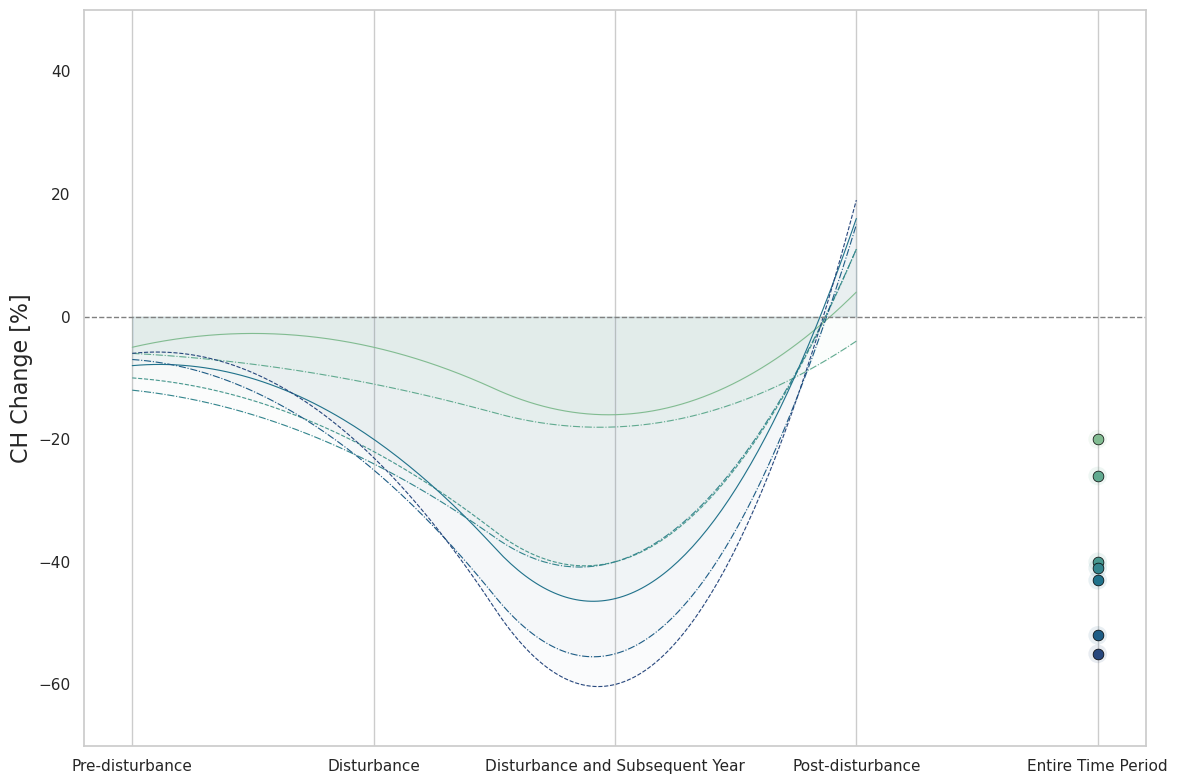

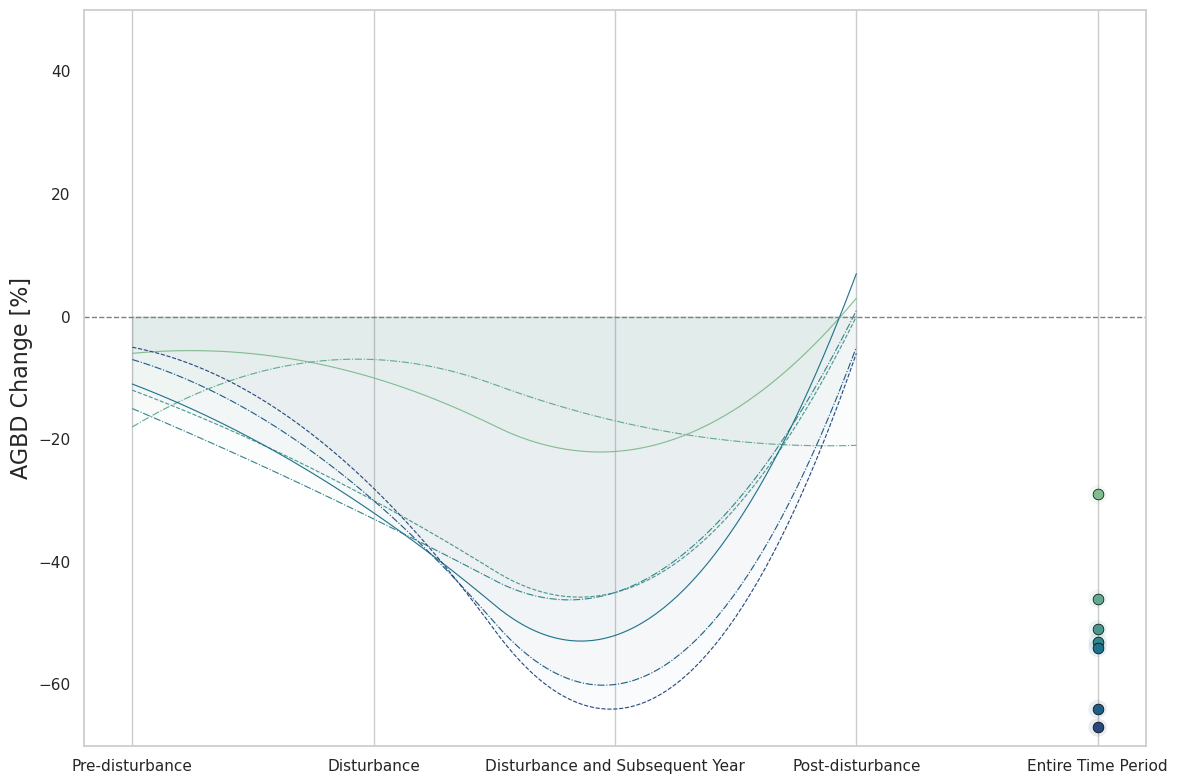

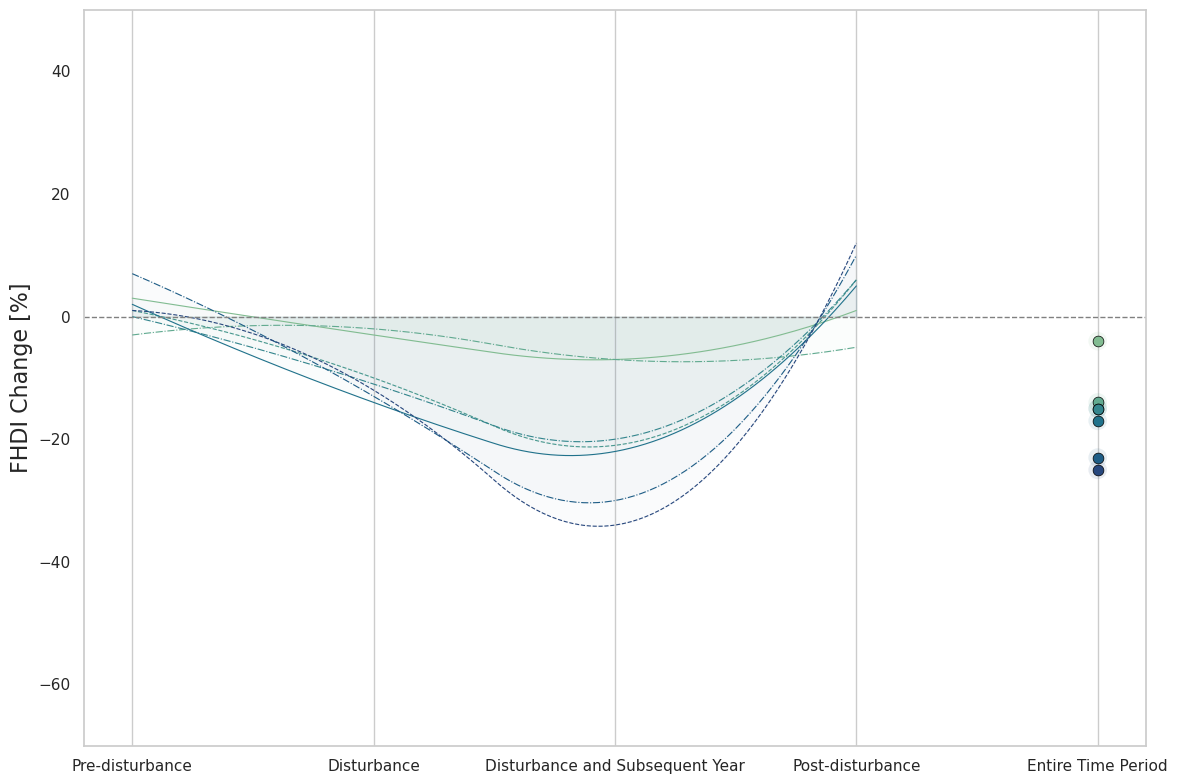

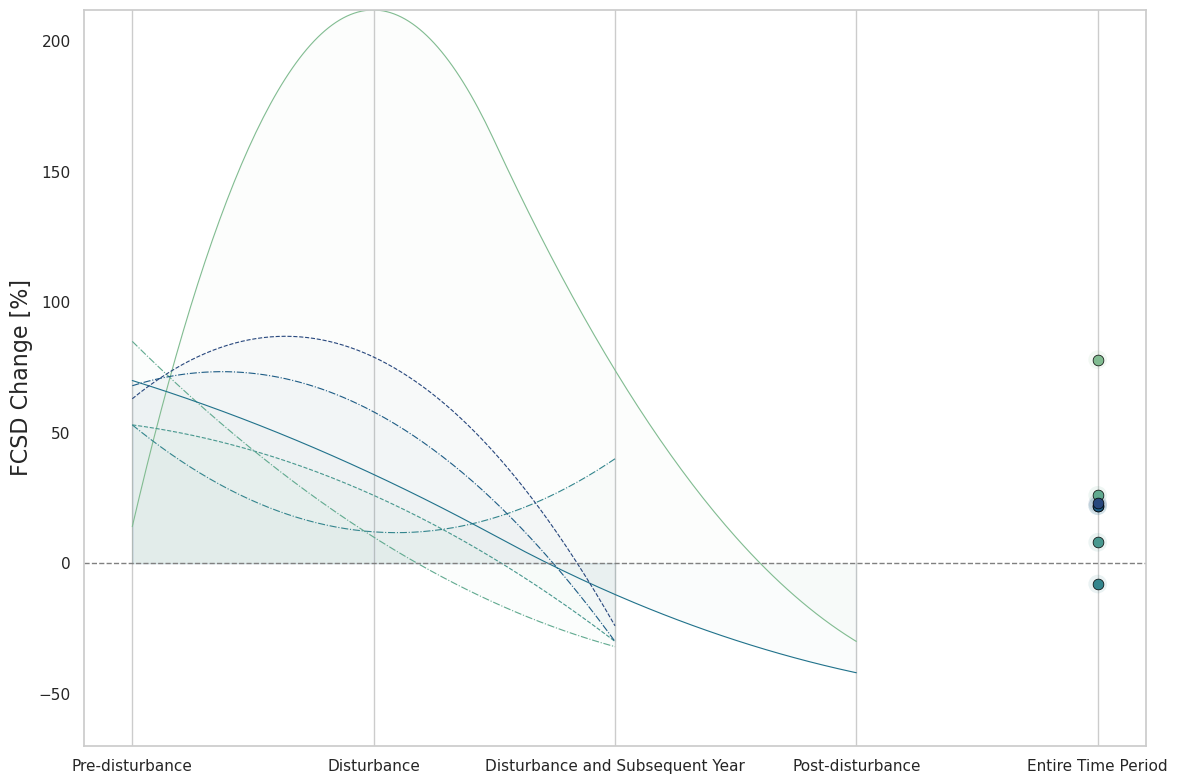

In [16]:
# Smoothing function
def smooth_line(x, y, points=200):
    if len(x) < 2:  # Check if there are enough points for smoothing
        return x, y
    xnew = np.linspace(x.min(), x.max(), points)
    spline = make_interp_spline(x, y, k=2)
    ynew = spline(xnew)
    return xnew, ynew

# Sort patterns by Entire Time Period value (descending = best first)
entire_sorted = (
    df[df["Time Period"] == "Entire Time Period"]
    .sort_values("TCC", ascending=False)
    ["Disturbance Pattern"]
    .tolist()
)

# Line style dictionary
line_styles = {
    "Stand-replacing": "-",  # Solid line
    "Non-stand-replacing": "-",  # Solid line
    "Small-scale": "--",  # Dashed line
    "Large-Scale": "--",  # Dashed line
    "Fire": "-.",  # Dash-dot line
    "Harvest": "-.",  # Dash-dot line
    "Wind/Bark Beetle": "-.",  # Dash-dot line
}

# List of variables to plot
variables = ["TCC", "CH", "AGBD", "FHDI", "FCSD"]

# Plotting loop for each variable
for var in variables:
    if var not in df.columns:
        print(f"Skipping plot for {var} as it is missing.")
        continue
    
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    plt.gca().yaxis.grid(False)
    palette = sns.color_palette("crest", n_colors=len(entire_sorted))
    x_vals = np.arange(len(main_time_order))

    # Loop through each disturbance pattern and plot
    for i, pattern in enumerate(entire_sorted):
        color = palette[i]
        linestyle = line_styles.get(pattern, "-")  # Default to solid line if not in dictionary

        # Line data (skip NaN values)
        sub_main = df[(df["Disturbance Pattern"] == pattern) & (df["Time Period"].isin(main_time_order))]
        x = x_vals
        y = sub_main[var].dropna().values  # Skip NaN values here

        if len(y) < 2:  # Skip smoothing if not enough data points
            plt.plot(x[:len(y)], y, color=color, linewidth=0.8, linestyle=linestyle, label=pattern)
            continue

        x_smooth, y_smooth = smooth_line(np.array(x[:len(y)]), y)  # Adjust x-values to match y's length after dropna

        # Plot line + fill
        plt.fill_between(x_smooth, y_smooth, 0, alpha=0.02, color=color)
        plt.plot(x_smooth, y_smooth, color=color, linewidth=0.8, linestyle=linestyle, label=pattern)

        # Entire Time Period point (skip NaN values)
        entire_val = df[(df["Disturbance Pattern"] == pattern) & (df["Time Period"] == "Entire Time Period")][var].dropna()
        if not entire_val.empty:
            x_entire = len(main_time_order)
            y_entire = entire_val.values[0]
            plt.scatter(x_entire, y_entire, s=180, color=color, alpha=0.1, edgecolor='none', zorder=3)
            plt.scatter(x_entire, y_entire, s=60, color=color, edgecolor='black', linewidth=0.5, zorder=4)

    # Final layout for each plot
    plt.xticks(np.arange(len(time_order)), time_order)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel(f"{var} Change [%]", fontsize=16)
    plt.ylim(min(df[var].min(), -70), max(df[var].max(), 50))
    plt.tight_layout()

    # Bold title for legend
    bold_title = FontProperties(weight='bold')
    #plt.legend(title="Disturbance Pattern", fontsize=10, title_fontproperties=bold_title, frameon=False,
    #           loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

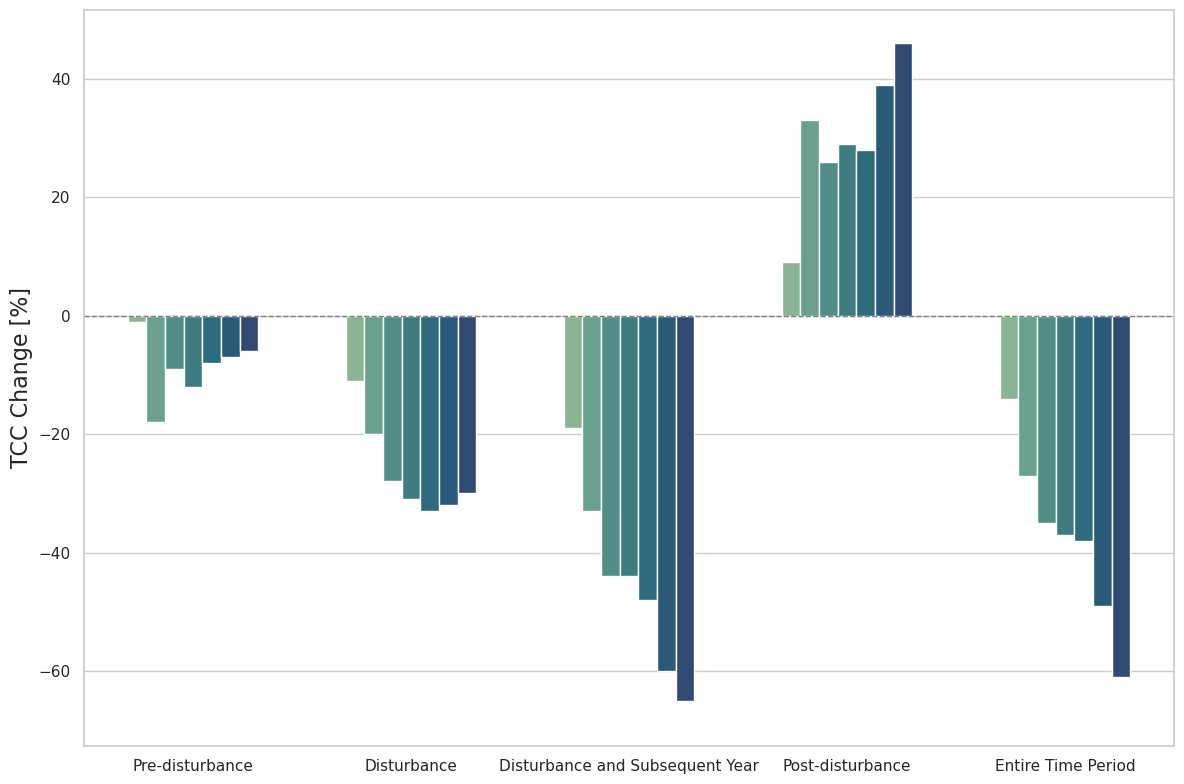

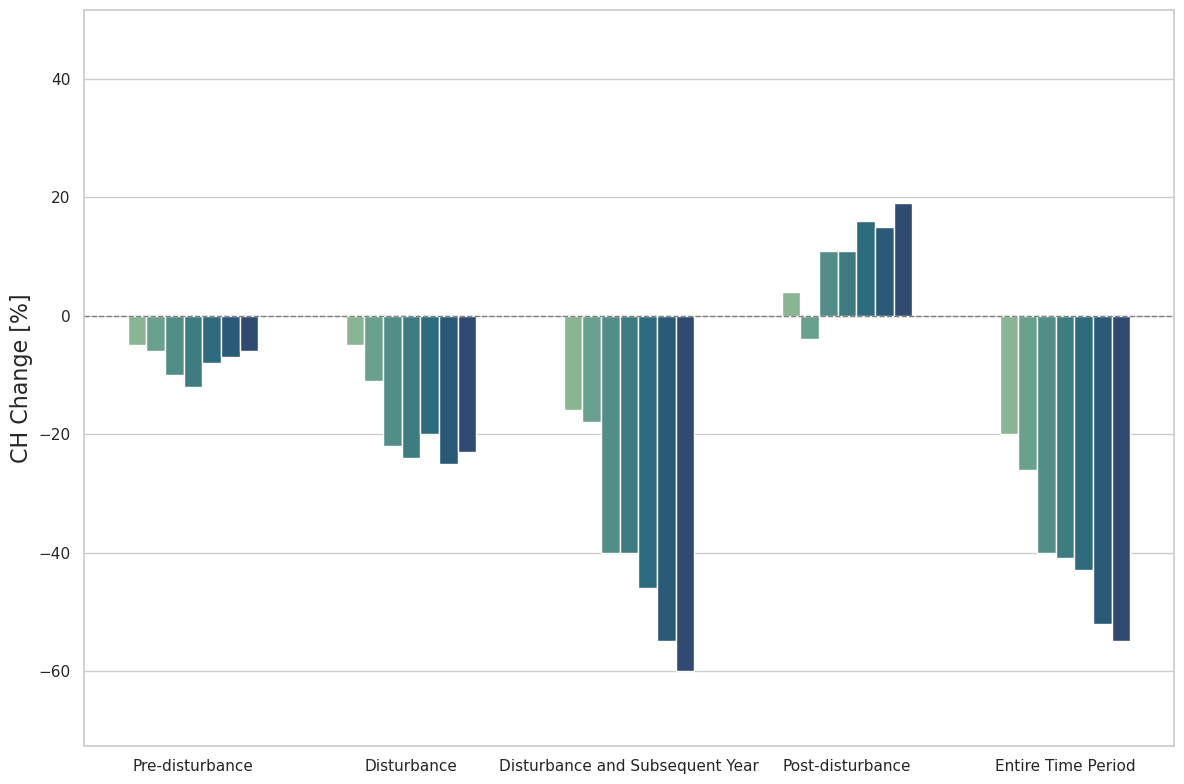

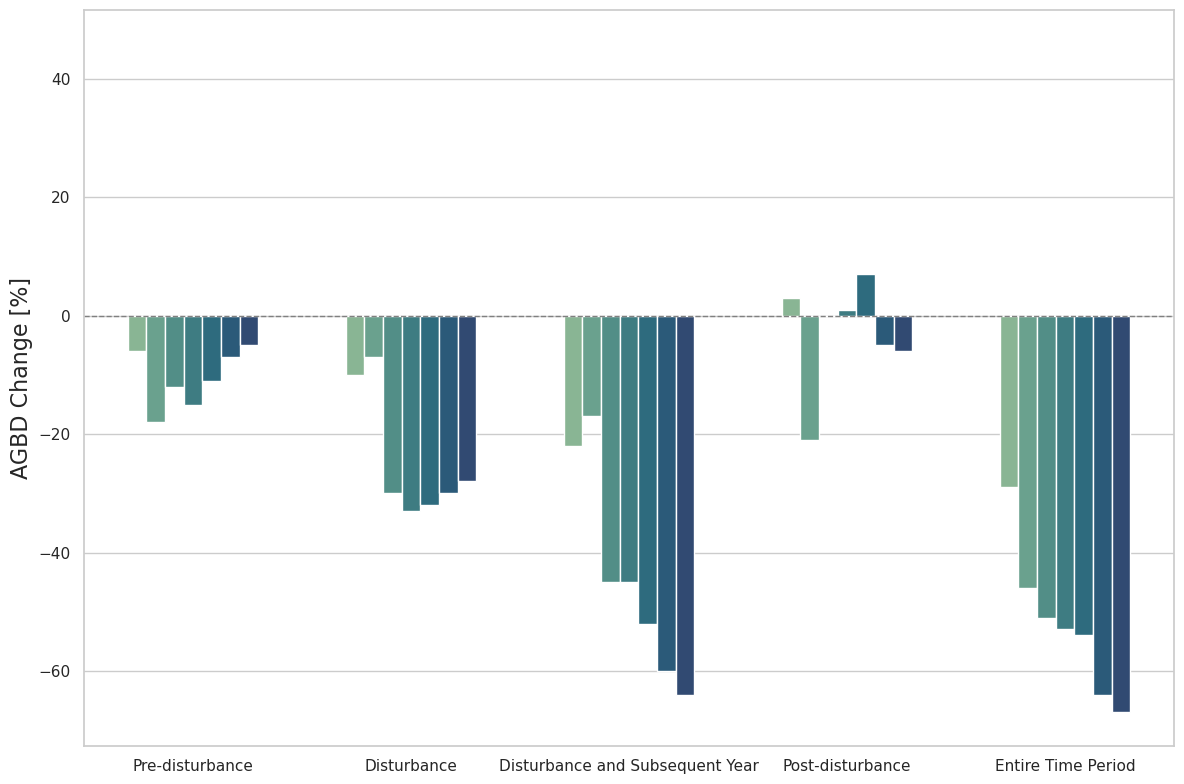

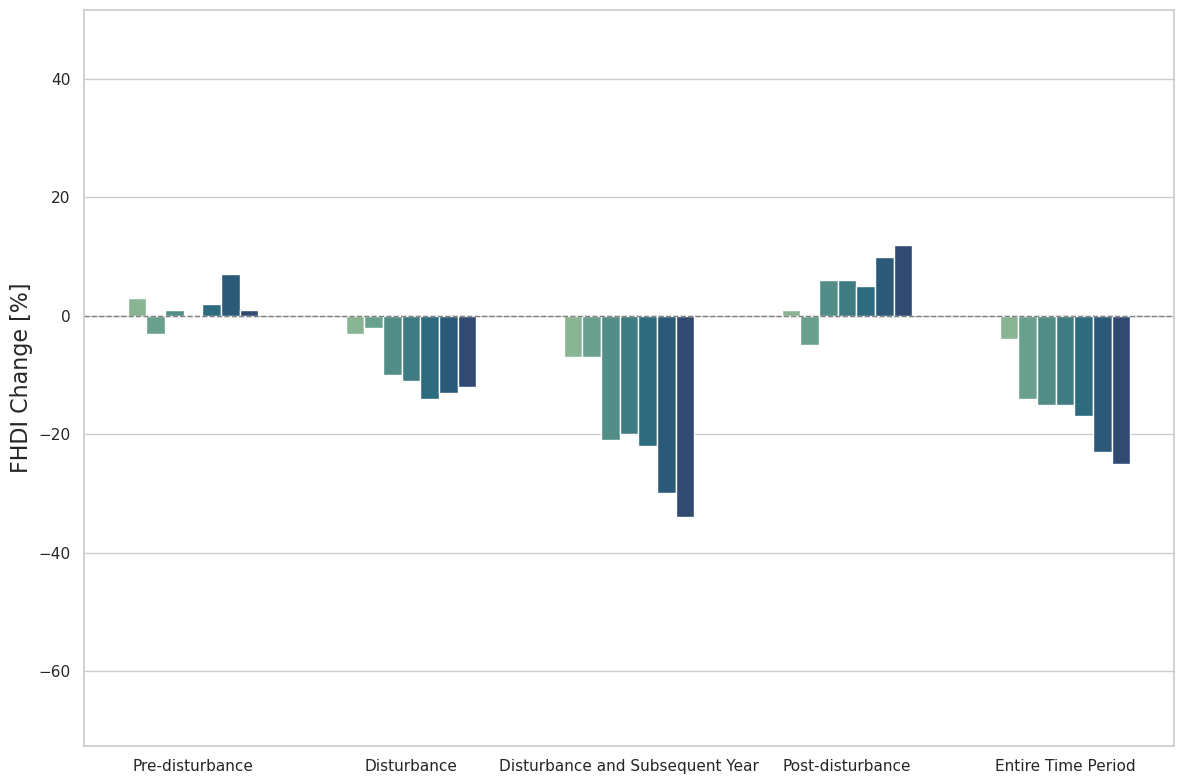

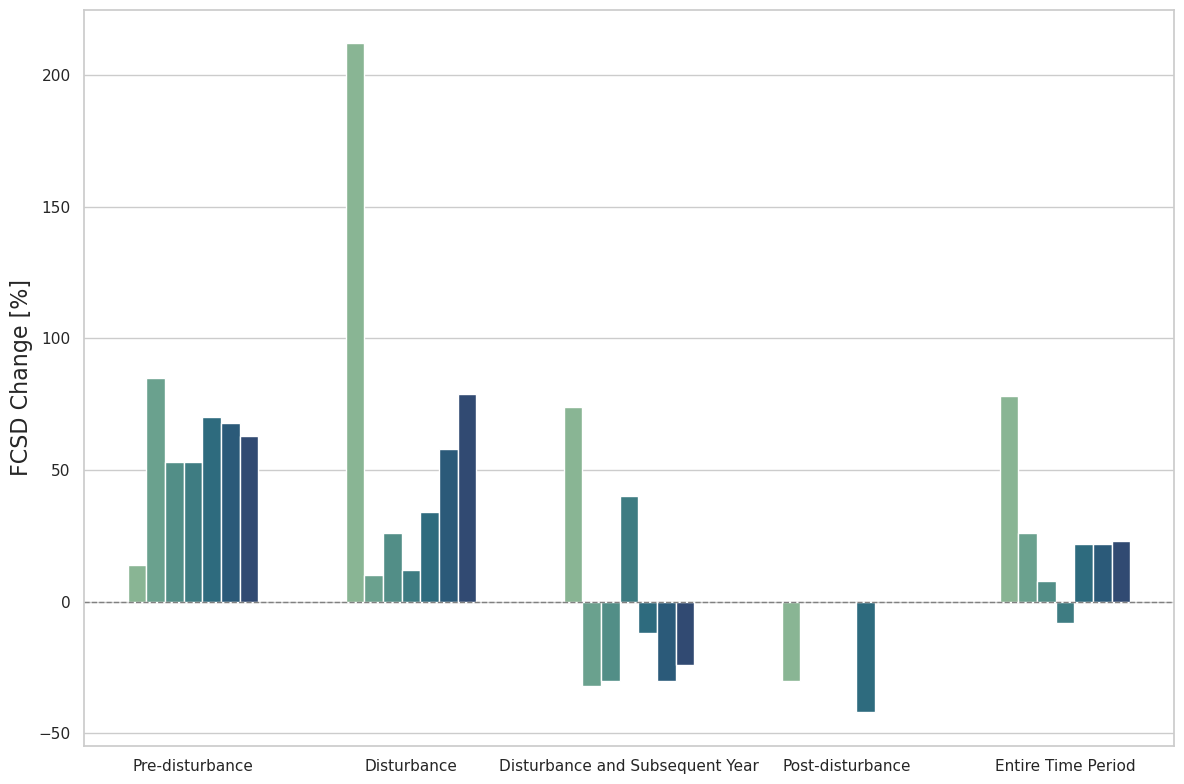

In [26]:
# Set seaborn style
sns.set(style="whitegrid")

# Variable groups for different y-axis scaling
group_1 = ["TCC", "CH", "AGBD", "FHDI"]
group_2 = ["FCSD"]

# Ensure all variables exist in the DataFrame
available_vars = [var for var in variables if var in df.columns]

# Compute buffered y-axis ranges
def get_buffered_range(data, buffer=0.05):
    data_min = data.min()
    data_max = data.max()
    range_span = data_max - data_min
    return data_min - buffer * range_span, data_max + buffer * range_span

# Get y-axis ranges with buffer for each group
group_1_min, group_1_max = get_buffered_range(df[group_1].stack())
group_2_min, group_2_max = get_buffered_range(df[group_2].stack())

# Main plotting loop
for var in available_vars:

    plt.figure(figsize=(12, 8))

    # Prepare data
    plot_df = df.copy()
    plot_df["Disturbance Pattern"] = pd.Categorical(
        plot_df["Disturbance Pattern"], 
        categories=entire_sorted, 
        ordered=True
    )

    # Order time periods
    time_labels = main_time_order + ["Entire Time Period"]
    plot_df["Time Period"] = pd.Categorical(
        plot_df["Time Period"], 
        categories=time_labels, 
        ordered=True
    )

    # Plot bar chart
    sns.barplot(
        data=plot_df,
        x="Time Period",
        y=var,
        hue="Disturbance Pattern",
        hue_order=entire_sorted,
        palette="crest",
        width=0.6
    )

    # Final styling
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel(f"{var} Change [%]", fontsize=16)
    plt.xlabel("")
    plt.xticks(
        ticks=np.arange(len(time_labels)),
        labels=time_labels
    )

    # Set group-specific y-axis range
    if var in group_1:
        plt.ylim(group_1_min, group_1_max)
    elif var in group_2:
        plt.ylim(group_2_min, group_2_max)

    # Optional: legend
    plt.legend(
        title="Disturbance Pattern", 
        bbox_to_anchor=(1.05, 1), 
        loc='center left', 
        title_fontproperties=bold_title, 
        frameon=False
    )
    plt.legend().remove()

    plt.tight_layout()
    plt.show()


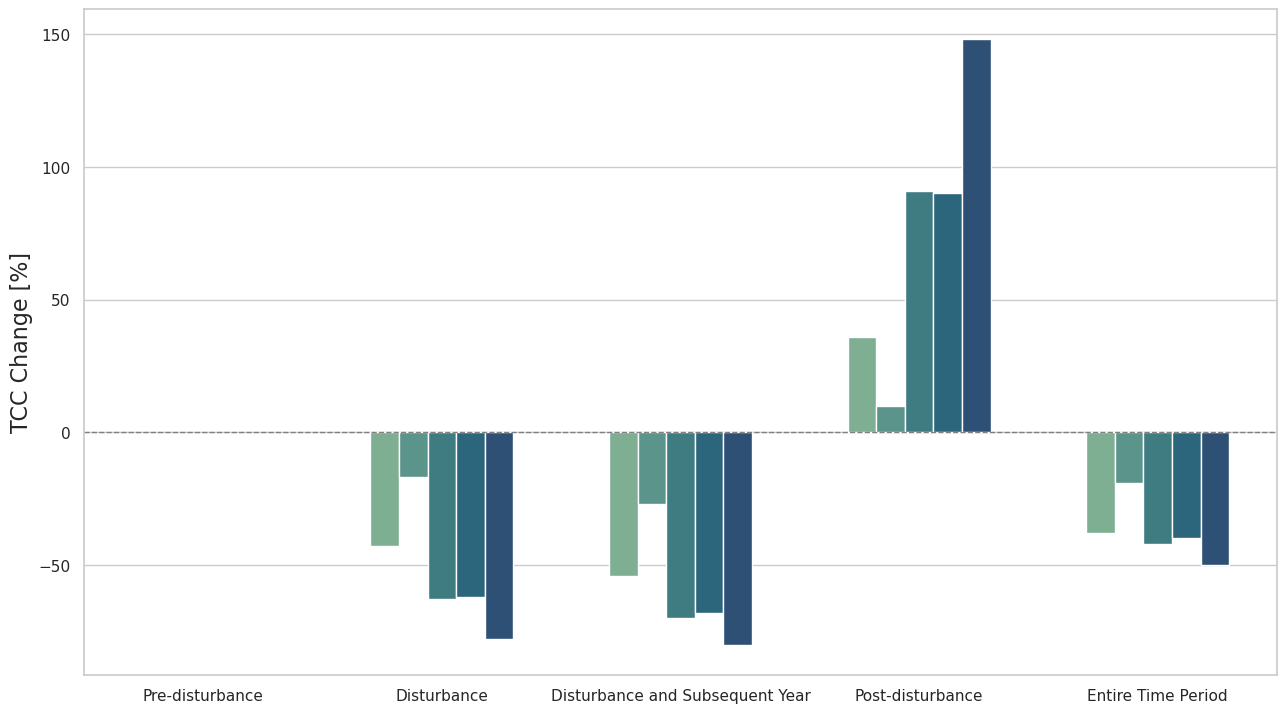

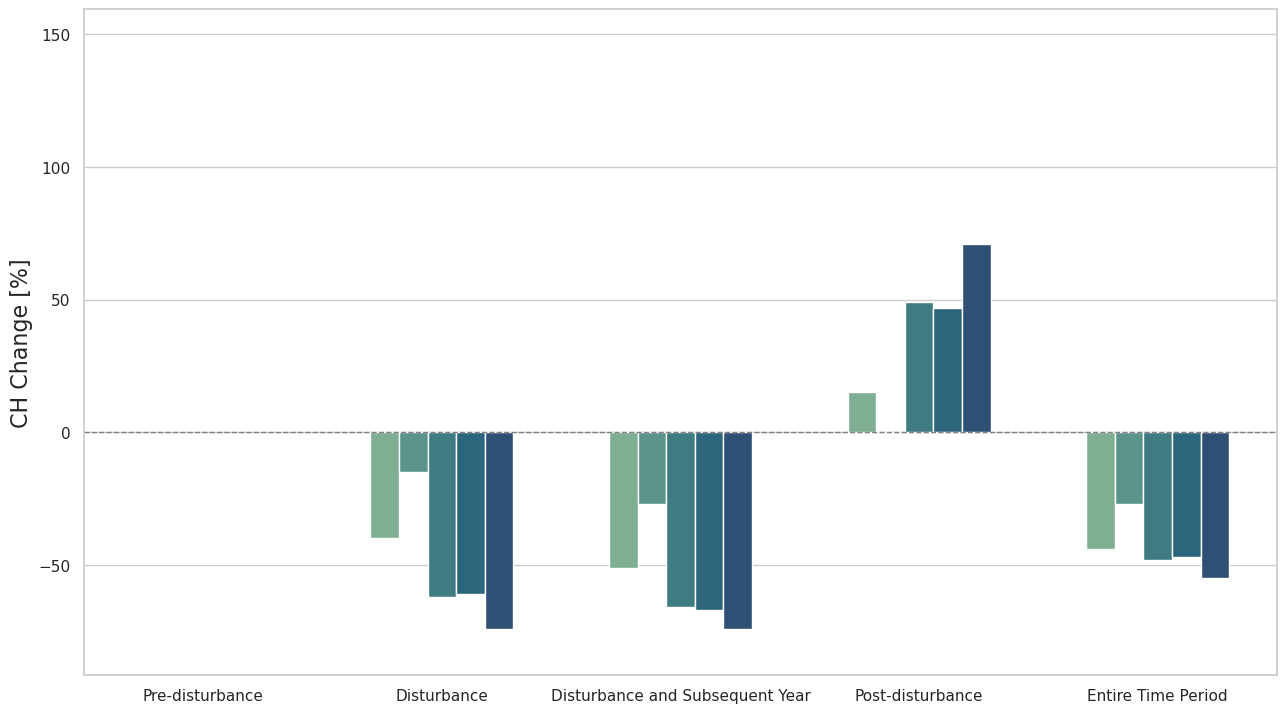

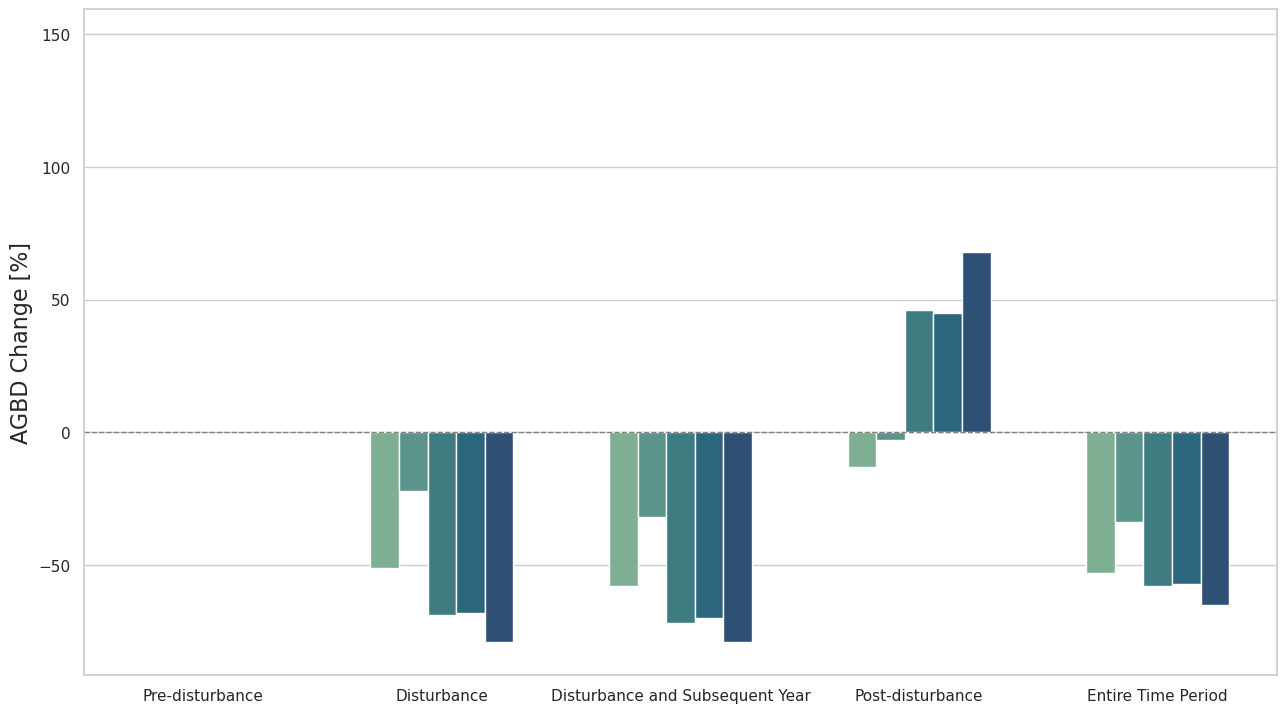

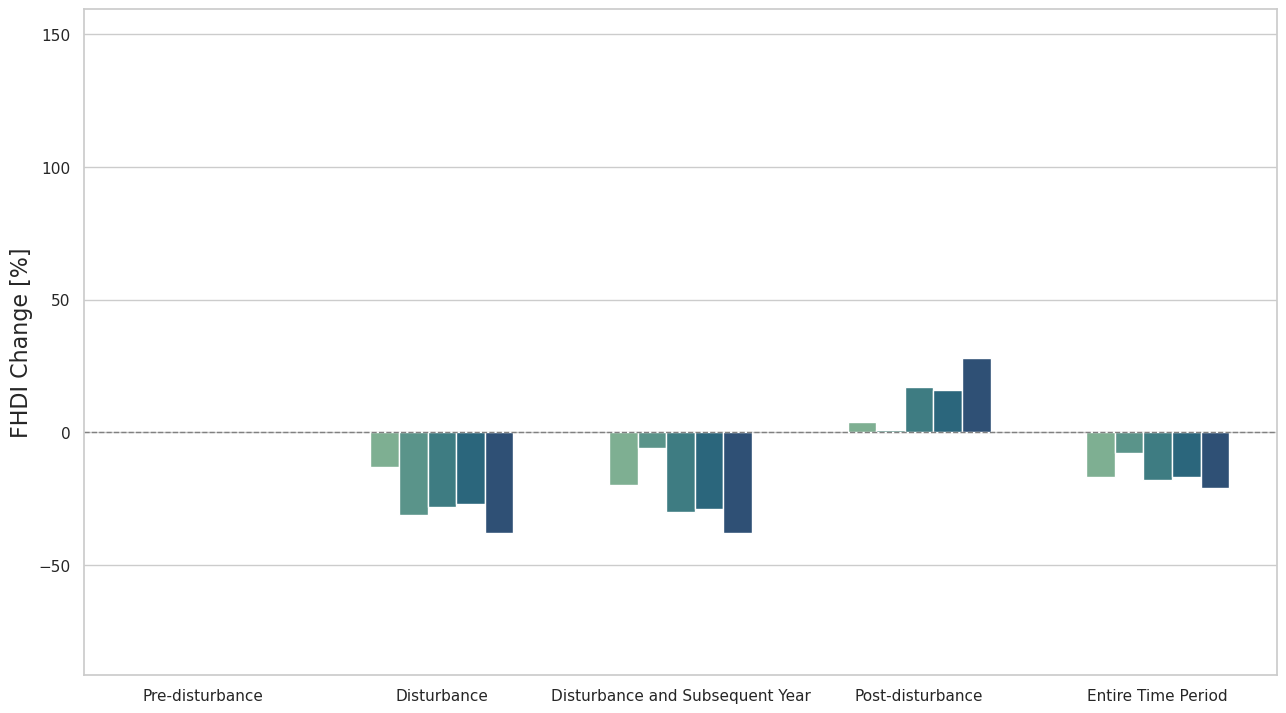

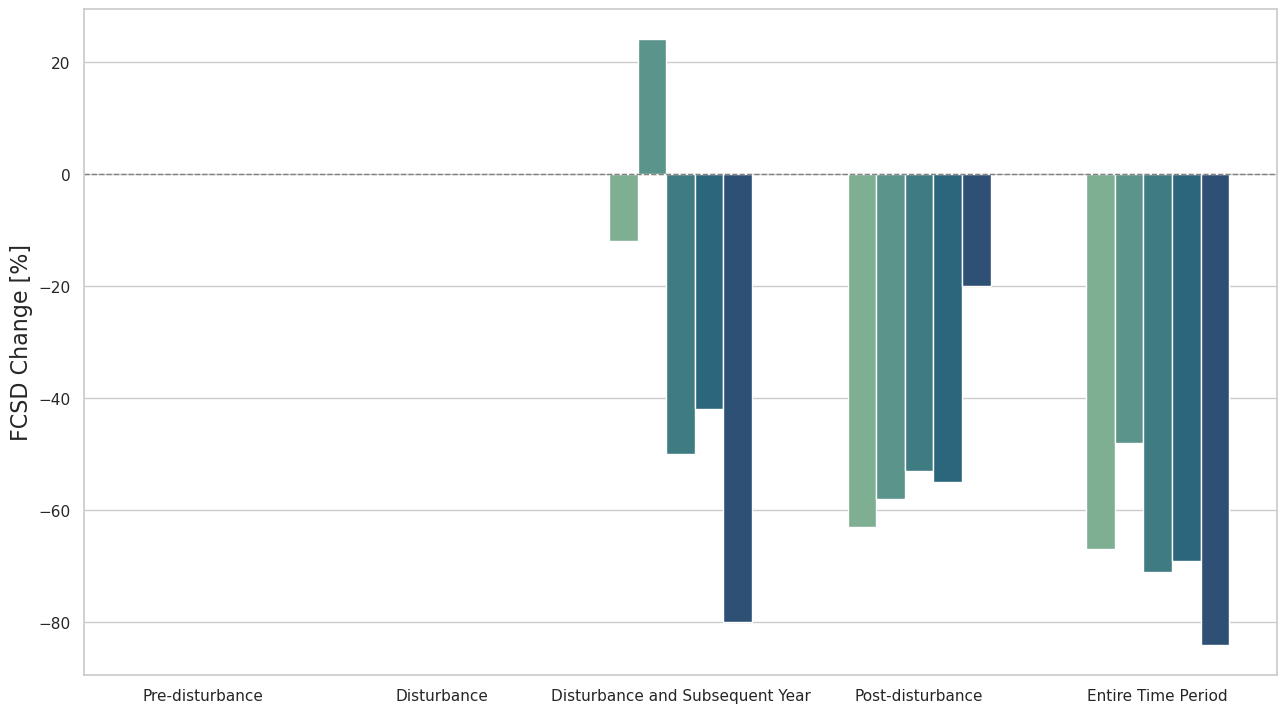

In [21]:
data_hesse = [
    ["Damage", "Pre-disturbance", None, None, None, None, None],
    ["Damage", "Disturbance", -43, -40, -51, -13, None],
    ["Damage", "Disturbance and Subsequent Year", -54, -51, -58, -20, -12],
    ["Damage", "Post-disturbance", 36, 15, -13, 4, -63],
    ["Damage", "Entire Time Period", -38, -44, -53, -17, -67],
    ["Potential Damage", "Pre-disturbance", None, None, None, None, None],
    ["Potential Damage", "Disturbance", -17, -15, -22, -31, None],
    ["Potential Damage", "Disturbance and Subsequent Year", -27, -27, -32, -6, 24],
    ["Potential Damage", "Post-disturbance", 10, 0, -3, 1, -58],
    ["Potential Damage", "Entire Time Period", -19, -27, -34, -8, -48],
    ["Clear cut", "Pre-disturbance", None, None, None, None, None],
    ["Clear cut", "Disturbance", -63, -62, -69, -28, None],
    ["Clear cut", "Disturbance and Subsequent Year", -70, -66, -72, -30, -50],
    ["Clear cut", "Post-disturbance", 91, 49, 46, 17, -53],
    ["Clear cut", "Entire Time Period", -42, -48, -58, -18, -71],
    ["Clear cut (small-scale)", "Pre-disturbance", None, None, None, None, None],
    ["Clear cut (small-scale)", "Disturbance", -62, -61, -68, -27, None],
    ["Clear cut (small-scale)", "Disturbance and Subsequent Year", -68, -67, -70, -29, -42],
    ["Clear cut (small-scale)", "Post-disturbance", 90, 47, 45, 16, -55],
    ["Clear cut (small-scale)", "Entire Time Period", -40, -47, -57, -17, -69],
    ["Clear cut (large-scale)", "Pre-disturbance", None, None, None, None, None],
    ["Clear cut (large-scale)", "Disturbance", -78, -74, -79, -38, None],
    ["Clear cut (large-scale)", "Disturbance and Subsequent Year", -80, -74, -79, -38, -80],
    ["Clear cut (large-scale)", "Post-disturbance", 148, 71, 68, 28, -20],
    ["Clear cut (large-scale)", "Entire Time Period", -50, -55, -65, -21, -84],
]

columns = ["Disturbance Pattern", "Time Period", "TCC", "CH", "AGBD", "FHDI", "FCSD"]
df_hesse = pd.DataFrame(data_hesse, columns=columns)

# Define order for consistent plotting
time_order = ["Pre-disturbance", "Disturbance", "Disturbance and Subsequent Year", "Post-disturbance", "Entire Time Period"]
df_hesse["Time Period"] = pd.Categorical(df_hesse["Time Period"], categories=time_order, ordered=True)

# Define disturbance order for hue
pattern_order = df_hesse["Disturbance Pattern"].dropna().unique().tolist()
df_hesse["Disturbance Pattern"] = pd.Categorical(df_hesse["Disturbance Pattern"], categories=pattern_order, ordered=True)

# Set seaborn style
sns.set(style="whitegrid")

variables = ["TCC", "CH", "AGBD", "FHDI", "FCSD"]
group_1 = ["TCC", "CH", "AGBD", "FHDI"]
group_2 = ["FCSD"]

# Compute buffered y-axis ranges
def get_buffered_range(data, buffer=0.05):
    data_min = data.min()
    data_max = data.max()
    range_span = data_max - data_min
    return data_min - buffer * range_span, data_max + buffer * range_span

group_1_min, group_1_max = get_buffered_range(df_hesse[group_1].stack().dropna())
group_2_min, group_2_max = get_buffered_range(df_hesse[group_2].stack().dropna())

for var in variables:
    plt.figure(figsize=(16, 8))

    sns.barplot(
        data=df_hesse,
        x="Time Period",
        y=var,
        hue="Disturbance Pattern",
        hue_order=pattern_order,
        palette="crest",
        width=0.6
    )

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel(f"{var} Change [%]", fontsize=16)
    plt.xlabel("")
    plt.xticks()

    if var in group_1:
        plt.ylim(group_1_min, group_1_max)
    elif var in group_2:
        plt.ylim(group_2_min, group_2_max)

    plt.legend(title="Disturbance Pattern", bbox_to_anchor=(1.05, 1),loc='center left',frameon=False)
    plt.tight_layout()
    plt.legend().remove()
    plt.show()

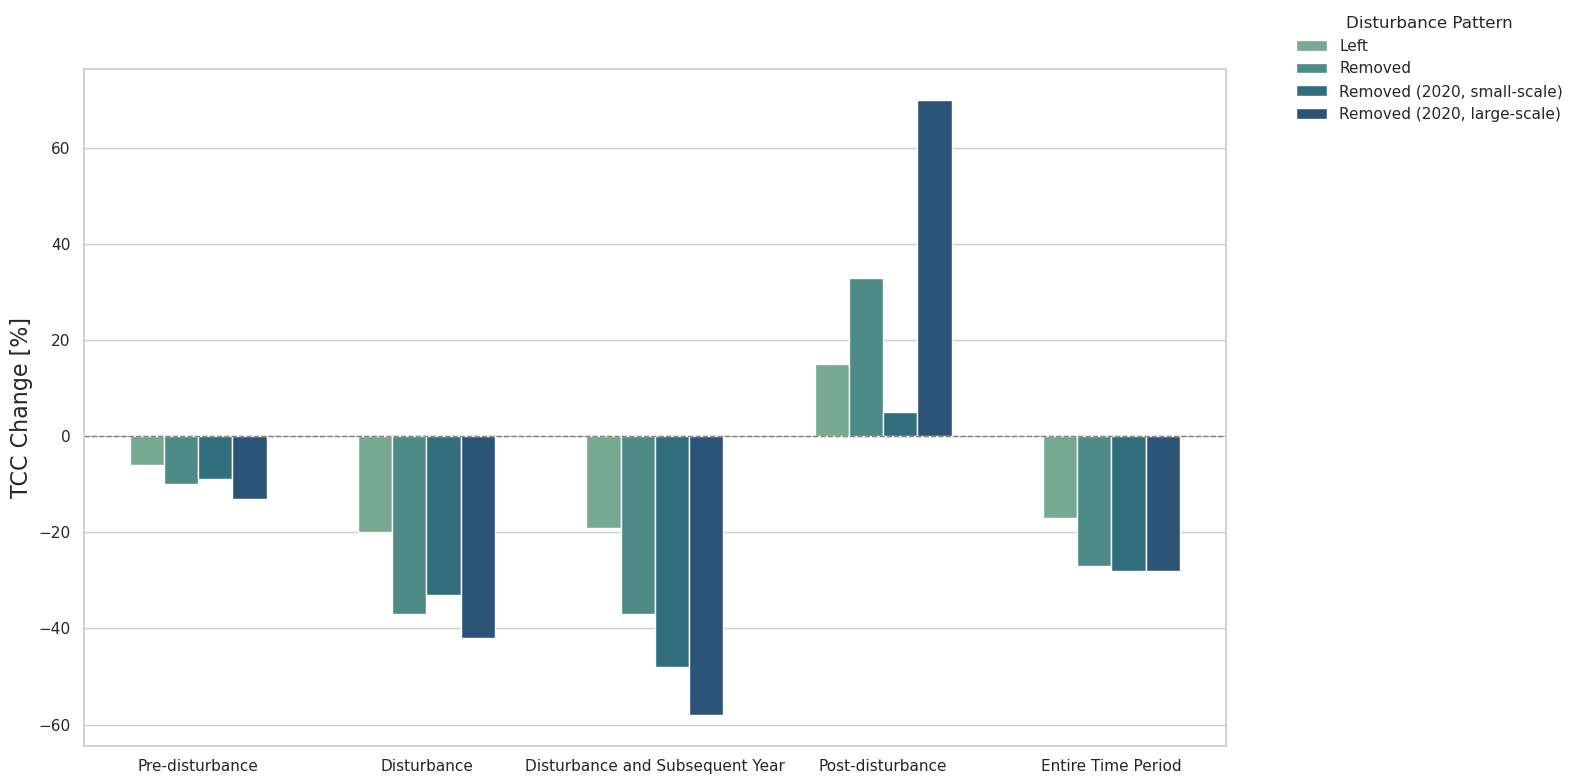

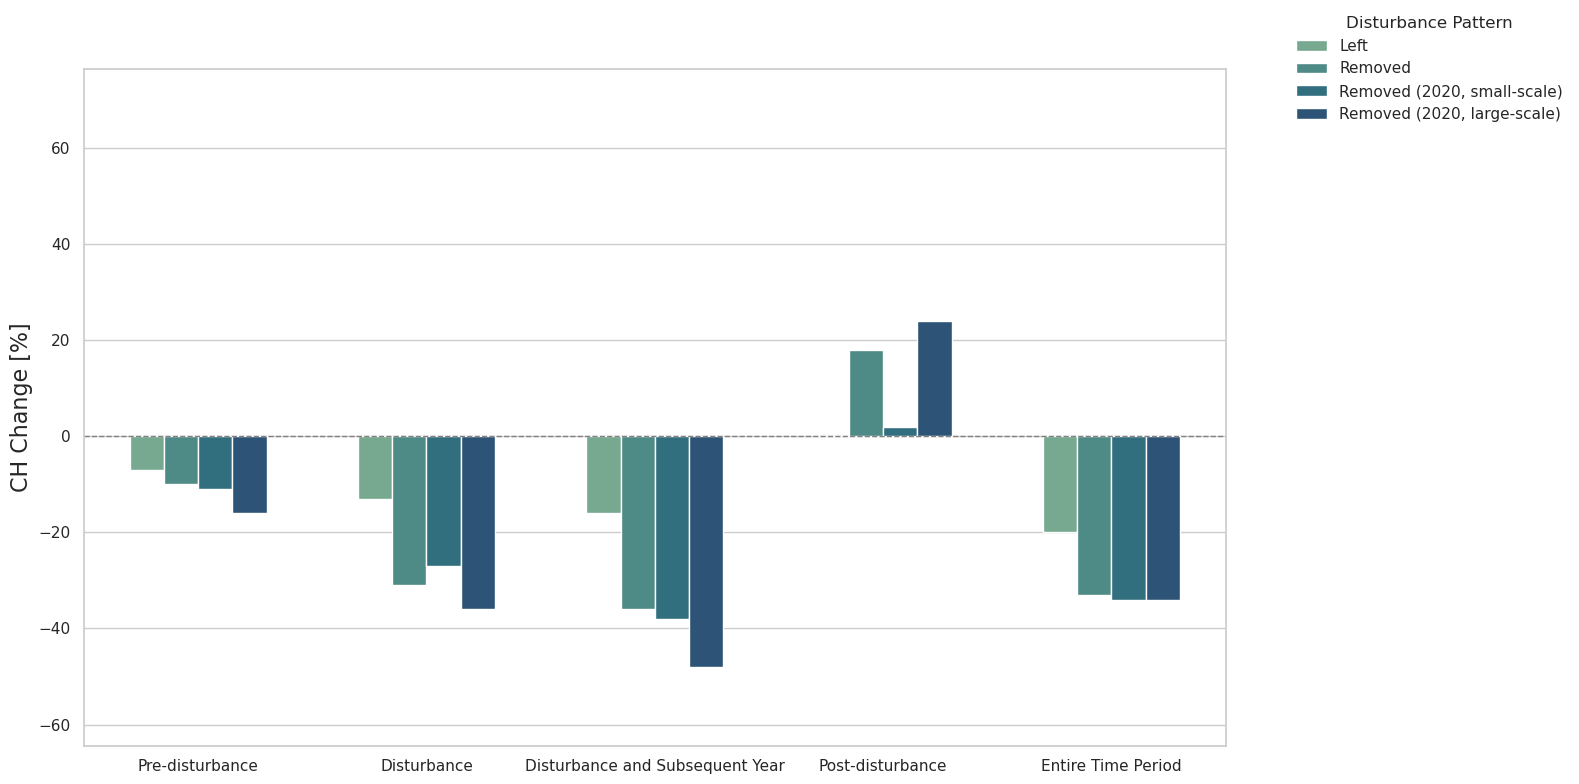

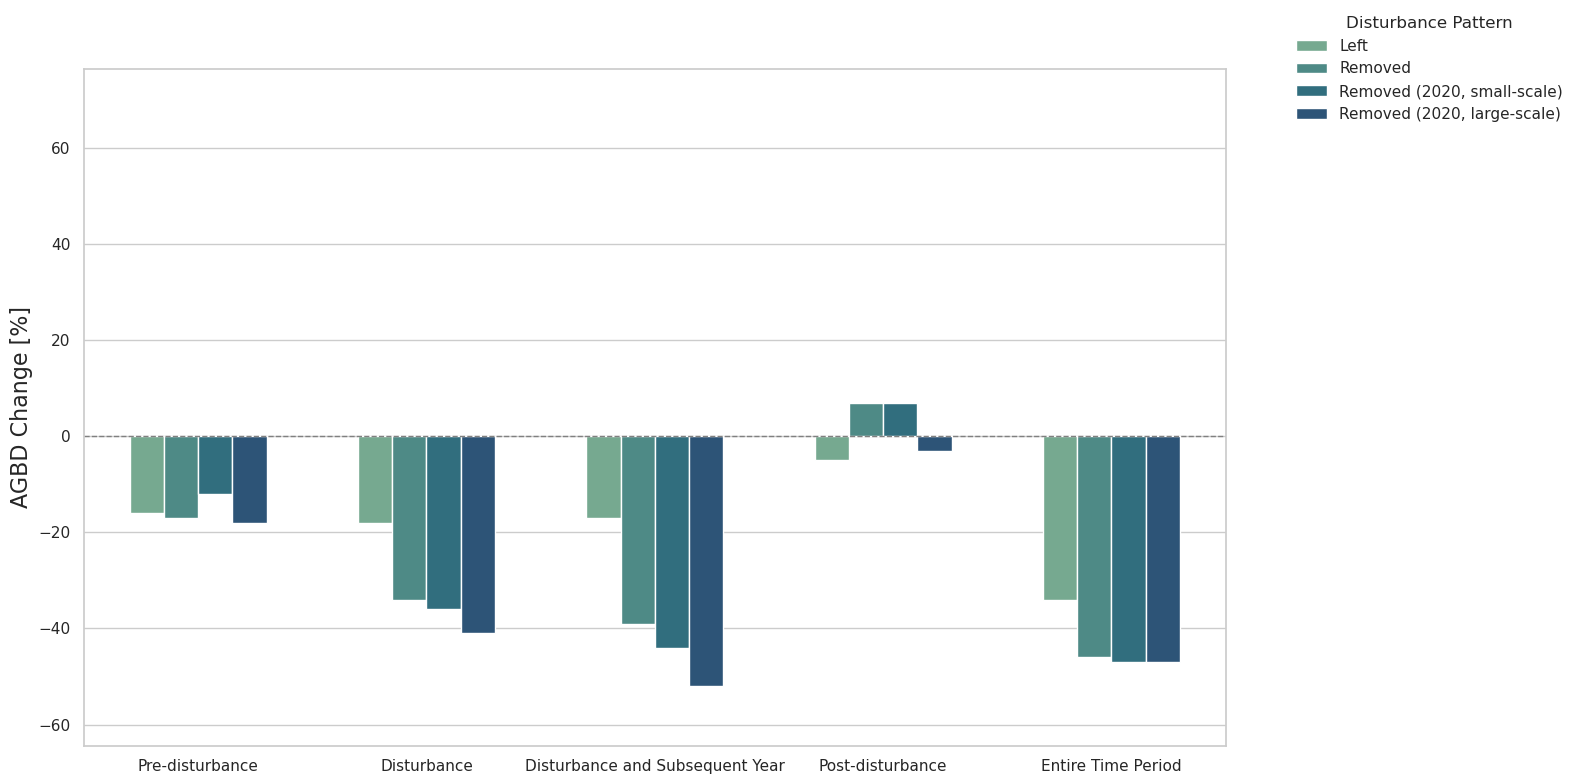

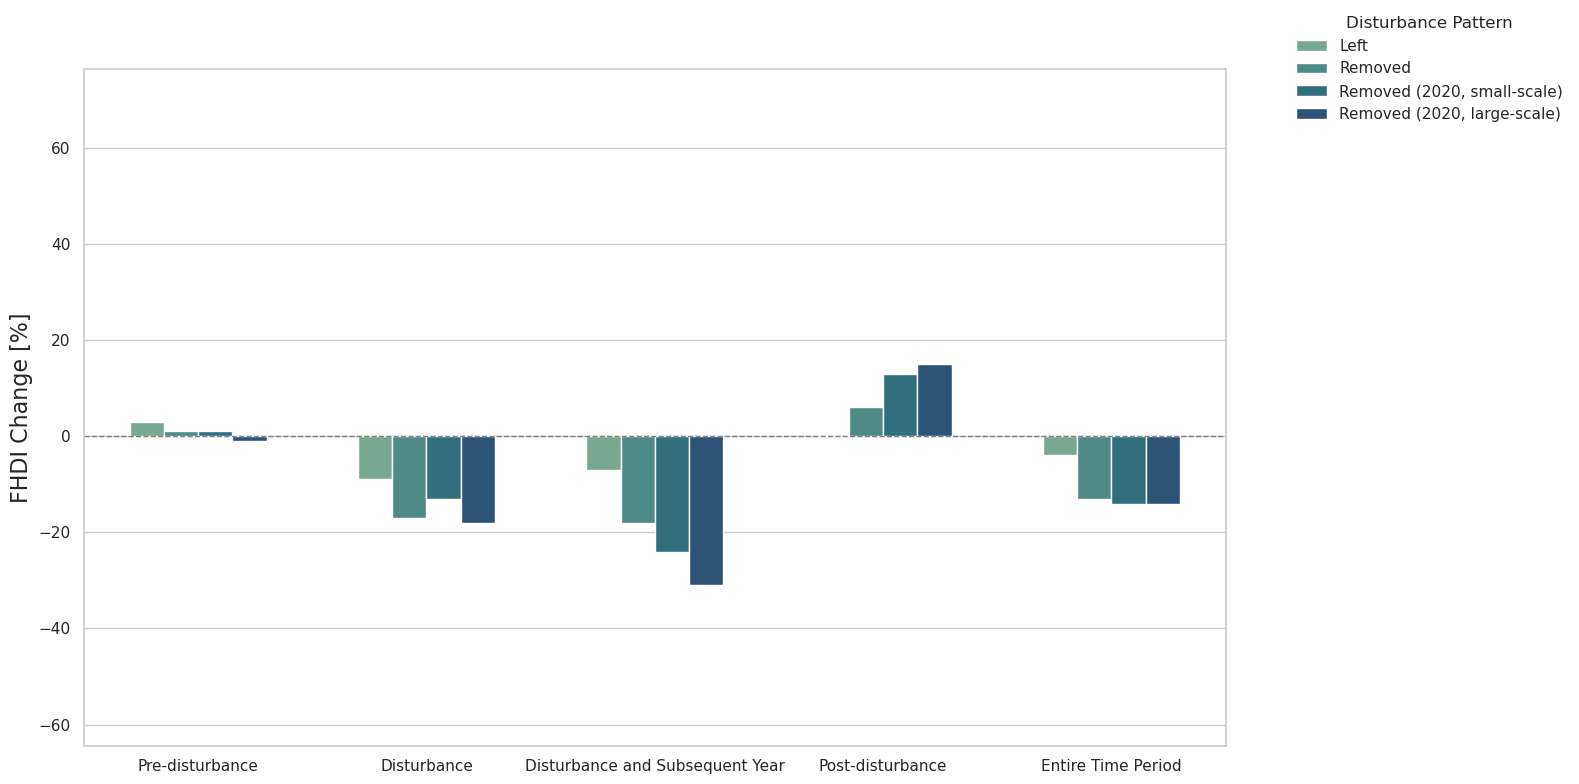

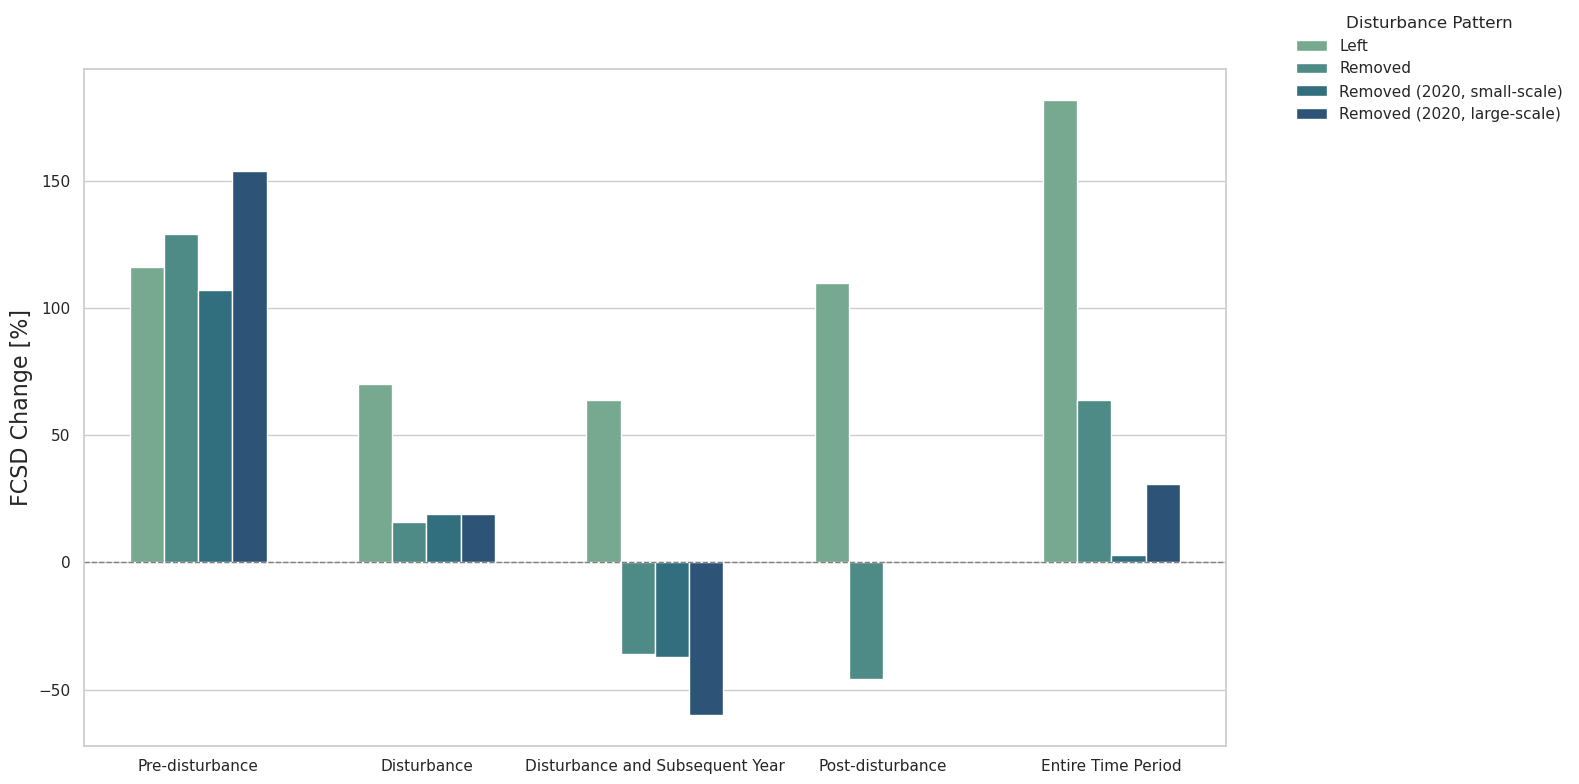

In [20]:
data_bavaria = [
    ["Left", "Pre-disturbance", -6, -7, -16, 3, 116],
    ["Left", "Disturbance", -20, -13, -18, -9, 70],
    ["Left", "Disturbance and Subsequent Year", -19, -16, -17, -7, 64],
    ["Left", "Post-disturbance", 15, 0, -5, 0, 110],
    ["Left", "Entire Time Period", -17, -20, -34, -4, 182],
    ["Removed", "Pre-disturbance", -10, -10, -17, 1, 129],
    ["Removed", "Disturbance", -37, -31, -34, -17, 16],
    ["Removed", "Disturbance and Subsequent Year", -37, -36, -39, -18, -36],
    ["Removed", "Post-disturbance", 33, 18, 7, 6, -46],
    ["Removed", "Entire Time Period", -27, -33, -46, -13, 64],
    ["Removed (2020, small-scale)", "Pre-disturbance", -9, -11, -12, 1, 107],
    ["Removed (2020, small-scale)", "Disturbance", -33, -27, -36, -13, 19],
    ["Removed (2020, small-scale)", "Disturbance and Subsequent Year", -48, -38, -44, -24, -37],
    ["Removed (2020, small-scale)", "Post-disturbance", 5, 2, 7, 13, None],
    ["Removed (2020, small-scale)", "Entire Time Period", -28, -34, -47, -14, 3],
    ["Removed (2020, large-scale)", "Pre-disturbance", -13, -16, -18, -1, 154],
    ["Removed (2020, large-scale)", "Disturbance", -42, -36, -41, -18, 19],
    ["Removed (2020, large-scale)", "Disturbance and Subsequent Year", -58, -48, -52, -31, -60],
    ["Removed (2020, large-scale)", "Post-disturbance", 70, 24, -3, 15, None],
    ["Removed (2020, large-scale)", "Entire Time Period", -28, -34, -47, -14, 31],
]

df_bavaria = pd.DataFrame(data_bavaria, columns=["Disturbance Pattern", "Time Period", "TCC", "CH", "AGBD", "FHDI", "FCSD"])

# Set time and pattern order
time_order = ["Pre-disturbance", "Disturbance", "Disturbance and Subsequent Year", "Post-disturbance", "Entire Time Period"]
df_bavaria["Time Period"] = pd.Categorical(df_bavaria["Time Period"], categories=time_order, ordered=True)

pattern_order_bavaria = df_bavaria["Disturbance Pattern"].dropna().unique().tolist()
df_bavaria["Disturbance Pattern"] = pd.Categorical(df_bavaria["Disturbance Pattern"], categories=pattern_order_bavaria, ordered=True)

variables = ["TCC", "CH", "AGBD", "FHDI", "FCSD"]
group_1 = ["TCC", "CH", "AGBD", "FHDI"]
group_2 = ["FCSD"]

def get_buffered_range(data, buffer=0.05):
    data_min = data.min()
    data_max = data.max()
    range_span = data_max - data_min
    return data_min - buffer * range_span, data_max + buffer * range_span

group_1_min, group_1_max = get_buffered_range(df_bavaria[group_1].stack().dropna())
group_2_min, group_2_max = get_buffered_range(df_bavaria[group_2].stack().dropna())

for var in variables:
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=df_bavaria,
        x="Time Period",
        y=var,
        hue="Disturbance Pattern",
        hue_order=pattern_order_bavaria,
        palette="crest",
        width=0.6
    )

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel(f"{var} Change [%]", fontsize=16)
    plt.xlabel("")
    plt.xticks()

    if var in group_1:
        plt.ylim(group_1_min, group_1_max)
    elif var in group_2:
        plt.ylim(group_2_min, group_2_max)

    plt.legend(title="Disturbance Pattern", bbox_to_anchor=(1.05, 1), loc='center left', frameon=False)
    plt.tight_layout()
    #plt.legend().remove()
    plt.show()